# Substitution

This notebook compares the predicted substitution rates with various other sets of data, such as 

 - phylofit branch length estimates
 - the number of subsitutions in genes (from Urrichio et al.)
 
The goal is to check that the model is making reasonable predictions in terms of the substitution rate. 

It is exceedingly important that we avoid cirular logic here. For example, the predicted ratchet rates per segment depend on that annotation class, which each have their own DFE estimates.

There are a few checks we can do: 

 - total predicted substitution rate versus observed 
 - spatial patterns of predicted versus observed substitution rates along the chromosome
 - predicted versus observed by feature type
 
There is not a great deal of variance in predicted substitution rates (as we'll see later). It's important that we ensure that the correspondance between predicted and observed isn't just an artifact of densities of the different annotation classes. This wouldn't be entirely an artifact or circular reasoning, but we should ensure the correspondence is good within classes too.

## Requisites

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [57]:
import pickle
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

from bgspy.models import BGSModel
from bgspy.utils import logbins, bin2midpoints, cutbins, bin2pairs, binned_summaries
from bgspy.utils import corr
from bgspy.plots import get_figax, binned_means_plot

In [3]:
plt.show()

In [4]:
plt.style.use('./buffalo.mplstyle')
plt.rcParams['figure.figsize'] = [8, 3.5]
plt.rcParams['figure.dpi'] = 200

## Data

Most of the raw data processing is done in `data/phylo/Snakefile` — see that for details. 

###  B and R Maps

In [310]:
m_pkl = '../data/bmaps/bgspy/bmap_hg38_6x7grid_10000step_10000N_cds_utrs_phastcons.pkl'
m = BGSModel.load(m_pkl)

# From the rescaled second run
mf_pkl = '../data/bmaps/bgspy/bmap_rescaled_hg38_6x7grid_10000step_10000N_cds_utrs_phastcons.pkl'
mf = BGSModel.load(mf_pkl)

In [7]:
m

### Model Fits

Just for looking at estimated DFEs

In [374]:
f = pickle.load(open('../fits/hg38_cds_utrs_phastcons_free/hg38_cds_utrs_phastcons/window_1000000/mle.pkl', 'rb'))

/tmp/ipykernel_67552/3875148197.py:1: ResourceWarning: unclosed file <_io.BufferedReader name='../fits/hg38_cds_utrs_phastcons_free/hg38_cds_utrs_phastcons/window_1000000/mle.pkl'>
  f = pickle.load(open('../fits/hg38_cds_utrs_phastcons_free/hg38_cds_utrs_phastcons/window_1000000/mle.pkl', 'rb'))


In [375]:
fit = f[1]

In [376]:
from scipy.interpolate import cubicspline

cubicspline(m.w, 

array([1.00000000e-11, 6.30957344e-11, 3.98107171e-10, 2.51188643e-09,
       1.58489319e-08, 1.00000000e-07])

In [381]:
seglens = np.diff(m.genome.segments.ranges, axis=1).squeeze()

In [385]:
T = m.genome.segments._segment_parts_sc16[2]
R = 1/T
r = np.zeros_like(R)
_ = np.divide(R, seglens[None, None, :], out=r, where=R > np.finfo(np.float64).tiny * seglens.max())

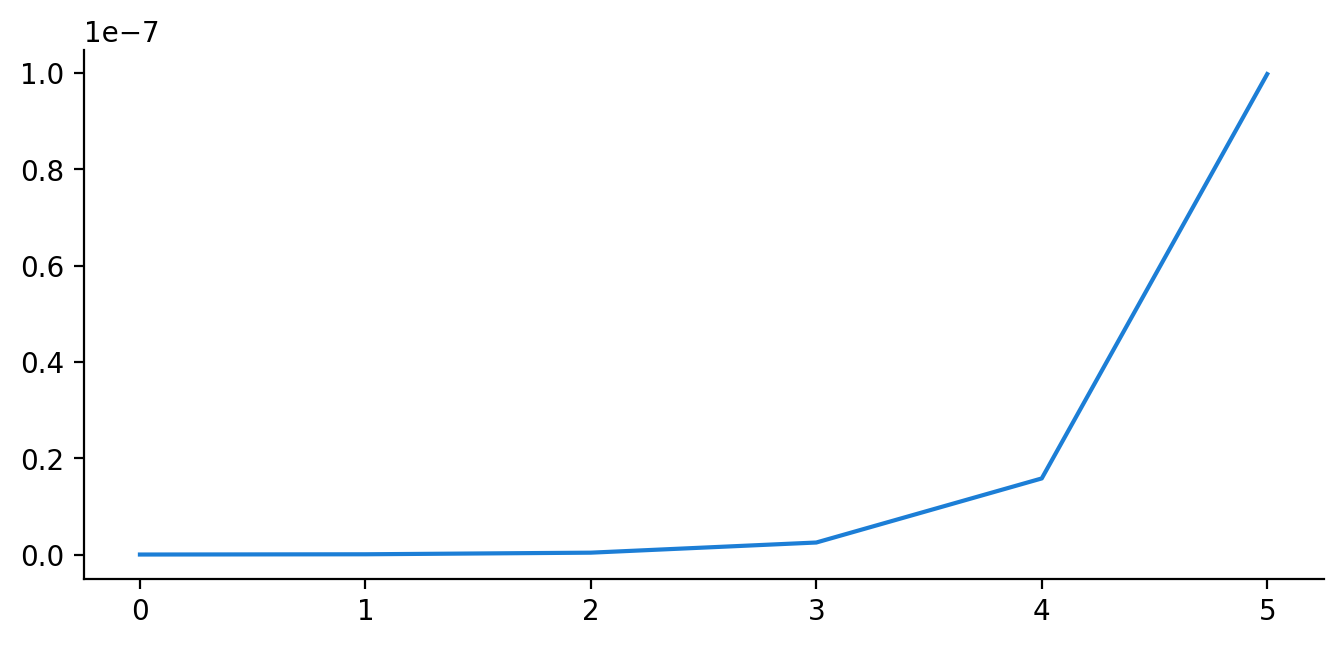

In [388]:
plt.plot(r[..., 0][:, 0])

In [390]:
np.interp(fit.mle_mu_norm[0], m.w, r[:, 0, 0])

1.4088705012833414e-08

In [409]:
mu = fit.mle_mu_norm[0]
i = np.searchsorted(m.w, mu)

l, u = m.w[i-1], m.w[i]
weight = ((mu-l)/(u - l))

weight * u + (1-weight)*l

1.4116920029884915e-08

In [412]:
r.shape

(6, 7, 7659642)

In [414]:
W = fit.mle_W.reshape((fit.nt, fit.nf))

In [415]:
W

array([[7.04413952e-10, 3.04018667e-10, 4.89589415e-08],
       [1.15786776e-08, 1.44146424e-09, 5.82155003e-08],
       [5.94789366e-10, 9.18528013e-11, 2.27448527e-10],
       [1.70349273e-11, 1.26404530e-11, 6.90188330e-10],
       [1.94413391e-10, 5.54691174e-09, 3.65840166e-09],
       [2.60608165e-11, 1.21792277e-08, 2.93827847e-11],
       [1.00152998e-09, 1.25873516e-08, 1.08961439e-08]])

In [418]:
Wc = W / W.sum(axis=0)

In [419]:
W.sum(axis=0)

array([1.41169200e-08, 3.21634672e-08, 1.22676007e-07])

In [417]:
Wc

array([[4.98985579e-02, 9.45229769e-03, 3.99091417e-01],
       [8.20198569e-01, 4.48168174e-02, 4.74546749e-01],
       [4.21330832e-02, 2.85581156e-03, 1.85405877e-03],
       [1.20670282e-03, 3.93006541e-04, 5.62610691e-03],
       [1.37716578e-02, 1.72460006e-01, 2.98216558e-02],
       [1.84606957e-03, 3.78666504e-01, 2.39515333e-04],
       [7.09453601e-02, 3.91355557e-01, 8.88204967e-02]])

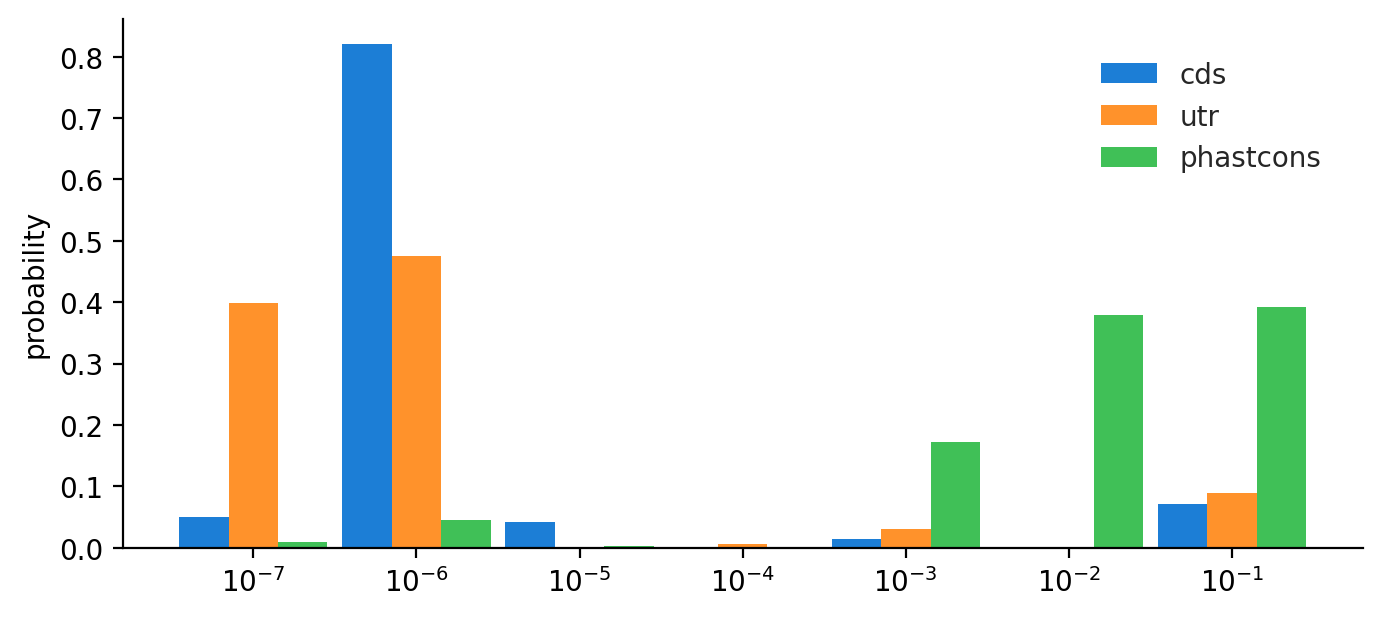

In [303]:
xt = np.log10(fit.t)

fig, ax = plt.subplots()

w = 1/3-0.03
hw = w/2
ax.bar(xt-w-hw, fit.mle_W_norm[:, 0], align='edge', width=w, label='cds')
ax.bar(xt-hw, fit.mle_W_norm[:, 2], align='edge', width=w, label='utr')
ax.bar(xt+w-hw, fit.mle_W_norm[:, 1], align='edge', width=w, label='phastcons')

ax.set_xticks(np.log10(fit.t), [f"$10^{{{int(x)}}}$" for x in xt])
ax.set_ylabel('probability')
ax.legend()

### Rescaling

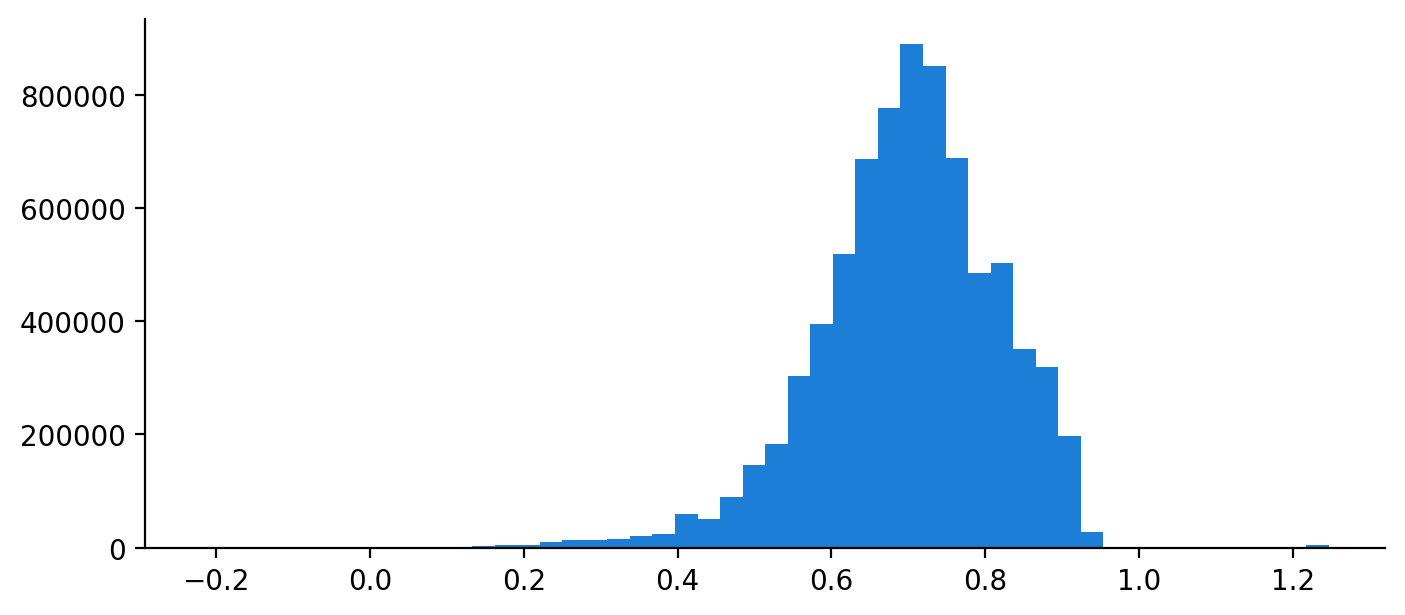

In [189]:
_ = plt.hist(mf.genome.segments.rescaling, 50)

[]

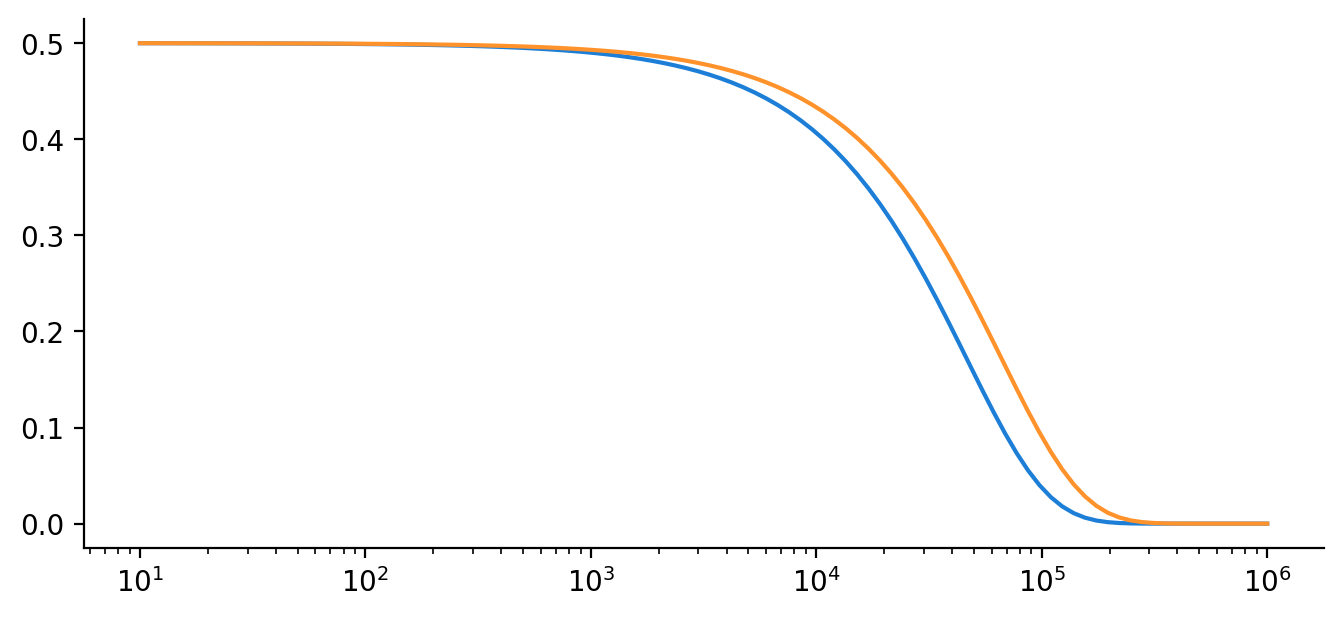

In [191]:
rrate = lambda x, s: 2*x*s / (np.exp(4*x*s)-1)

x = np.logspace(1, 6, 100)

plt.plot(x, rrate(x, 1e-5))
plt.plot(x, rrate(0.7*x, 1e-5))
plt.semilogx()

In [298]:
mf.genome.segments.rescaling.mean()

0.6998490873081481

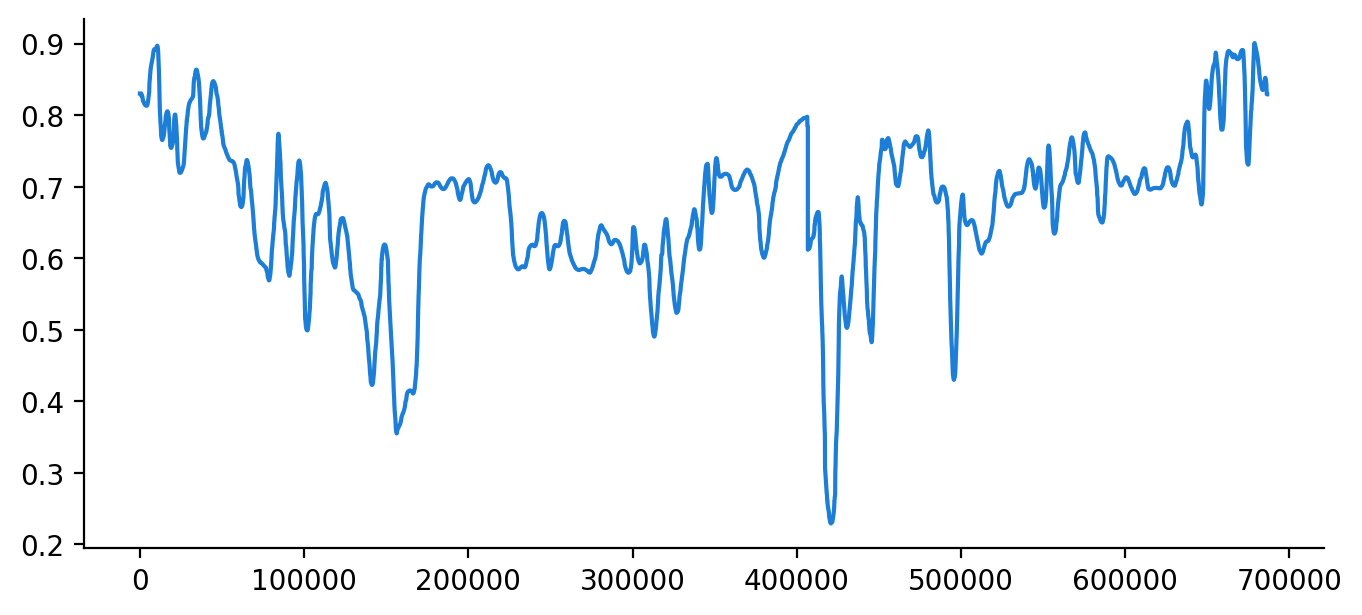

In [100]:
plt.plot(mf.genome.segments.rescaling[mf.genome.segments.index['chr1']])

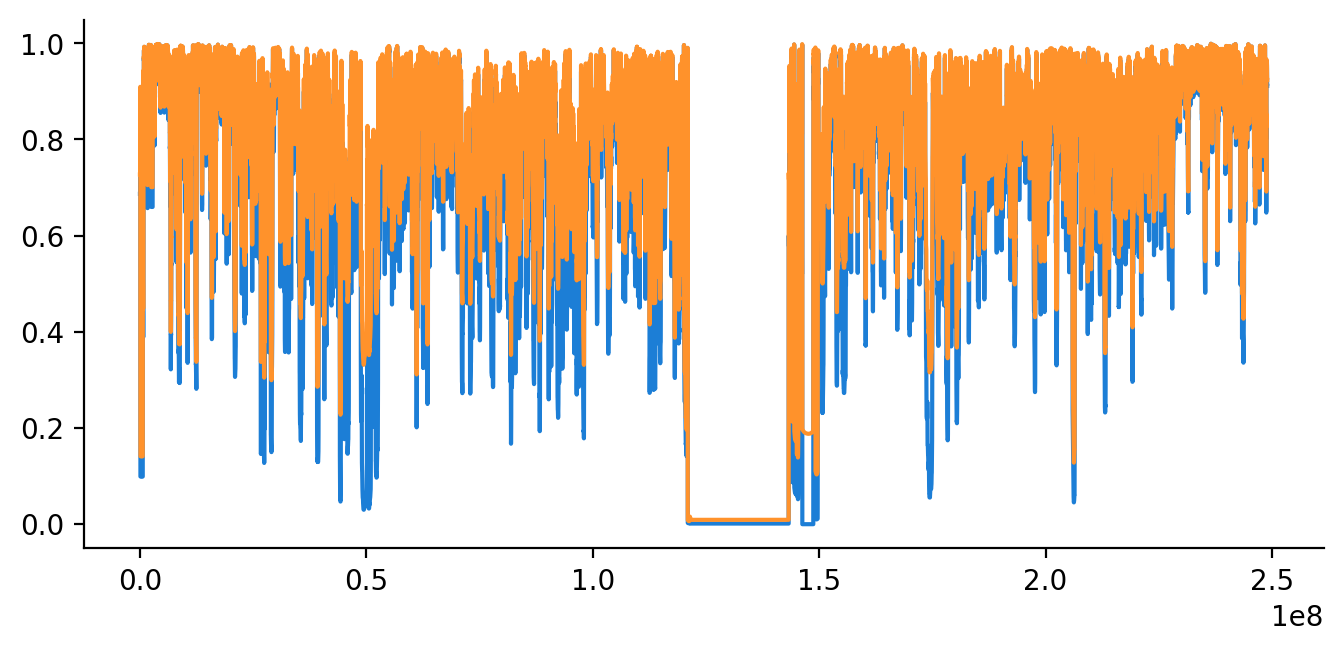

In [311]:
x, y = m.BpScores.pairs('chr1', m.w[4], 1e-4)
plt.plot(x, y[:, 1])

x, y = mf.BpScores.pairs('chr1', mf.w[4], 1e-4)
plt.plot(x, y[:, 1])

In [318]:
from bgspy.theory2 import bgs_segment_sc16

@np.vectorize
def SC16(mu, s, L, rbp, N):
    tmp = bgs_segment_sc16(mu, s, L, rbp, N, return_parts=True)
    return (tmp[1], 1/tmp[2])

N = 10_000
s = [0.1, 0.001, 1e-4, 1e-5]
SC16(1e-8, s, 10_000, 1e-8, N)

(array([0.99900095, 0.90915232, 0.51340571, 0.96920497]),
 array([0.00000000e+00, 1.69934170e-20, 7.46294415e-06, 8.18652520e-05]))

In [319]:
SC16(1e-8, s, 10_000, 1e-8, 0.7*N)

(array([0.99900095, 0.90915232, 0.76423461, 0.98631094]),
 array([0.00000000e+00, 1.93603203e-15, 2.85381929e-05, 8.68264091e-05]))

So generally, rescaling has little effect, as the average B is ~70% and as shown above, the ratchet isn't that strongly impacted by this (except for at Ns = 1). 

## Substitution Data, EDA, and Predictions versus Observed

### Raw Ratchet Data (the R Maps)

Each segment under purifying selection has an accompanying estimate of $R$, the rate of substitutions in that segment (it scales with segment length). We work with the rescaled $R/l$ version, where $l$ is the segment length.

Note that our R maps are conservative, since they do not consider how B distorts $N_e$ further from the cummulative action of all segments (this probably explains the low CV shown below):

In [365]:
cols = ['chrom', 'start', 'end', 'feature', 'R', 'r', 'seglen']

rd = pd.read_csv('../data/phylo/ratchet_data.bed', sep='\t', names=cols)
rd.groupby('feature')['r'].mean()

feature
cds          1.055389e-07
phastcons    6.620515e-09
utr          1.028444e-07
Name: r, dtype: float64

What's the coefficient of variation of predicted substitution rate?

In [108]:
rd.groupby('feature')['r'].aggregate(lambda x: x.std()/x.mean())

feature
cds          0.000079
phastcons    0.000040
utr          0.000117
Name: r, dtype: float64

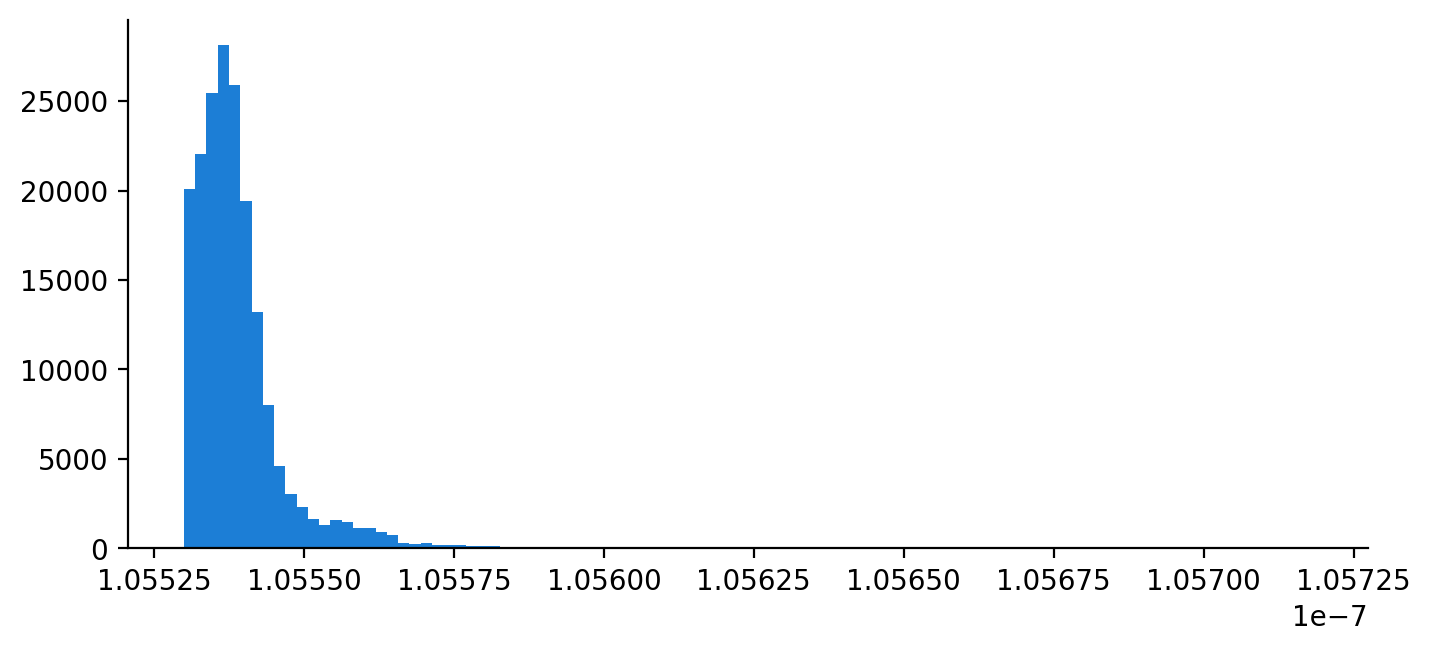

In [109]:
_ = plt.hist(rd.loc[rd['feature'] == 'cds'].r, 100)

In [421]:
rd2 = pd.read_csv('../data/phylo/ratchet_rescaled_data.bed', sep='\t', names=cols)
rd2.groupby('feature')['r'].median()

feature
cds          3.797030e-09
phastcons    4.700537e-09
utr          1.377000e-08
Name: r, dtype: float64

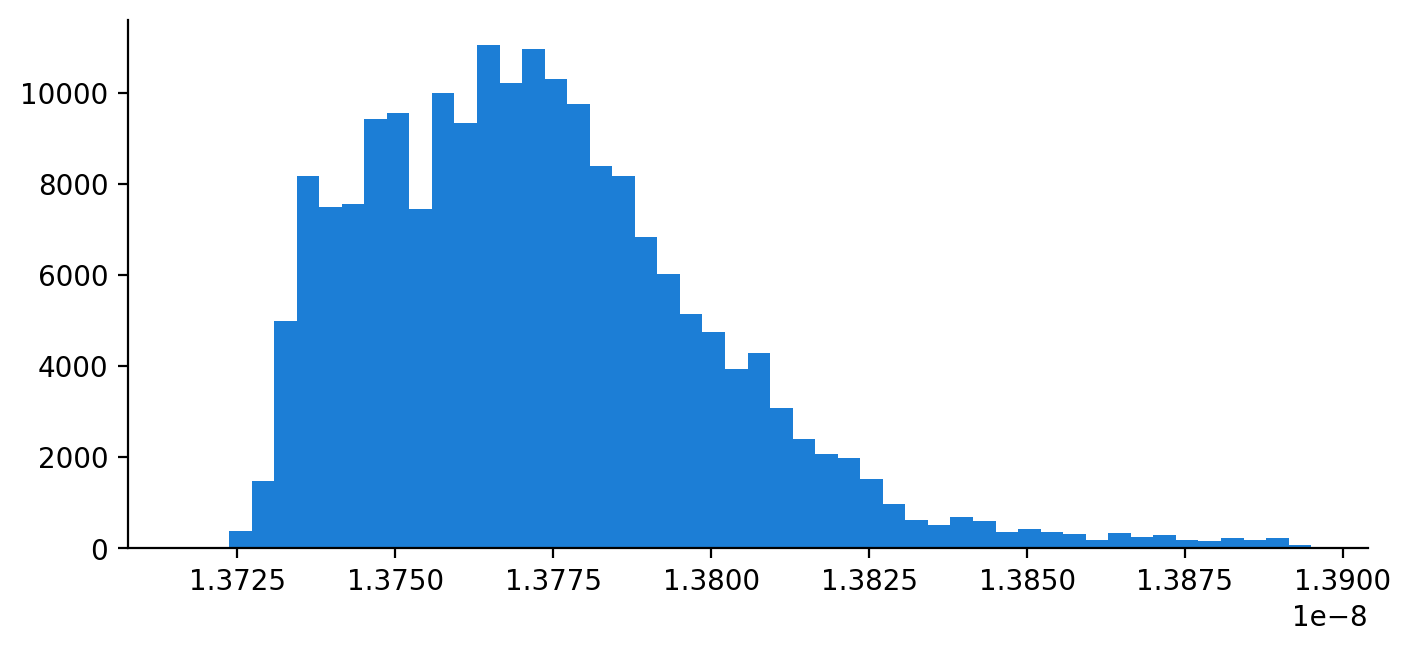

In [437]:
z = rd2.loc[rd2['feature'] == 'utr', 'r']
z = z[(z < np.quantile(z, 0.999)) & (z > np.quantile(z, 0.001))]
_ = plt.hist(z, 50)

In [112]:
rd2.groupby('feature')['r'].mean()

feature
cds          1.065021e-07
phastcons    1.746704e-08
utr          1.033114e-07
Name: r, dtype: float64

In [113]:
rd2.groupby('feature')['r'].aggregate(lambda x: x.std()/x.mean())

feature
cds           0.161731
phastcons    28.821403
utr           0.088414
Name: r, dtype: float64

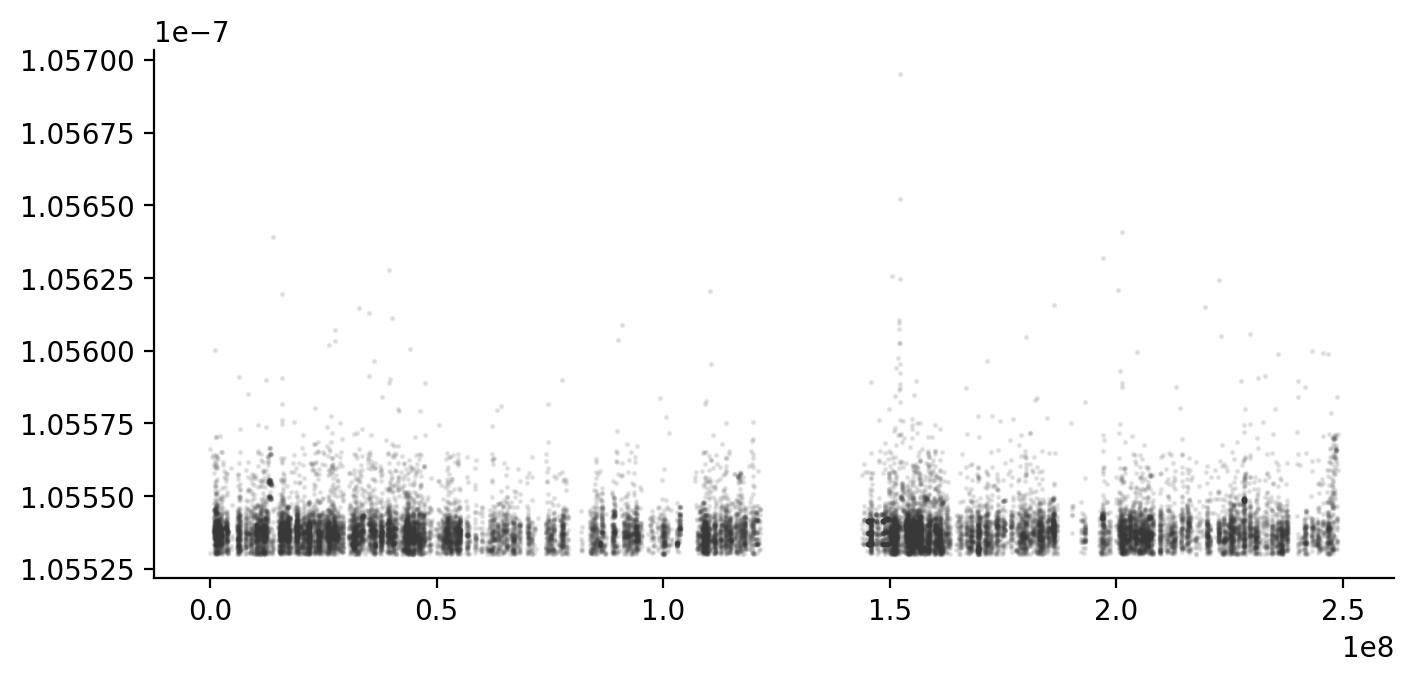

In [370]:
rdx = rd.loc[(rd['chrom'] == 'chr1') & (rd['feature'] == 'cds')]
plt.scatter(rdx['start'], rdx['r'], c='0.22', s=1, alpha=0.1)

In [452]:
rd_1Mbp = pd.read_csv('../data/phylo/ratchet_rates_binned_1000000.bed', sep='\t',
                       na_values='.',
                       names=('chrom', 'start', 'end', 'R', 'r', 'r_nbases'))

In [453]:
rd2_1Mbp = pd.read_csv('../data/phylo/ratchet_rescaled_rates_binned_1000000.bed', sep='\t',
                       na_values='.',
                       names=('chrom', 'start', 'end', 'R', 'r', 'r_nbases'))

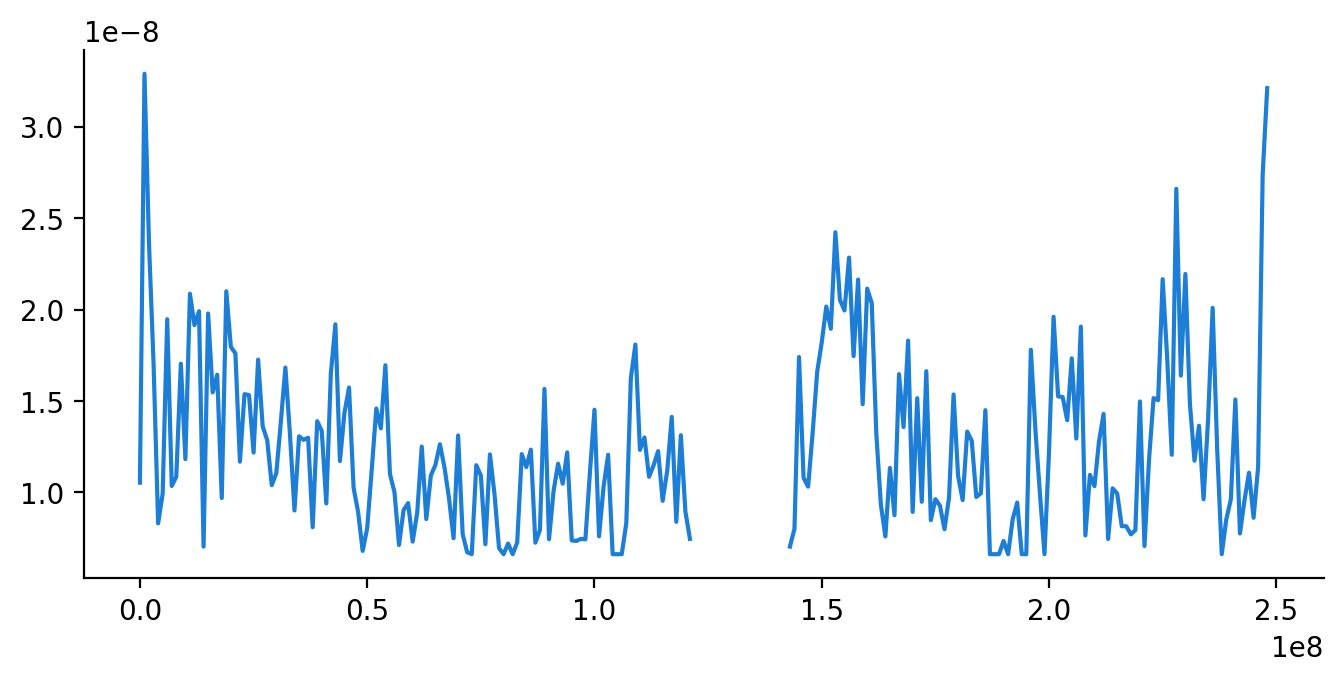

In [454]:

tmp = rd_1Mbp.loc[rd_1Mbp['chrom'] == 'chr1']
tmp2 = rd2_1Mbp.loc[rd2_1Mbp['chrom'] == 'chr1']

plt.plot(tmp['start'], tmp['r'])

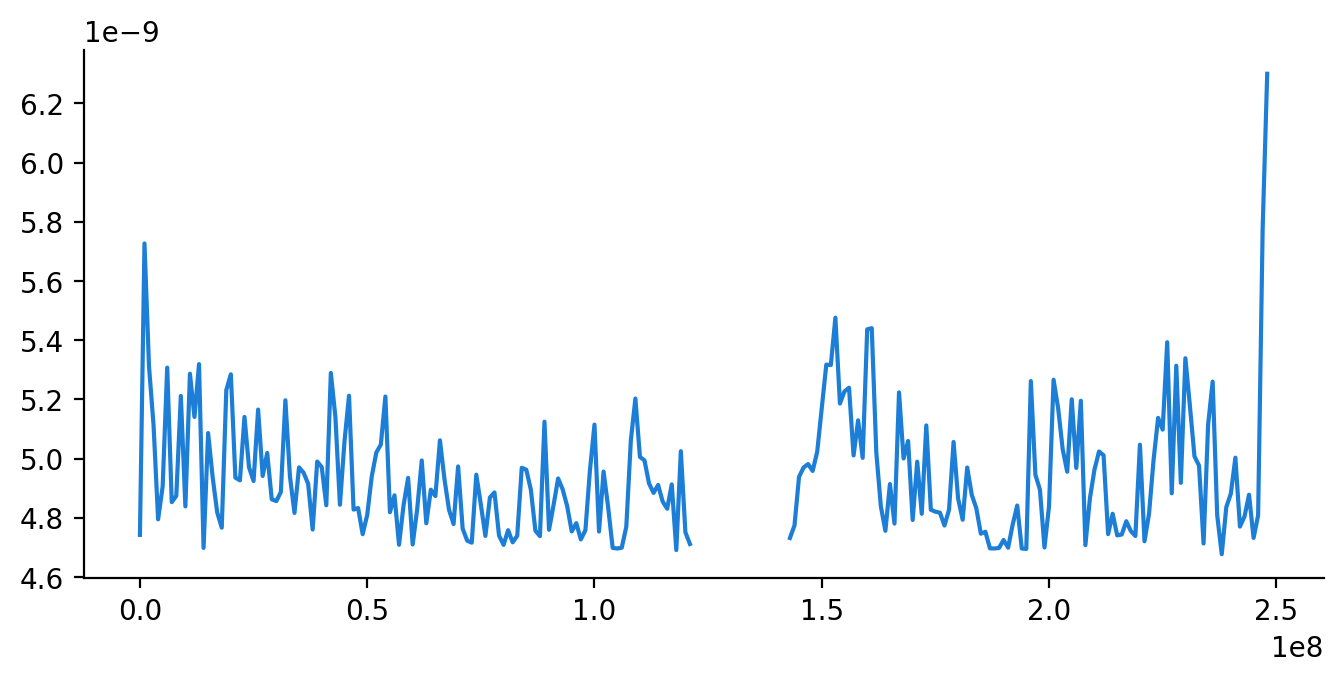

In [455]:
plt.plot(tmp2['start'], tmp2['r'])

### Uricchio et al (2019) Substitution Data

From [this paper](https://www.nature.com/articles/s41559-019-0890-6). See the `data/phylo/Snakefile` for more information on how this is processed. 

Since we want the proportion of subsitutions and the Urrichio data doesn't have the number of codons considered, I joined Uricchio's data with the Ensembl canonical transcript CDS lengths.

This dataset also has the phylofit substitution rates joined in.

In [463]:
cols = [
    "chrom",
    "start",
    "end",
    "gene_id",
    "n_nonsyn",
    "n_syn",
    "fixed_nonsyn",
    "fixed_syn",
    "dnDs",
    "total_fixed",
    "len",
    "cai",
    "gc",
    "gc3",
    "syn_prop",
    "nonsyn_prop",
    "total_prop",
    "dNdS",
    "r",
    "r_nbases",
    "r_rs", "r_rs_nbases",
    "branch_length",
    "bl_nbases",
    
]

d = pd.read_csv('../data/phylo/urrichio_data_merged.bed', sep='\t', na_values='.', names=cols)
d['width'] = d['end'] - d['start']
d['midpoint'] = 0.5*(d['start'] + d['end'])

In [464]:
d.head()

chrom   start     end          gene_id  n_nonsyn  n_syn  fixed_nonsyn  \
0  chr1  923923  944575  ENSG00000187634        28     21             8   
1  chr1  944203  959309  ENSG00000188976        31     32             4   
2  chr1  960584  965719  ENSG00000187961        11     28             0   
3  chr1  966482  975865  ENSG00000187583        47     19             0   
4  chr1  975198  982117  ENSG00000187642        31     22            11   

   fixed_syn      dnDs  total_fixed  ...  total_prop      dNdS             r  \
0          4  2.000000           12  ...    0.004739  2.000000  2.502833e-08   
1          8  0.500000           12  ...    0.005340  0.500000  4.107783e-08   
2          8  0.000000            8  ...    0.004154  0.000000  4.222435e-08   
3          3  0.000000            3  ...    0.001637  0.000000  3.766140e-08   
4          3  3.666667           14  ...    0.005907  3.666667  4.105993e-08   

   r_nbases          r_rs  r_rs_nbases  branch_length  bl_nbases  width  \
0      4658  5.035896e-09         4658            NaN        NaN  20652   
1      2950  4.688058e-09         2950            NaN        NaN  15106   
2      2776  5.717414e-09         2776            NaN        NaN   5135   
3      3800  4.771755e-09         3800            NaN        NaN   9383   
4      4203  6.126825e-09         4203            NaN        NaN   6919   

   midpoint  
0  934249.0  
1  951756.0  
2  963151.5  
3  971173.5  
4  978657.5  

[5 rows x 26 columns]

In [465]:
for chrom in d.chrom.unique():
    d.loc[d['chrom'] == chrom, 'B'] = fit.predict_B_at_pos(chrom, d.loc[d['chrom'] == chrom, 'midpoint'])

Some summary statistics on the lengths of genes, and number of bases used for estimates:

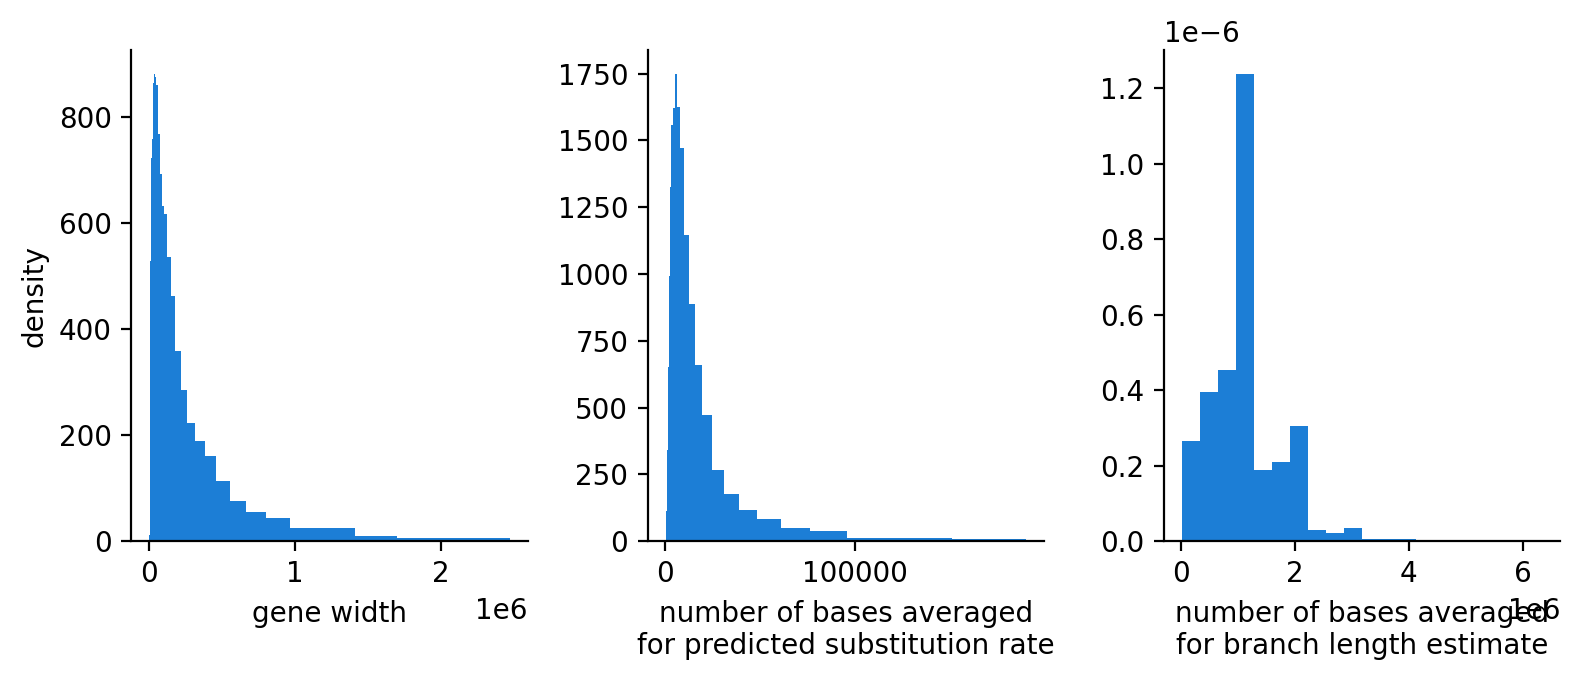

In [466]:
# width of genes, number of bases averaged for ratchet estimate, 
# number of bases averaged for 

fig, ax = plt.subplots(ncols=3)


ax[0].hist(*logbins(d['width'], 50, density=True))
ax[1].hist(*logbins(d['r_nbases'], 30, density=True))
_ = ax[2].hist(d['bl_nbases'], 20, density=True)
ax[0].set_ylabel('density')
ax[0].set_xlabel('gene width')
ax[1].set_xlabel('number of bases averaged\nfor predicted substitution rate')
ax[2].set_xlabel('number of bases averaged\nfor branch length estimate')
plt.tight_layout()

What's the correspondance between phylofit branch lengths and Uricchio's substitution proportions?

In [467]:
corr(d['branch_length'], d['total_prop'])

((0.08976777413291591, 2.3836750655202052e-20),
 SpearmanrResult(correlation=0.15373968020729717, pvalue=7.02679275898951e-57))

In [468]:
corr(d['branch_length'], d['syn_prop'])

((0.08756744579416086, 1.948516857408957e-19),
 SpearmanrResult(correlation=0.1237180655306186, pvalue=2.643241093996462e-37))

In [469]:
corr(d['branch_length'], d['nonsyn_prop'])

((0.06328288169660269, 7.527811362549272e-11),
 SpearmanrResult(correlation=0.10499026998189577, pvalue=2.7931843847397857e-27))

#### Outlier Filtering

Text(0.5, 0, 'predicted substitution rate')

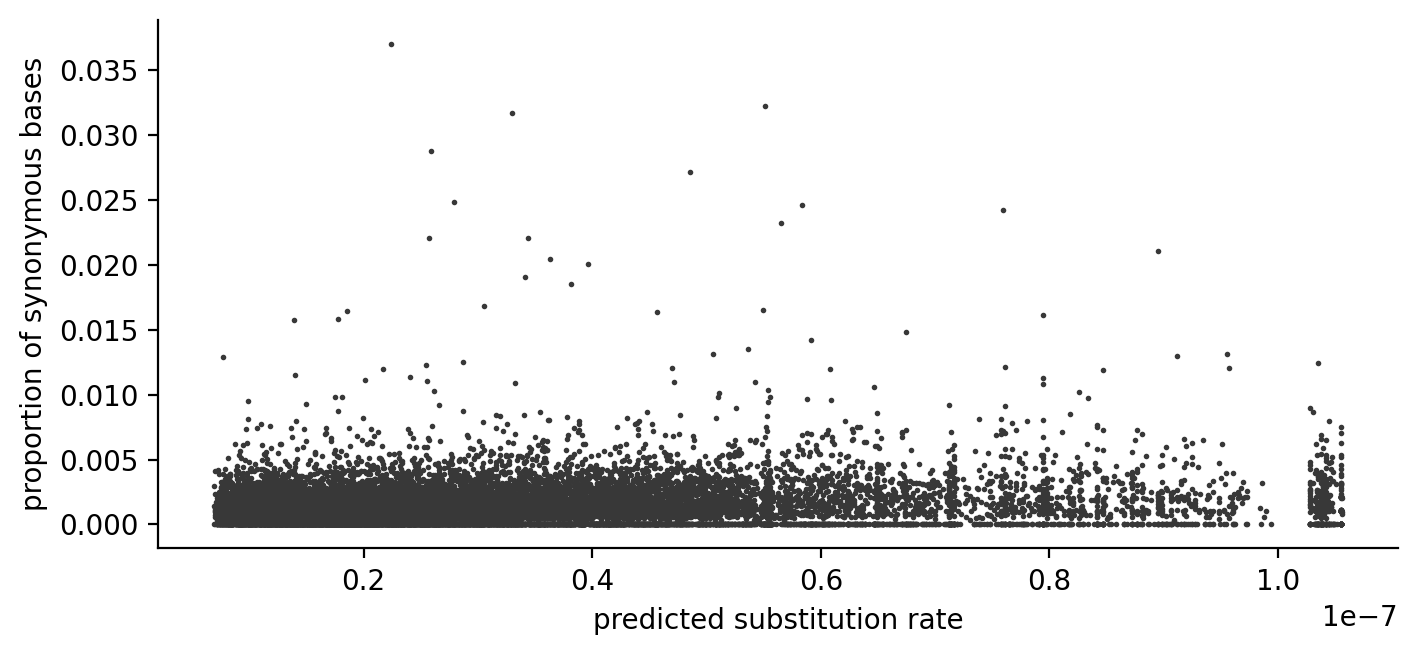

In [470]:
fig, ax = plt.subplots()
ax.scatter(d['r'], d['syn_prop'], c='0.22', s=1, alpha=1)
ax.set_ylabel('proportion of synonymous bases')
ax.set_xlabel('predicted substitution rate')

Text(0.5, 0, 'predicted substitution rate')

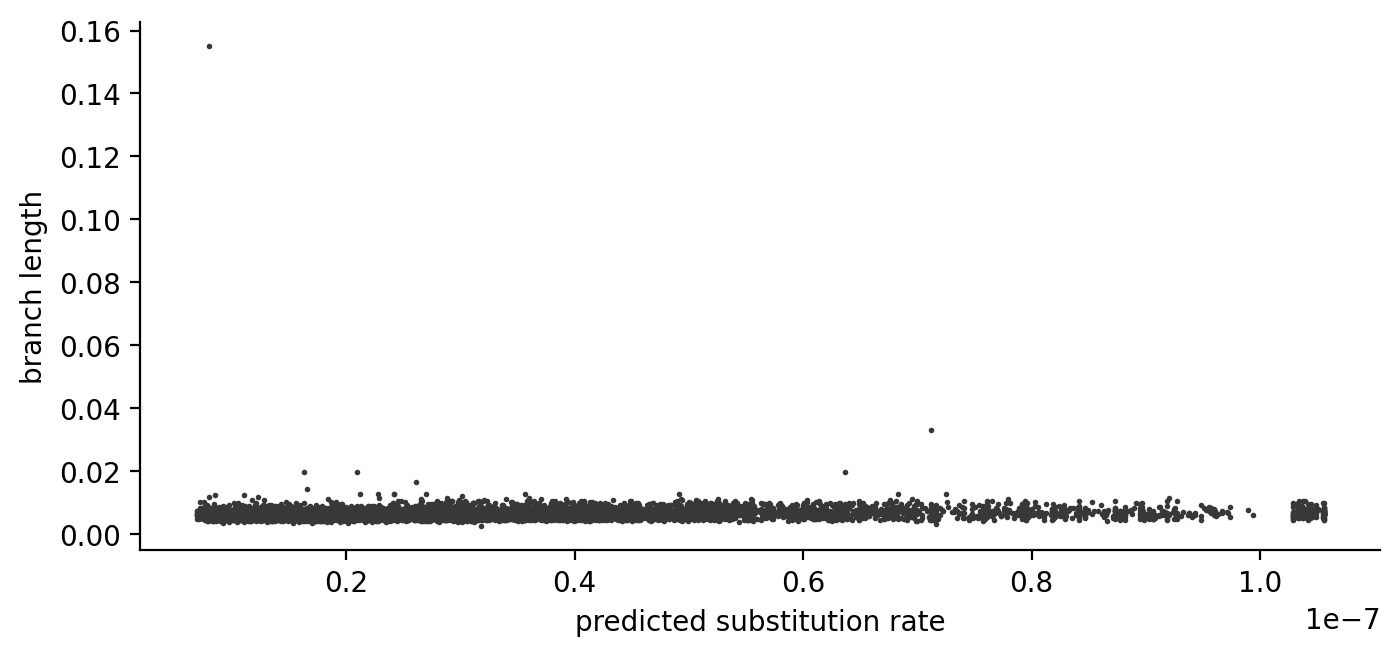

In [471]:
fig, ax = plt.subplots()
ax.scatter(d['r'], d['branch_length'], c='0.22', s=1, alpha=1)
ax.set_ylabel('branch length')
ax.set_xlabel('predicted substitution rate')

Note the strange clump of high predicted substitution rates in both of these figures — what's going on?

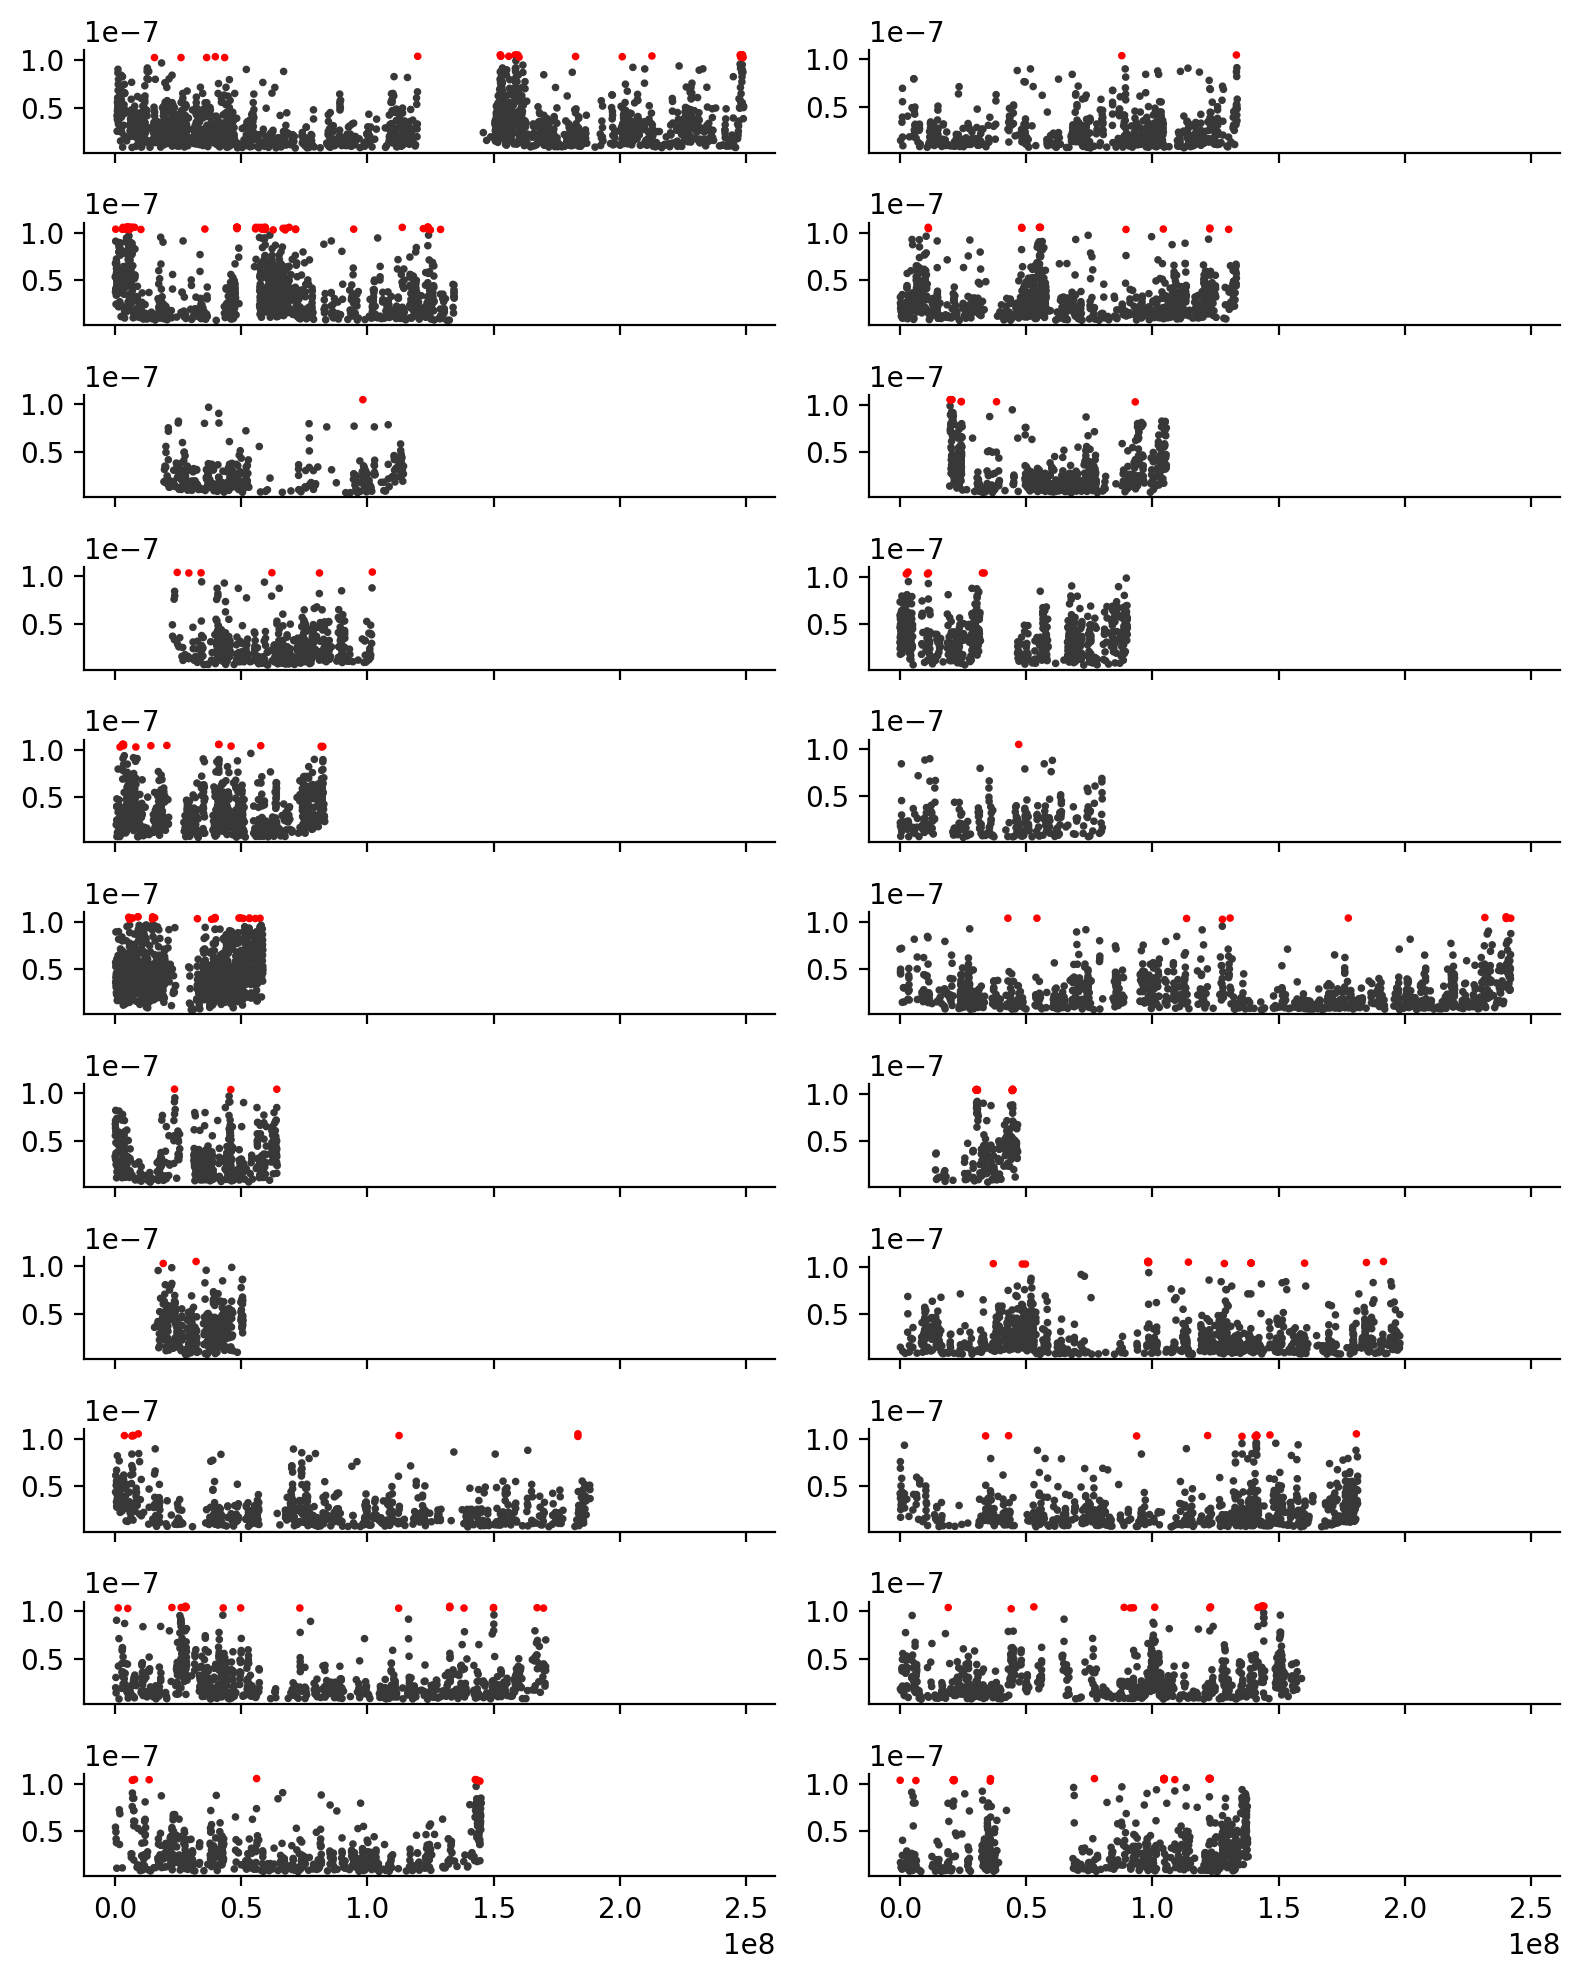

In [472]:
r_thresh = 1e-7

fig, ax = plt.subplots(ncols=2, nrows=11, figsize=(8, 10), sharex=True)

cols, rows = np.meshgrid(np.arange(2), np.arange(11))

for i, chrom in enumerate(d['chrom'].unique()):
    dx = d.loc[d['chrom'] == chrom]
    exclude = dx['r'] > r_thresh
    ax[rows.flat[i], cols.flat[i]].scatter(dx['start'], dx['r'], c=[{True: 'r', False: '0.22'}[x] for x in exclude], s=3)
    
plt.tight_layout()

This looks to be some pathology — we will remove these.

Now let's look at branch length (from PhyloFit) in the Urrichio et al data along the genome. Immediately we see some very strong outliers that we remove.

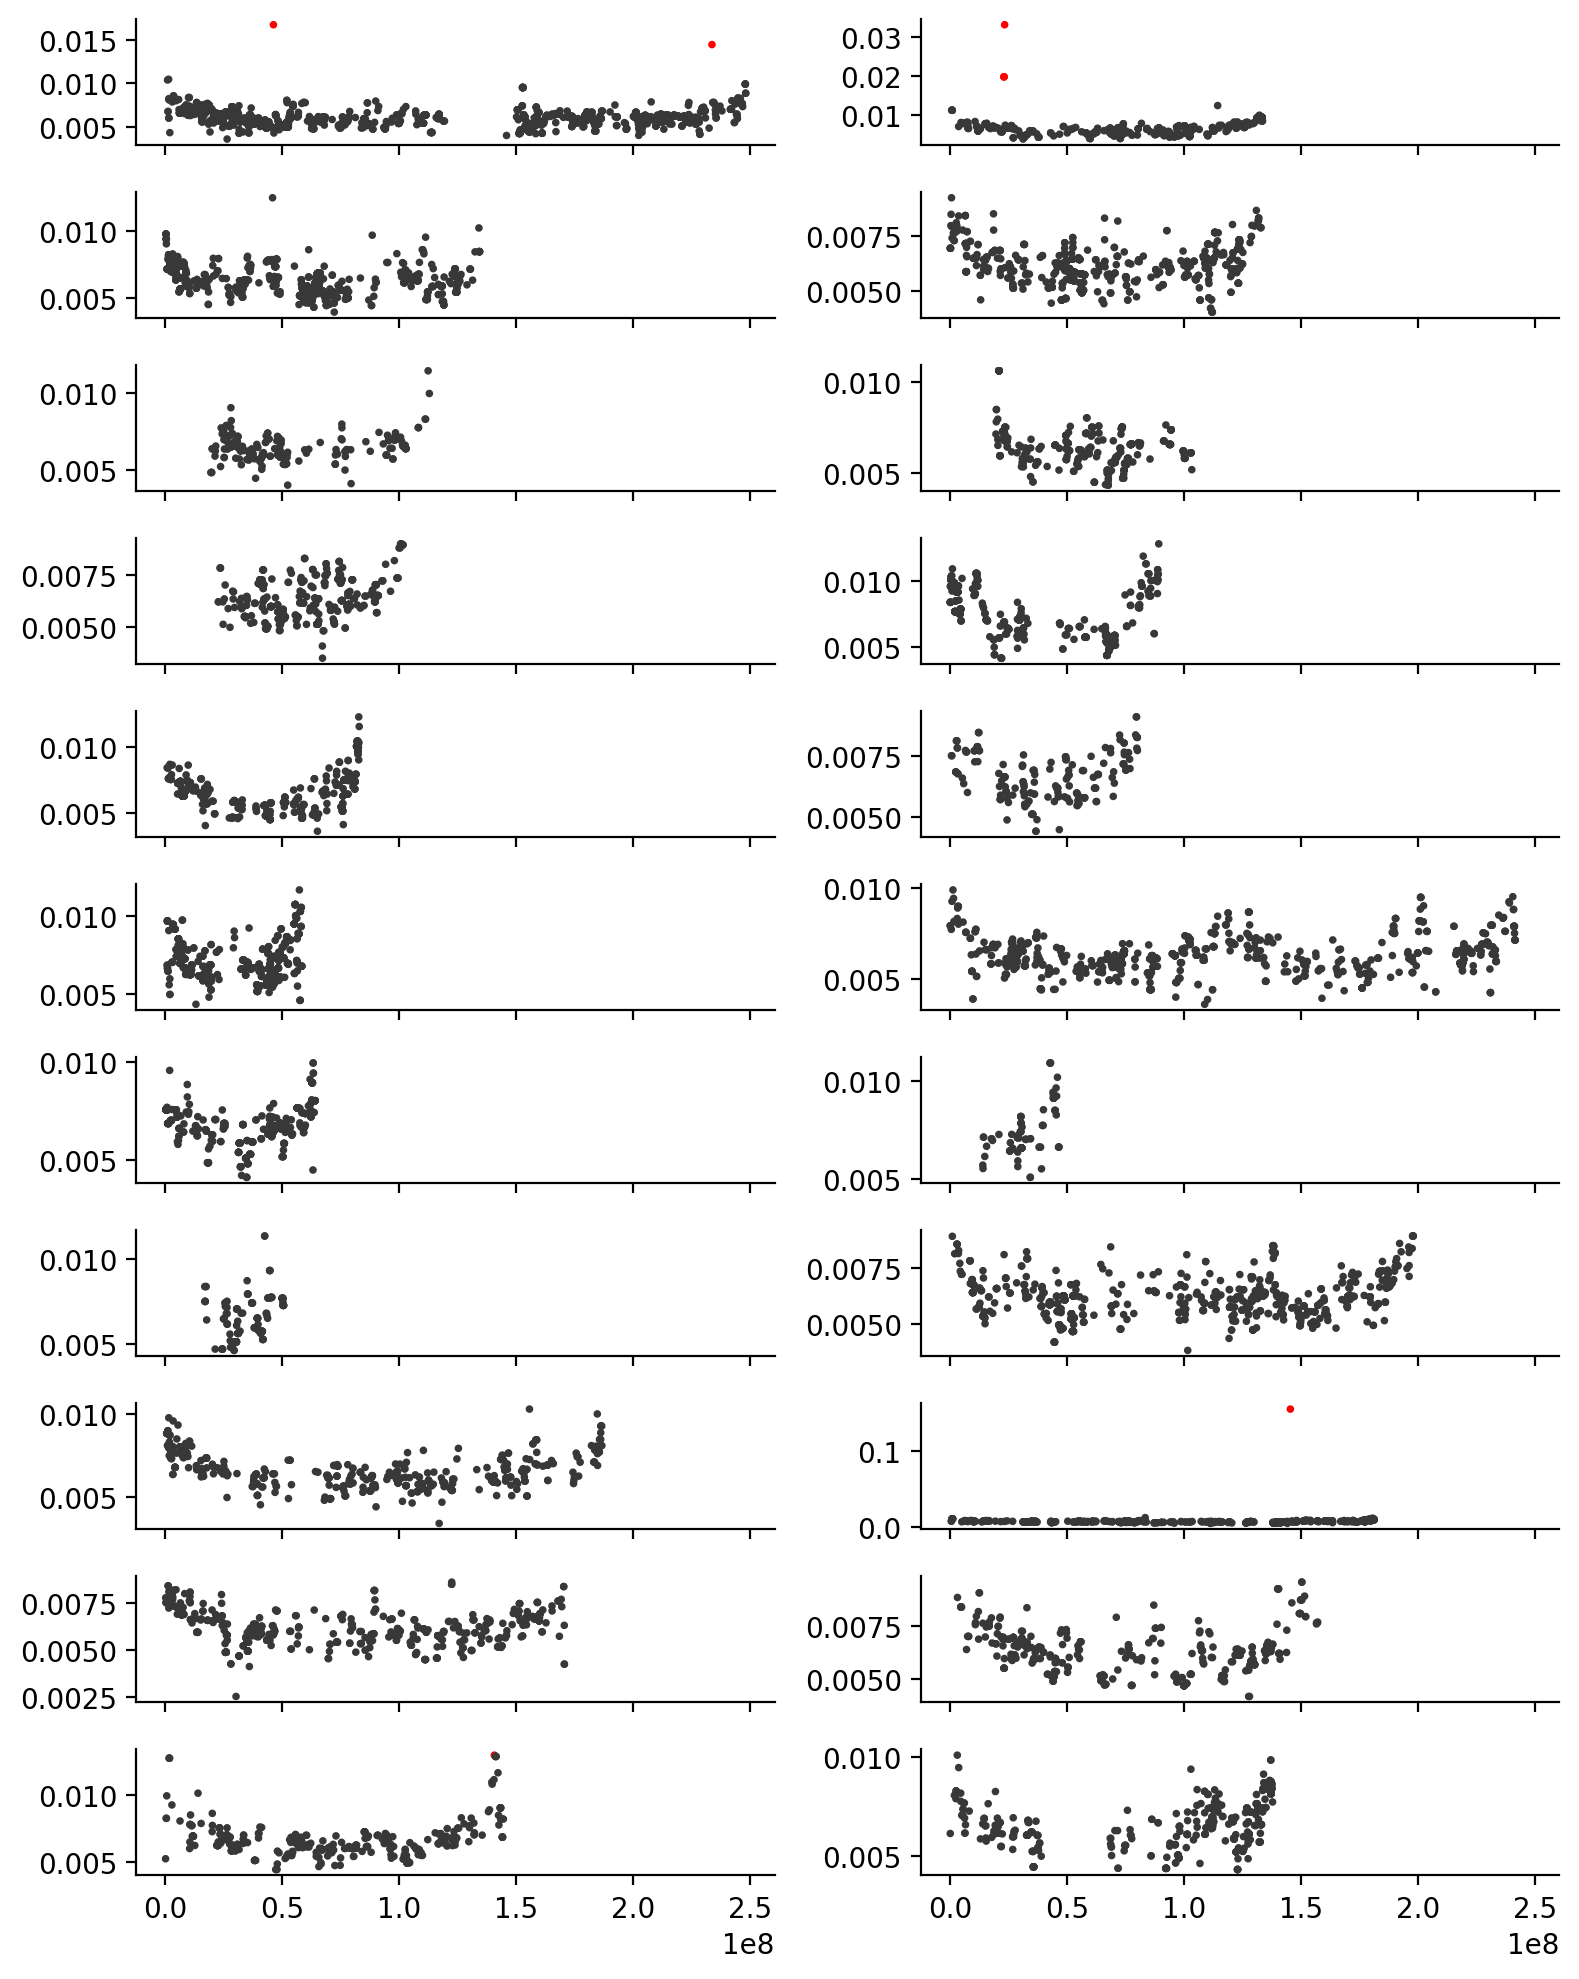

In [473]:
thresh = np.nanquantile(d['branch_length'], 0.999)

fig, ax = plt.subplots(ncols=2, nrows=11, figsize=(8, 10), sharex=True)

cols, rows = np.meshgrid(np.arange(2), np.arange(11))

for i, chrom in enumerate(d['chrom'].unique()):
    dx = d.loc[d['chrom'] == chrom]
    exclude = dx['branch_length'] > thresh
    ax[rows.flat[i], cols.flat[i]].scatter(dx['start'], dx['branch_length'], c=[{True: 'r', False: '0.22'}[x] for x in exclude], s=3)
    
plt.tight_layout()

In [474]:
# remove outliers
do = d.loc[(d['branch_length'] < thresh) & (d['r'] < r_thresh)]

In [475]:
from bgspy.utils import mean_ratio

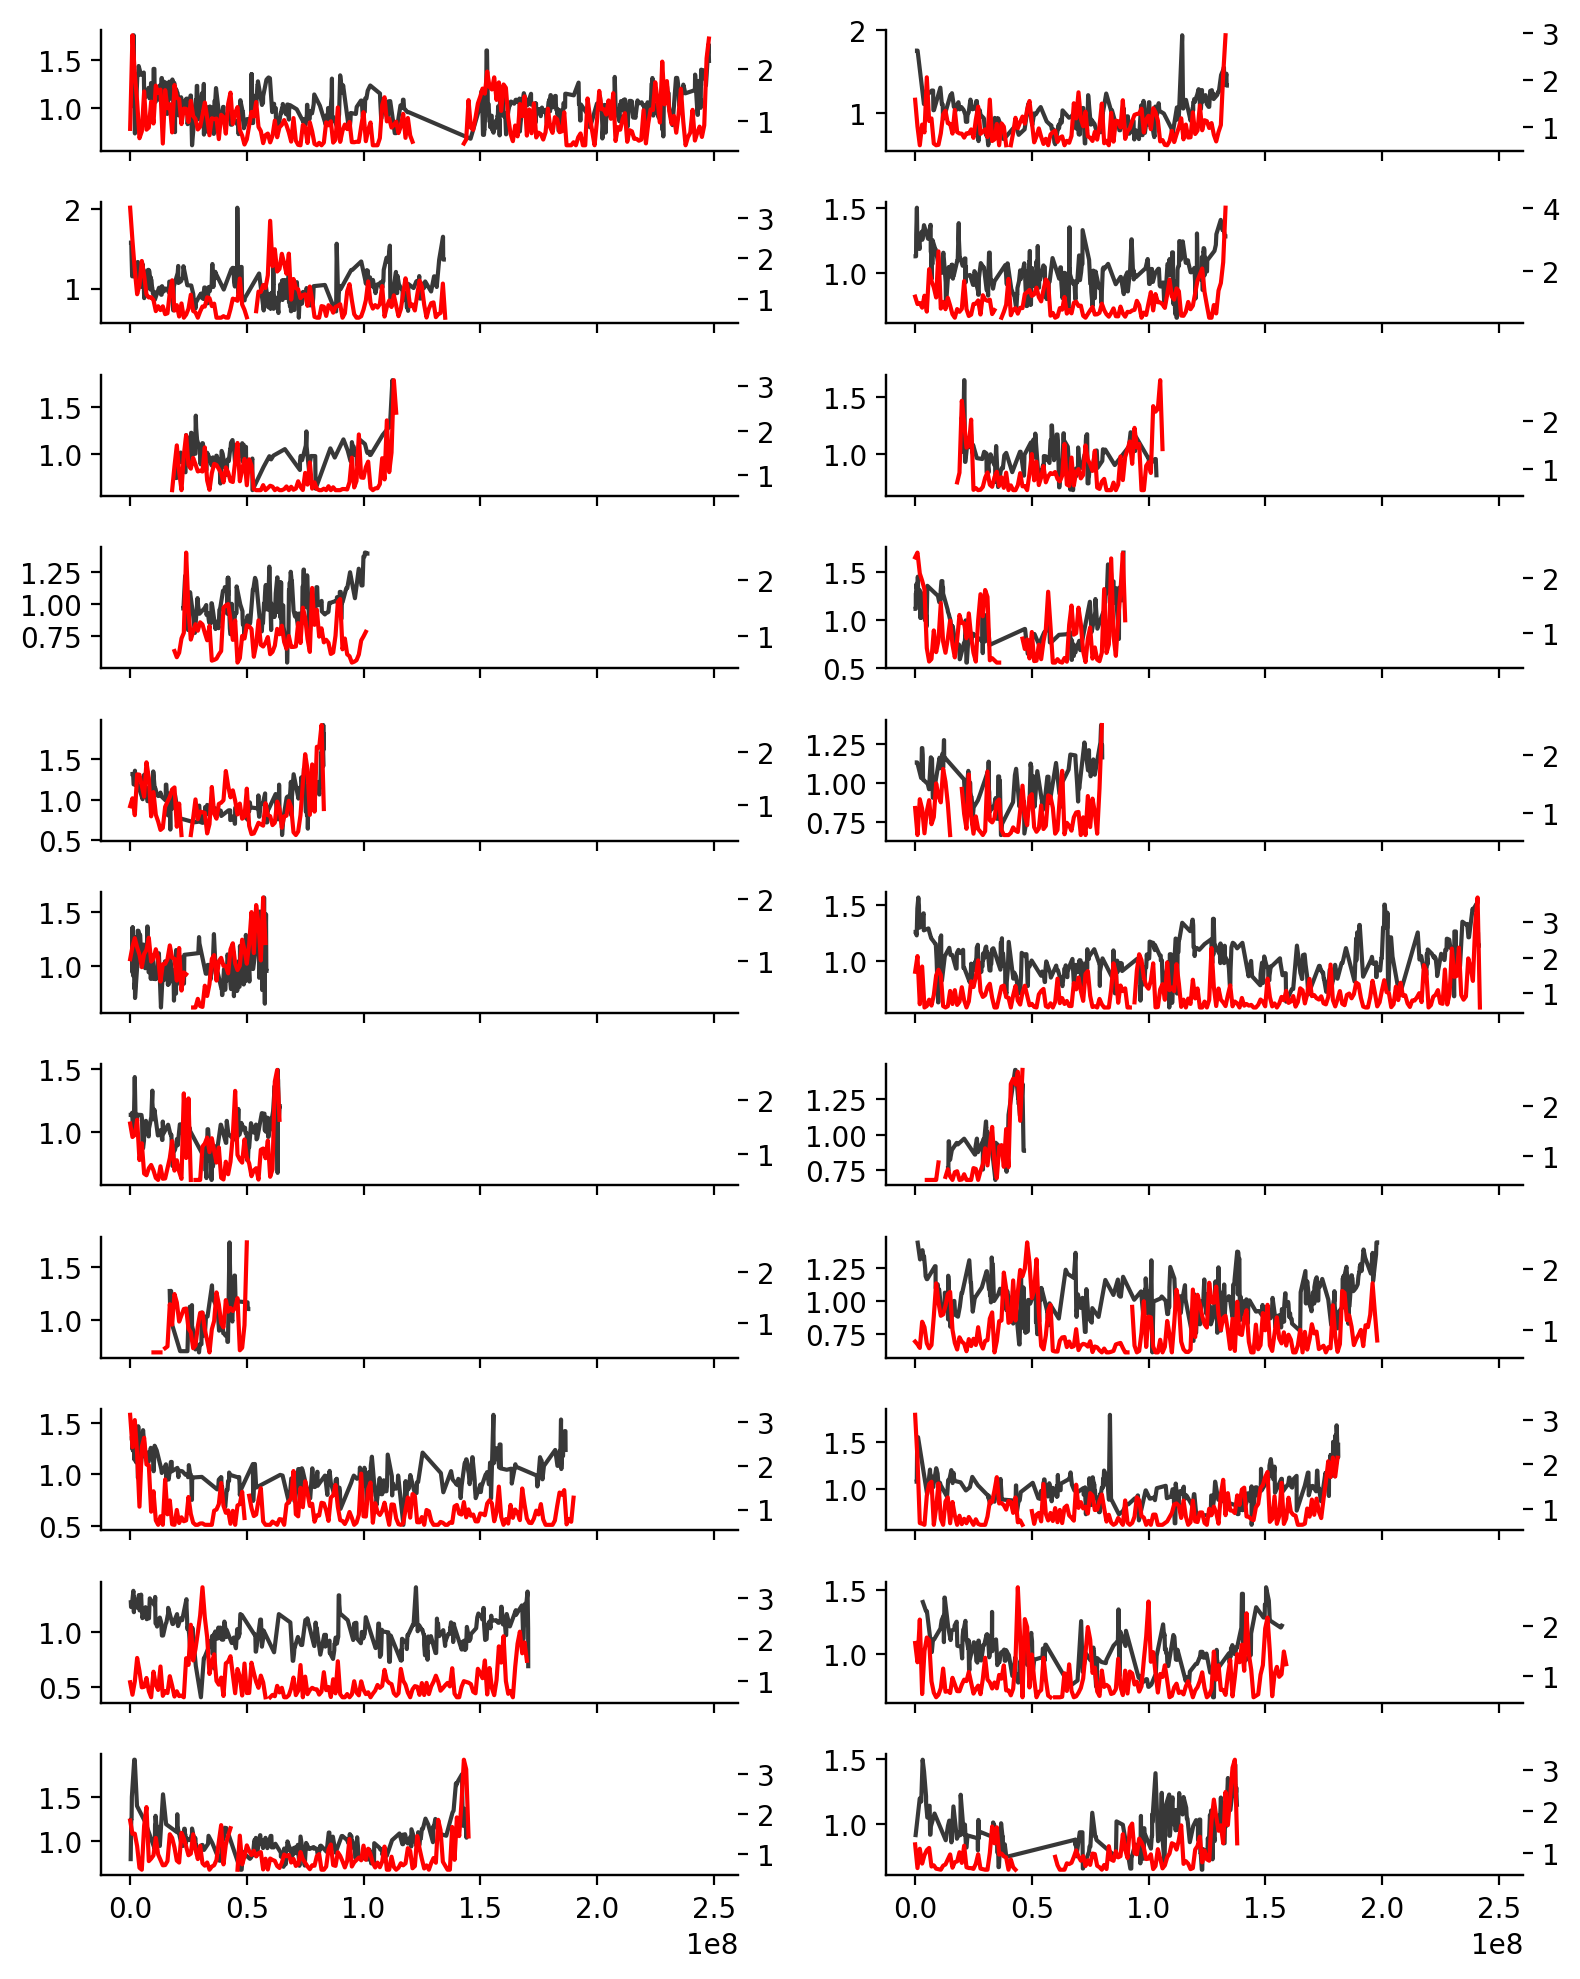

In [476]:
fig, ax = plt.subplots(ncols=2, nrows=11, figsize=(8, 10), sharex=True)

cols, rows = np.meshgrid(np.arange(2), np.arange(11))

for i, chrom in enumerate(do['chrom'].unique()):
    dx = do.loc[do['chrom'] == chrom]
    exclude = dx['branch_length'] > thresh
    fax = ax[rows.flat[i], cols.flat[i]]
    fax.plot(dx['start'], mean_ratio(dx['branch_length']), c='0.22')
    ax2 = fax.twinx()
    
    rx = rd_1Mbp.loc[rd_1Mbp['chrom'] == chrom]
    ax2.plot(rx['start'], mean_ratio(rx['r']), c='r')
    
    #rx = rd2_1Mbp.loc[rd2_1Mbp['chrom'] == chrom]
    #ax2.plot(rx['start'], mean_ratio(rx['r']), c='g', linestyle='dashed')
plt.tight_layout()

There's some rough correpondance here — we will explore this more later.

What about the coefficient of variance?

In [145]:
do['total_prop'].aggregate(lambda x: x.std()/x.mean())

1.0934257168047605

### PhyloFit Branch Length Estimates

The raw phylofit data.

In [31]:
cols = ['chrom', 'start', 'end', 'branch_length', 'bl_nbases']
p = pd.read_csv('../data/phylo/phylofit_rates.bed', sep='\t', na_values='.', names=cols)
p['width'] = p['end'] - p['start']

In [32]:
p.head()

chrom    start      end  branch_length  bl_nbases  width
0  chr1  1059994  1095749       0.010402      72265  35755
1  chr1  1283738  1308299       0.006782      52319  24561
2  chr1  1564773  1623511       0.010483     178850  58738
3  chr1  1626991  1655940       0.006026      63570  28949
4  chr1  1752959  1789083       0.008125      86103  36124

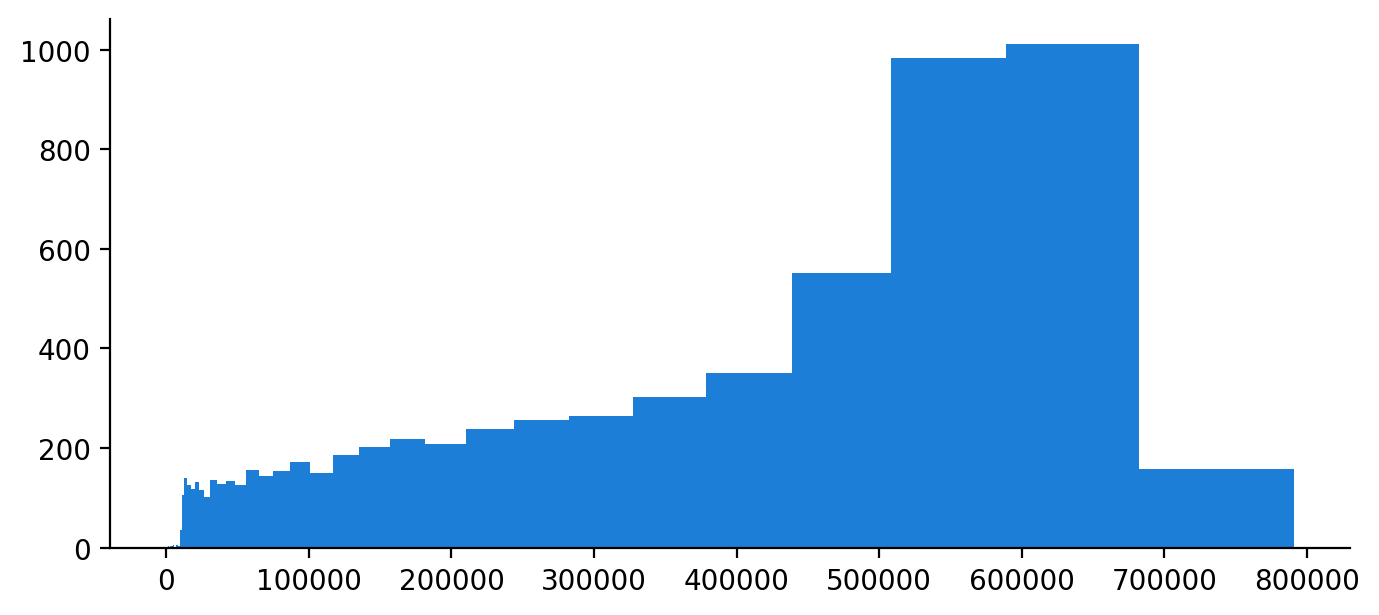

In [33]:
_ = plt.hist(*logbins(p['width'], 60))

[]

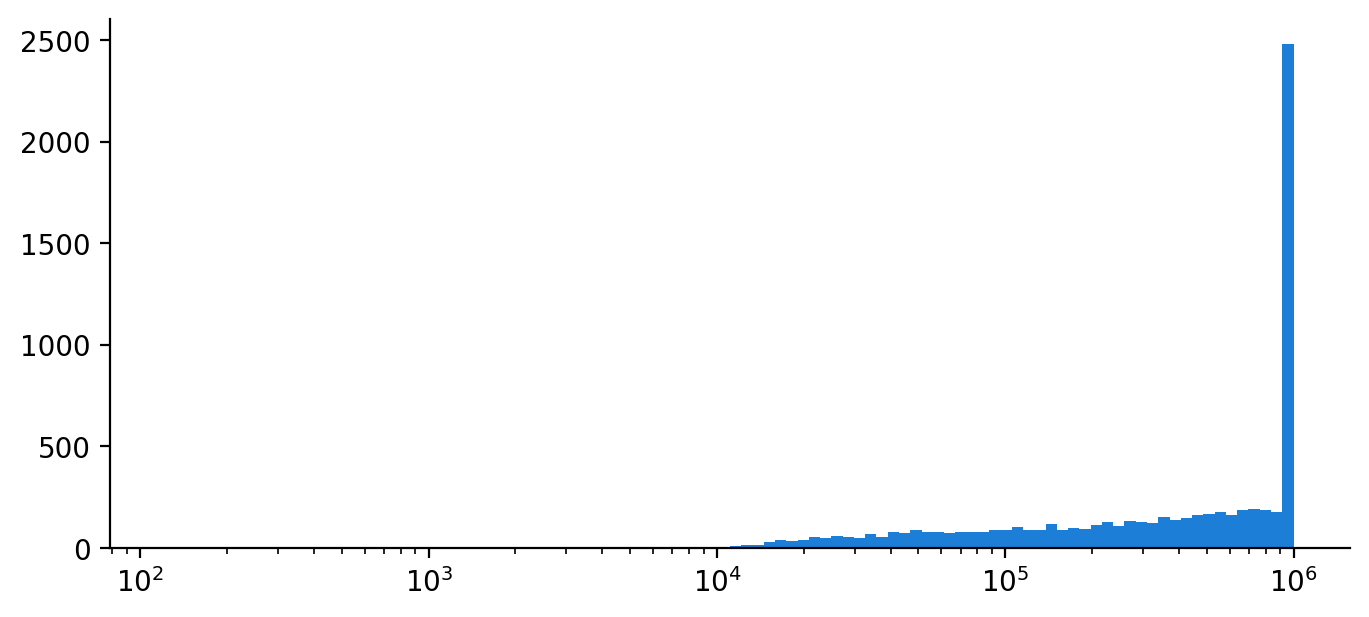

In [34]:
plt.hist(*logbins(p['bl_nbases'], 100))
plt.semilogx()

Esemble's data includes alignments only up to a megabase in length, hence the over-representation of this bin.

In [477]:
p['bl_nbases'].max()

1000000

### Merged Predicted Ratchet Rates and PhyloFit Branch Lengths

In [478]:
# There are two ways to process this. 

dpf2r = pd.read_csv('../data/phylo/phylofit_to_ratchet.bed', sep='\t',
                 na_values='.',
                 names=('chrom', 'start', 'end', 'feature', 'R', 'r', 'r_nbases', 'branch_length'))

dr2pf = pd.read_csv('../data/phylo/ratchet_to_phylofit.bed', sep='\t',
                na_values='.',
                names=('chrom', 'start', 'end', 'branch_length', 'bl_nbases', 'r', 'r_nbases'))

# remove X!
dr2pf = dr2pf.loc[dr2pf['chrom'] != 'chrX']
dpf2r = dpf2r.loc[dpf2r['chrom'] != 'chrX']

dr2pf['width'] = dr2pf['end'] - dr2pf['start']
dpf2r['width'] = dpf2r['end'] - dpf2r['start']

dr2pf.head()                

chrom    start      end  branch_length  bl_nbases             r  r_nbases  \
0  chr1  1059994  1095749       0.010402      72265  1.749256e-08    6851.0   
1  chr1  1283738  1308299       0.006782      52319  4.189097e-08    6842.0   
2  chr1  1564773  1623511       0.010483     178850  3.405017e-08    4785.0   
3  chr1  1626991  1655940       0.006026      63570  4.291974e-08    7670.0   
4  chr1  1752959  1789083       0.008125      86103  5.100077e-08    4842.0   

   width  
0  35755  
1  24561  
2  58738  
3  28949  
4  36124

In [479]:
dpf2r.head()                

chrom  start    end    feature             R             r  r_nbases  \
0  chr1  12007  12020  phastcons  6.089190e-08  4.683992e-09        13   
1  chr1  12021  12035  phastcons  6.557600e-08  4.684000e-09        14   
2  chr1  12039  12050  phastcons  5.152374e-08  4.683976e-09        11   
3  chr1  12065  12085  phastcons  9.368092e-08  4.684046e-09        20   
4  chr1  12176  12194  phastcons  8.431255e-08  4.684031e-09        18   

   branch_length  width  
0            NaN     13  
1            NaN     14  
2            NaN     11  
3            NaN     20  
4            NaN     18

In [480]:
dr2pf['width'].mean(), dpf2r['width'].mean()

(317343.5023070804, 25.712625147439514)

In [481]:
dpf2r_pc['r'].mean()

6.6760465798923424e-09

(array([19087., 36392., 44153., 35872., 18926.,  8090.,  2229.,   966.,
          743.,    47.]),
 array([3.77395139e-09, 3.78260195e-09, 3.79125252e-09, 3.79990308e-09,
        3.80855365e-09, 3.81720422e-09, 3.82585478e-09, 3.83450535e-09,
        3.84315591e-09, 3.85180648e-09, 3.86045704e-09]),
 <BarContainer object of 10 artists>)

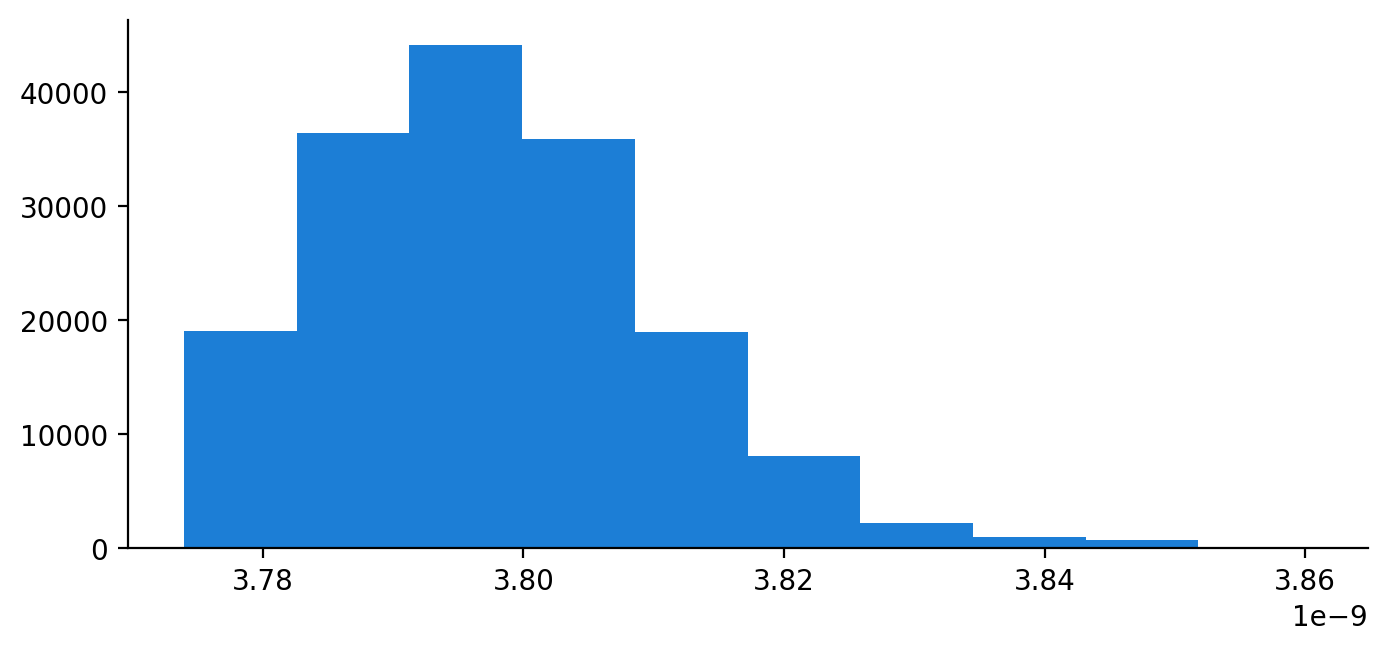

In [482]:
dpf2r_cds = dpf2r.loc[dpf2r['feature'] == 'cds']
dpf2r_utr = dpf2r.loc[dpf2r['feature'] == 'utr']
dpf2r_pc = dpf2r.loc[dpf2r['feature'] == 'phastcons']

plt.hist(dpf2r_cds['r'])

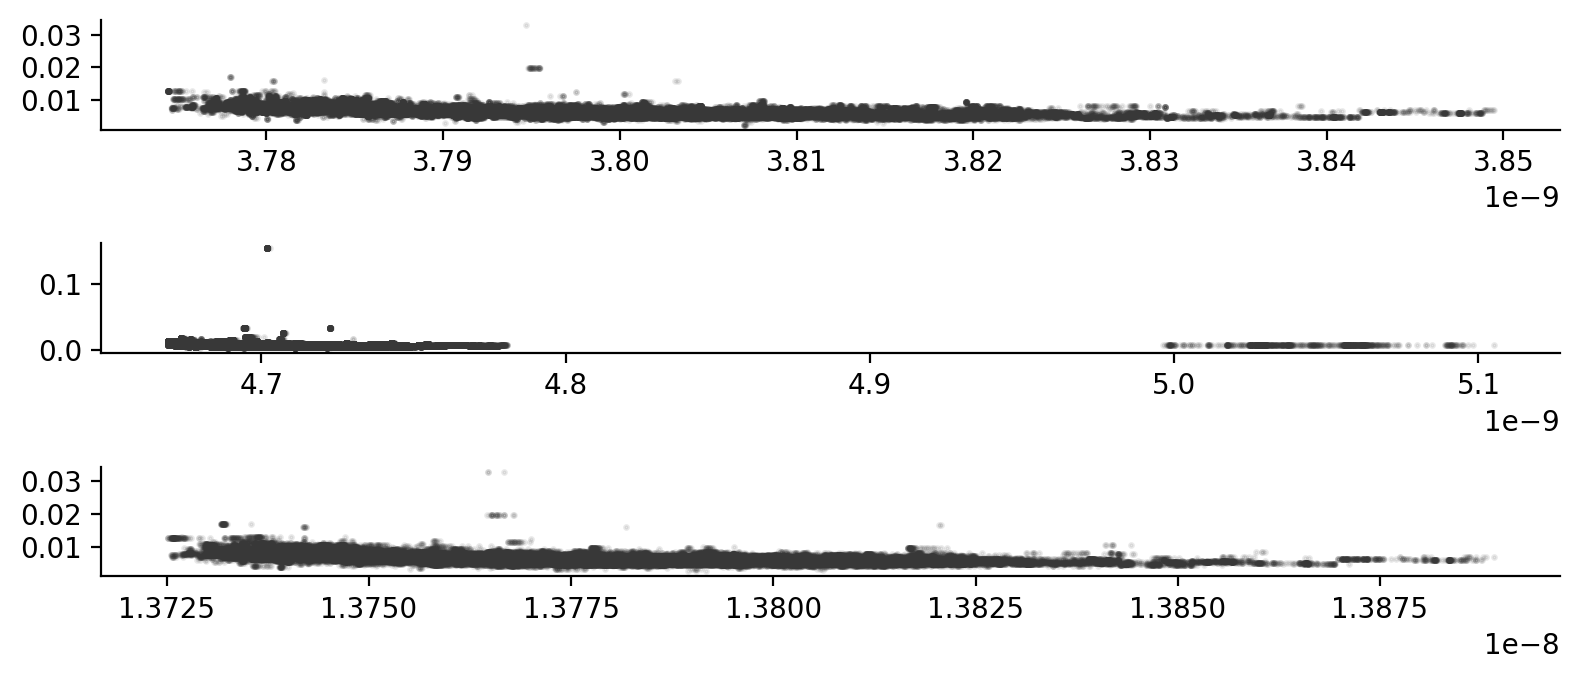

In [483]:
fig, ax = plt.subplots(nrows=3)
ax[0].scatter(dpf2r_cds['r'], dpf2r_cds['branch_length'], c='0.22', s=2, alpha=0.1)
ax[1].scatter(dpf2r_pc['r'], dpf2r_pc['branch_length'], c='0.22', s=2, alpha=0.1)
ax[2].scatter(dpf2r_utr['r'], dpf2r_utr['branch_length'], c='0.22', s=2, alpha=0.1)
plt.tight_layout()

Note the difference between these files:

 - Ratchet to phylofit averages multiple ratchet estimtaes per aligned region. This averages different types of features too. 
 - Phylotfit to ratchet averages the substitution rates by what the predicted ratchet rate is. Note that since the ratchet rate differs a lot by the feature type.
 
 
We can see the phylofit to ratchet substitution rate variation by feature type below, each cluster is one set of features.

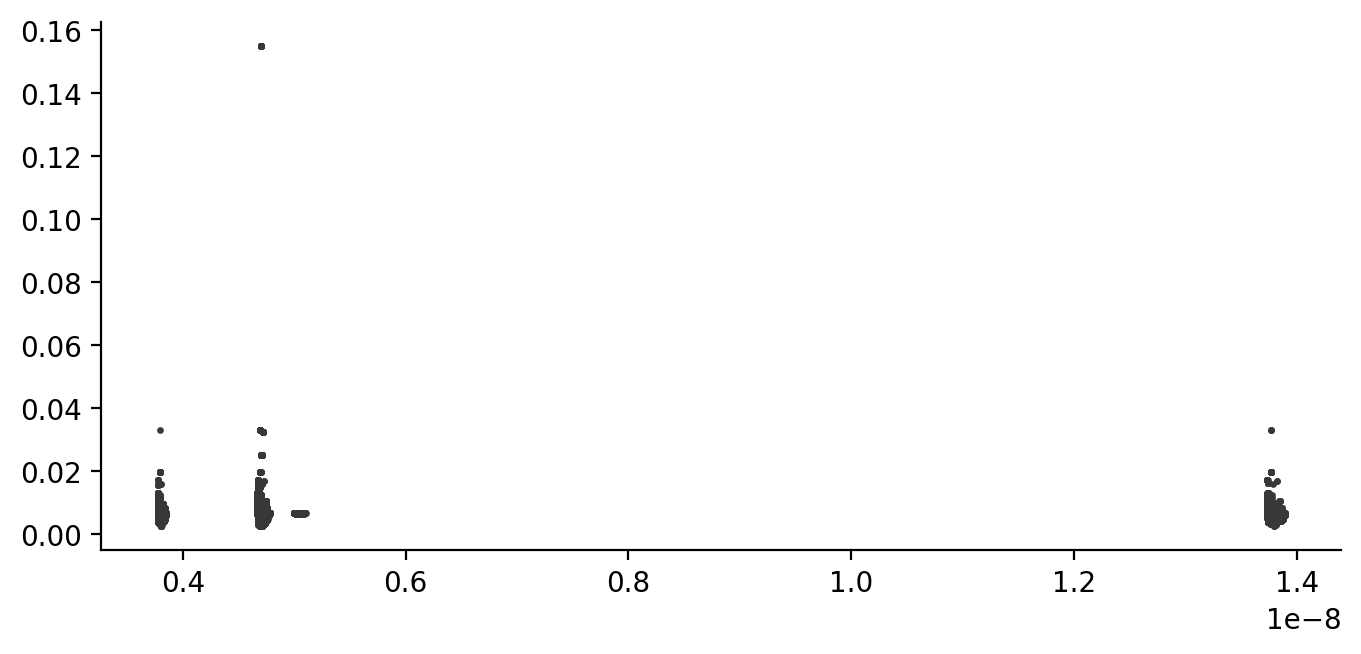

In [484]:
plt.scatter(dpf2r['r'], dpf2r['branch_length'], c='0.22', s=2)

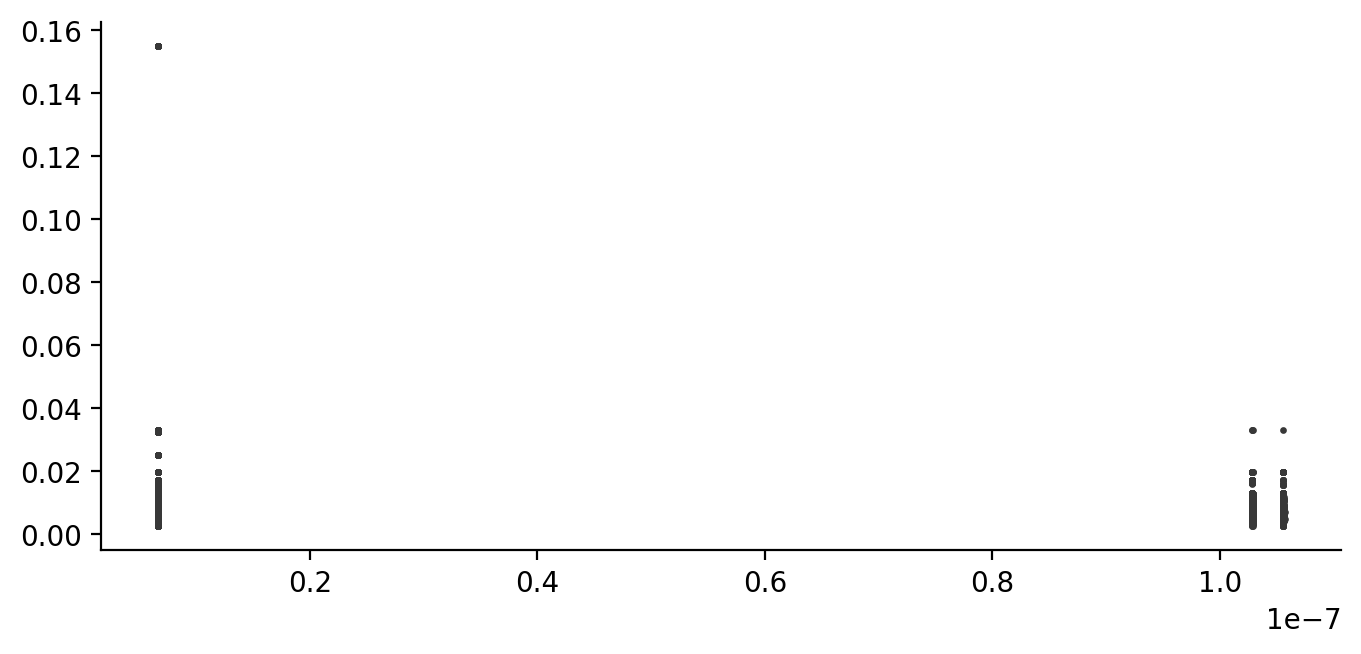

In [40]:
plt.scatter(dpf2r['r'], dpf2r['branch_length'], c='0.22', s=2)

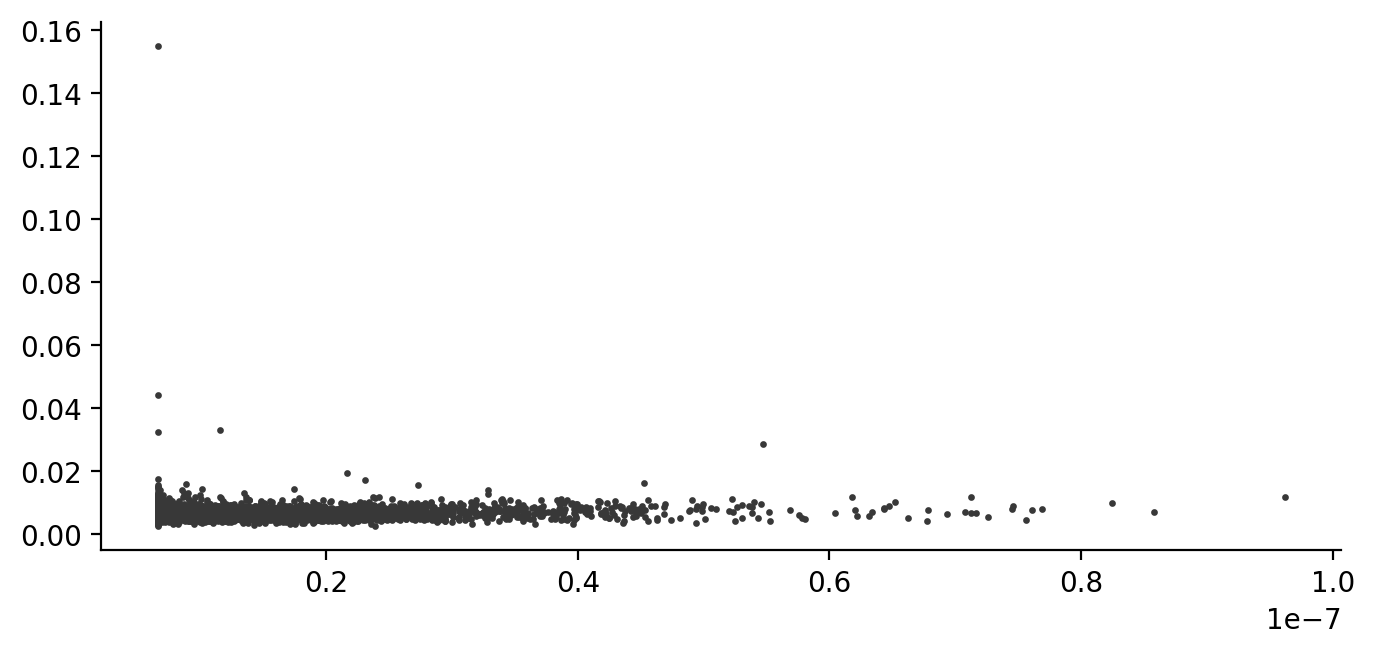

In [173]:
plt.scatter(dr2pf['r'], dr2pf['branch_length'], c='0.22', s=2)

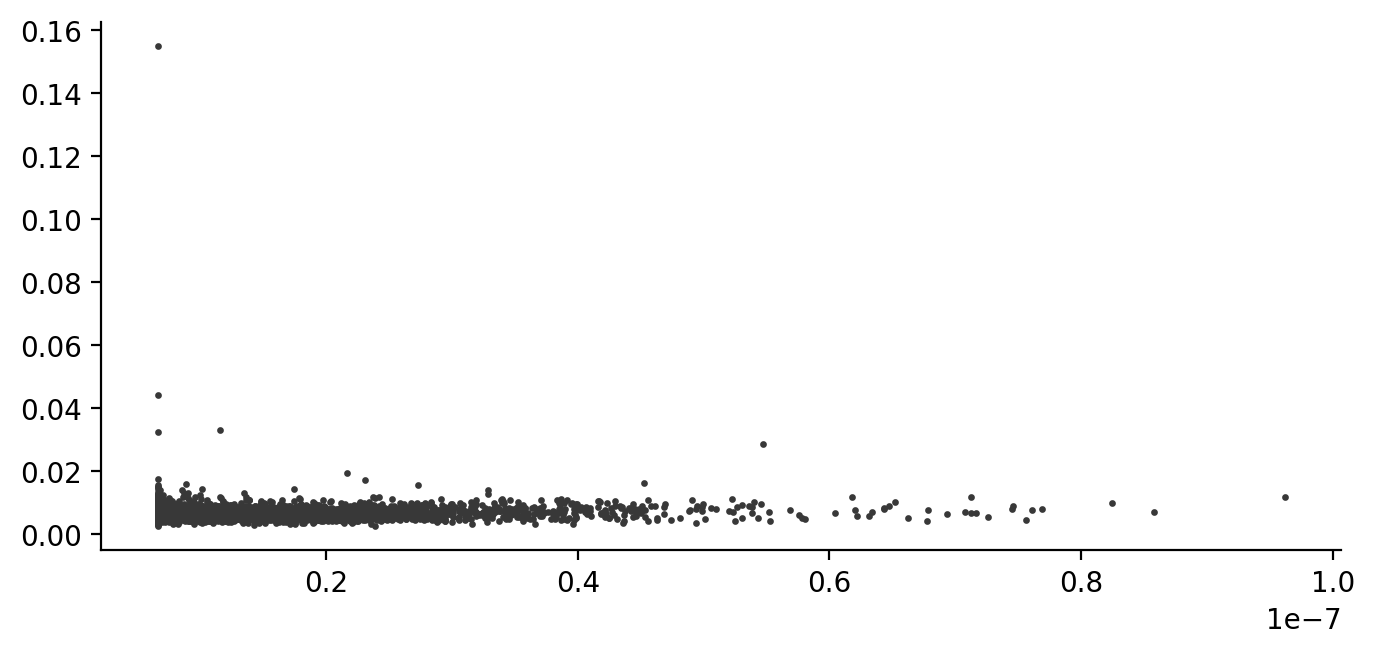

In [41]:
plt.scatter(dr2pf['r'], dr2pf['branch_length'], c='0.22', s=2)

There look to be a few outliers.

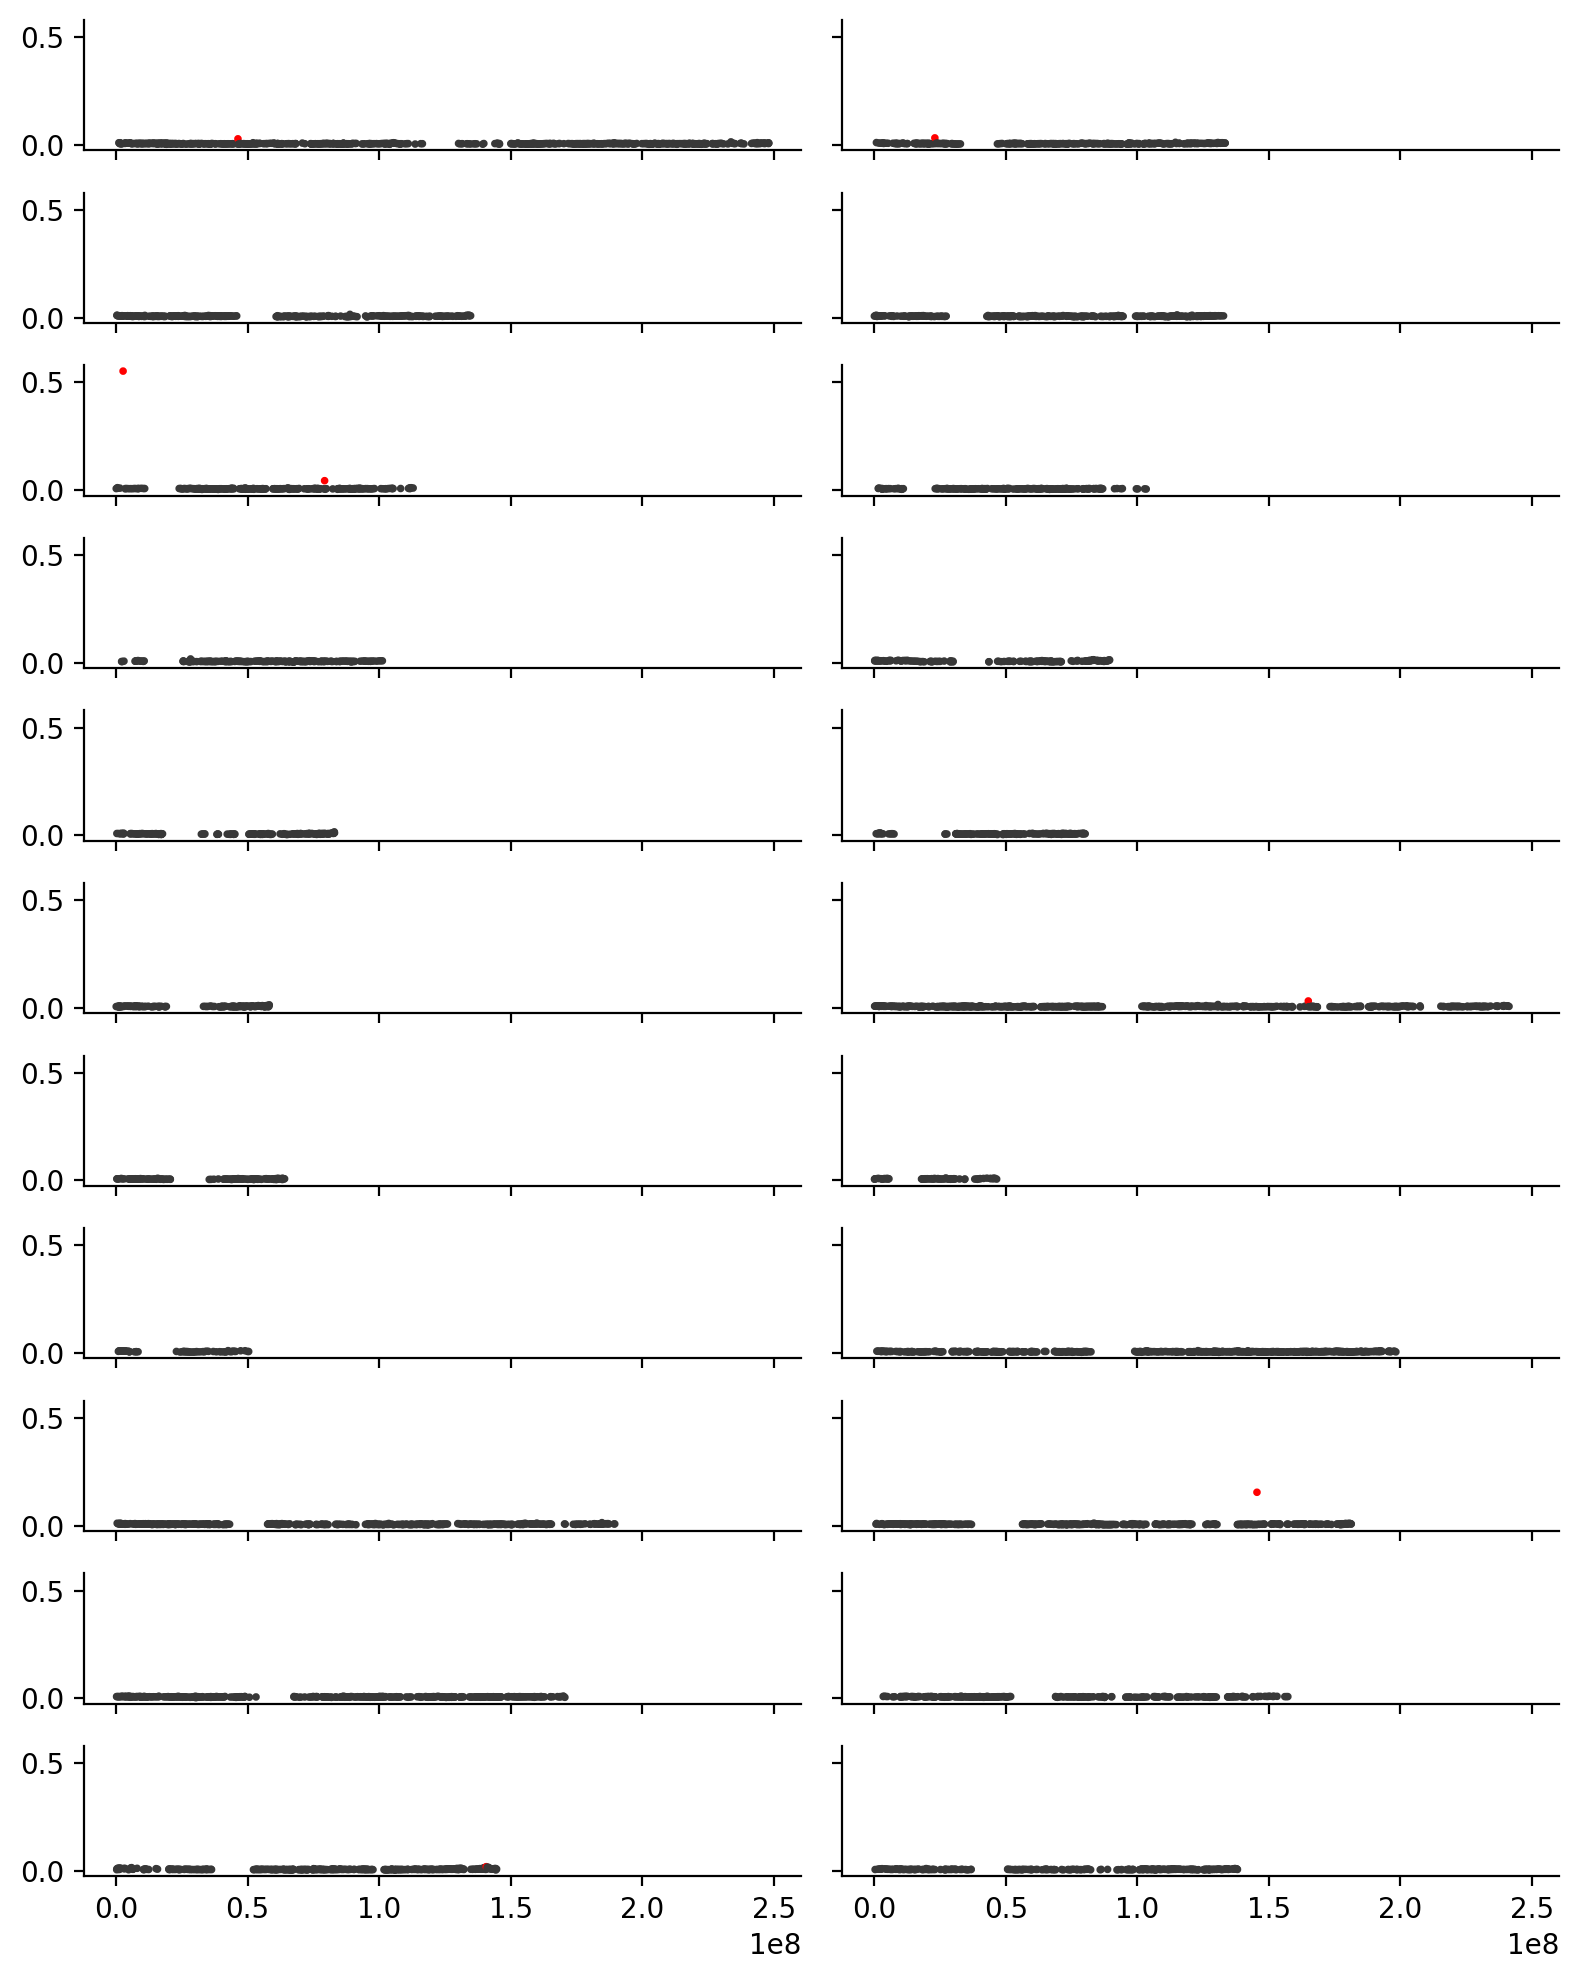

In [174]:
r2pf_thresh = np.nanquantile(dr2pf['branch_length'], 0.999)

fig, ax = plt.subplots(ncols=2, nrows=11, figsize=(8, 10), sharex=True, sharey=True)

cols, rows = np.meshgrid(np.arange(2), np.arange(11))

for i, chrom in enumerate(dr2pf['chrom'].unique()):
    dx = dr2pf.loc[dr2pf['chrom'] == chrom]
    exclude = dx['branch_length'] > r2pf_thresh
    ax[rows.flat[i], cols.flat[i]].scatter(dx['start'], dx['branch_length'], c=[{True: 'r', False: '0.22'}[x] for x in exclude], s=3)
    
plt.tight_layout()

In [216]:
dr2pfo = dr2pf.loc[dr2pf['branch_length'] < r2pf_thresh]

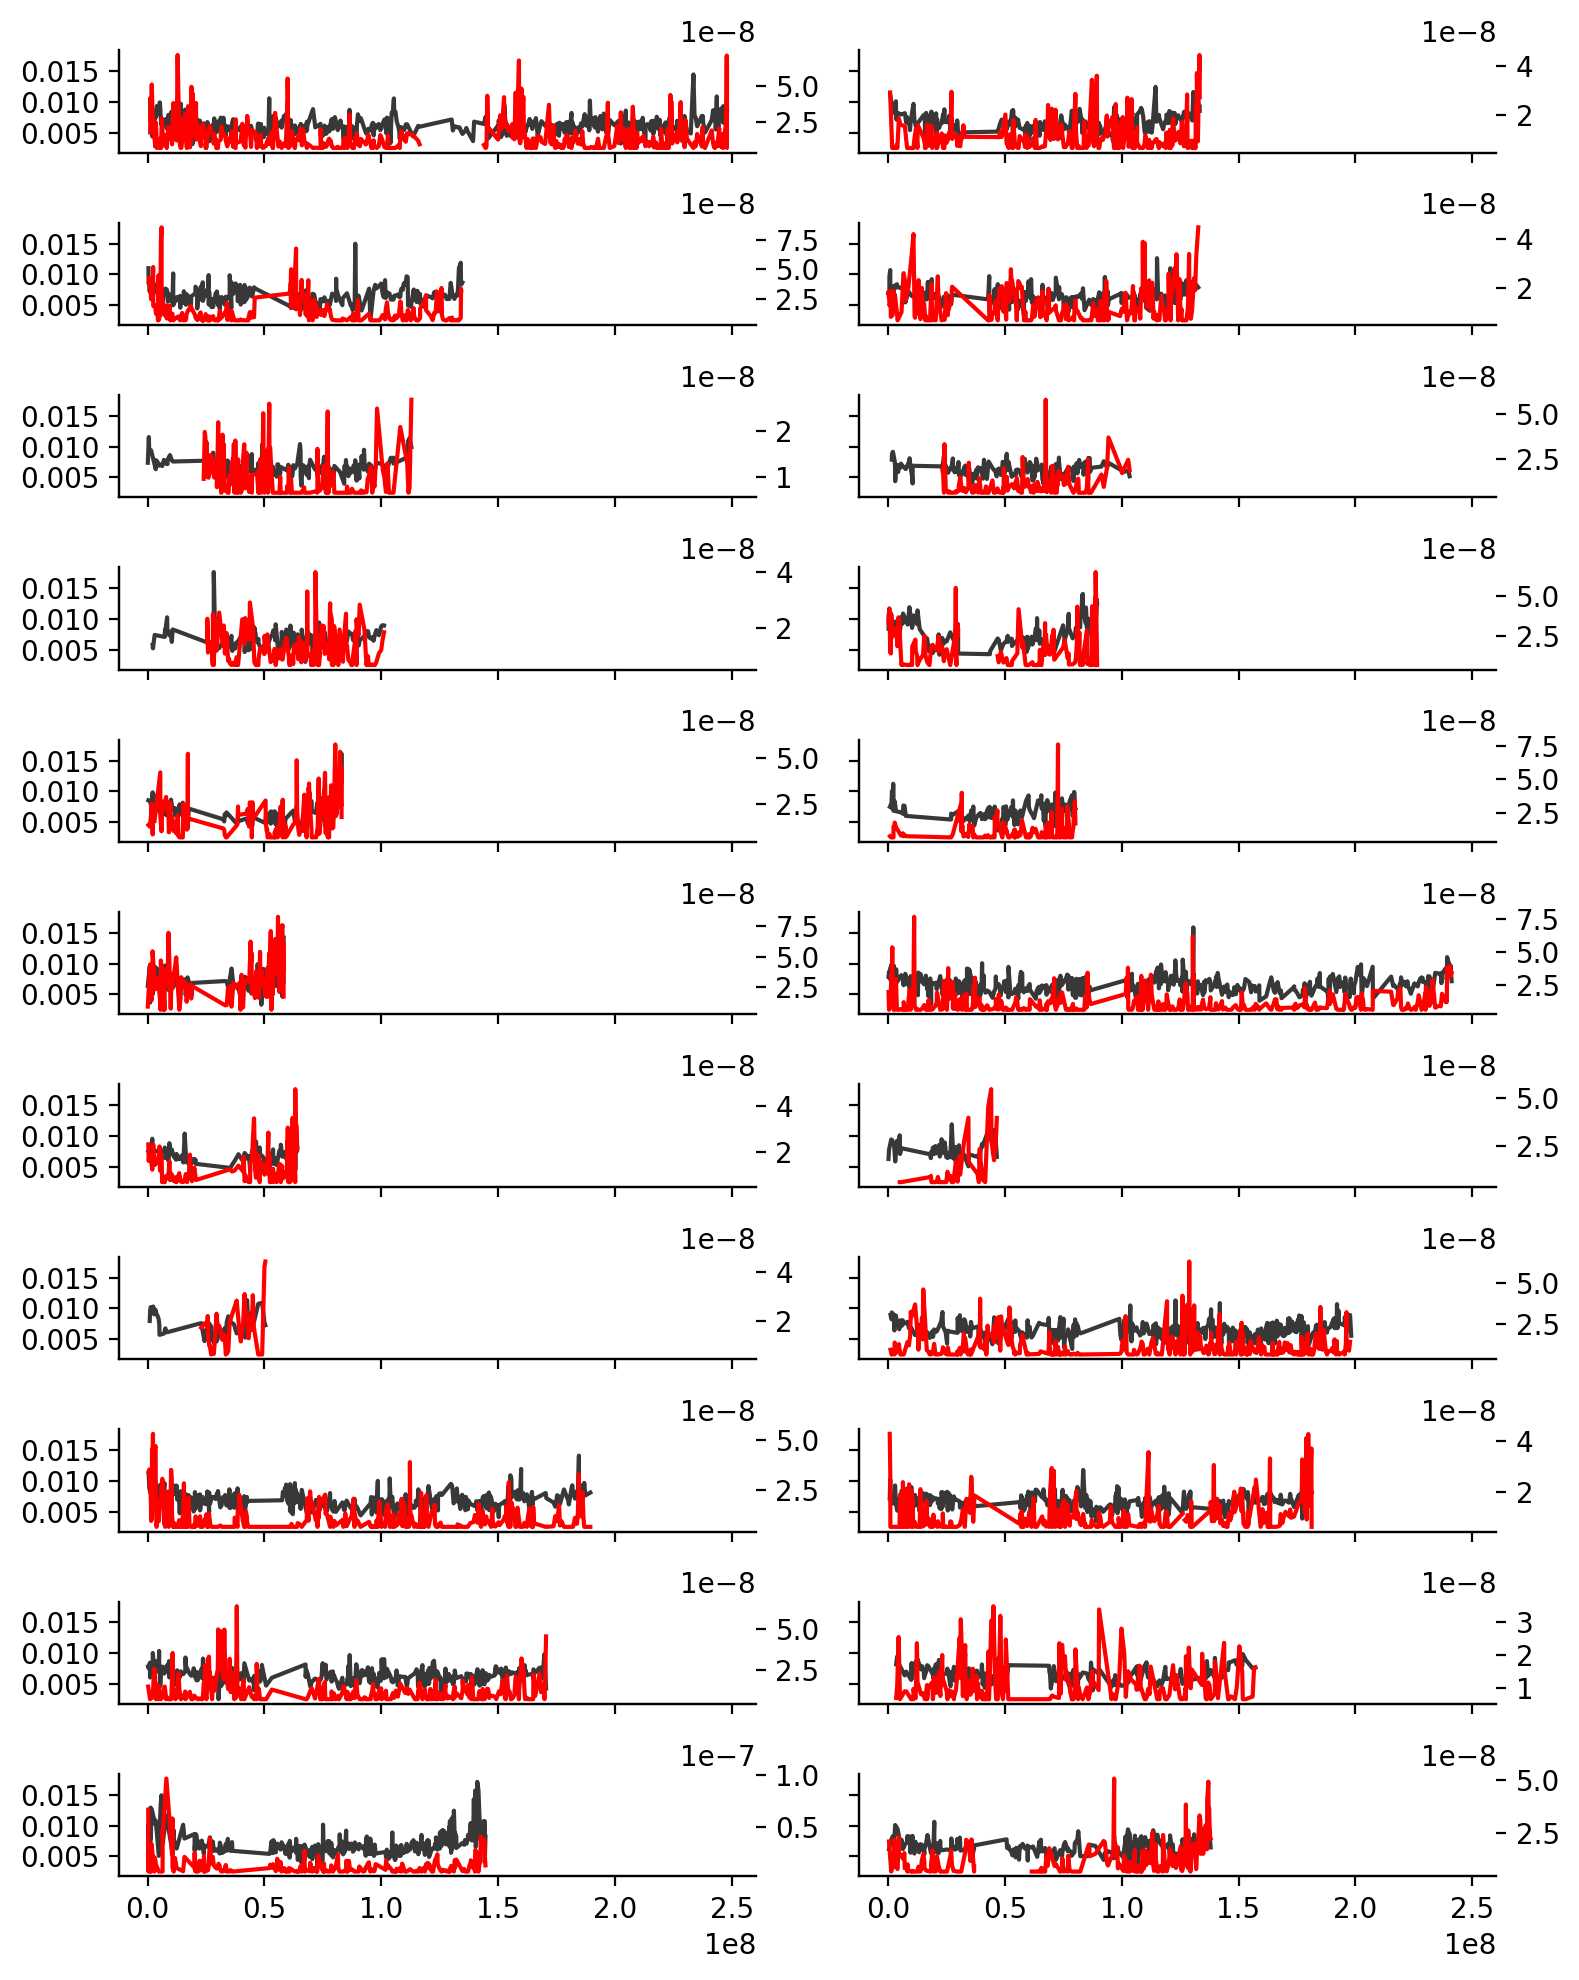

In [44]:
fig, ax = plt.subplots(ncols=2, nrows=11, figsize=(8, 10), sharex=True, sharey=True)

cols, rows = np.meshgrid(np.arange(2), np.arange(11))

for i, chrom in enumerate(dr2pfo['chrom'].unique()):
    dx = dr2pfo.loc[dr2pf['chrom'] == chrom]
    exclude = dx['branch_length'] > r2pf_thresh
    fax = ax[rows.flat[i], cols.flat[i]]
    fax.plot(dx['start'], dx['branch_length'], c='0.22')
    ax2 = fax.twinx()
    ax2.plot(dx['start'], dx['r'], c='r')
plt.tight_layout()

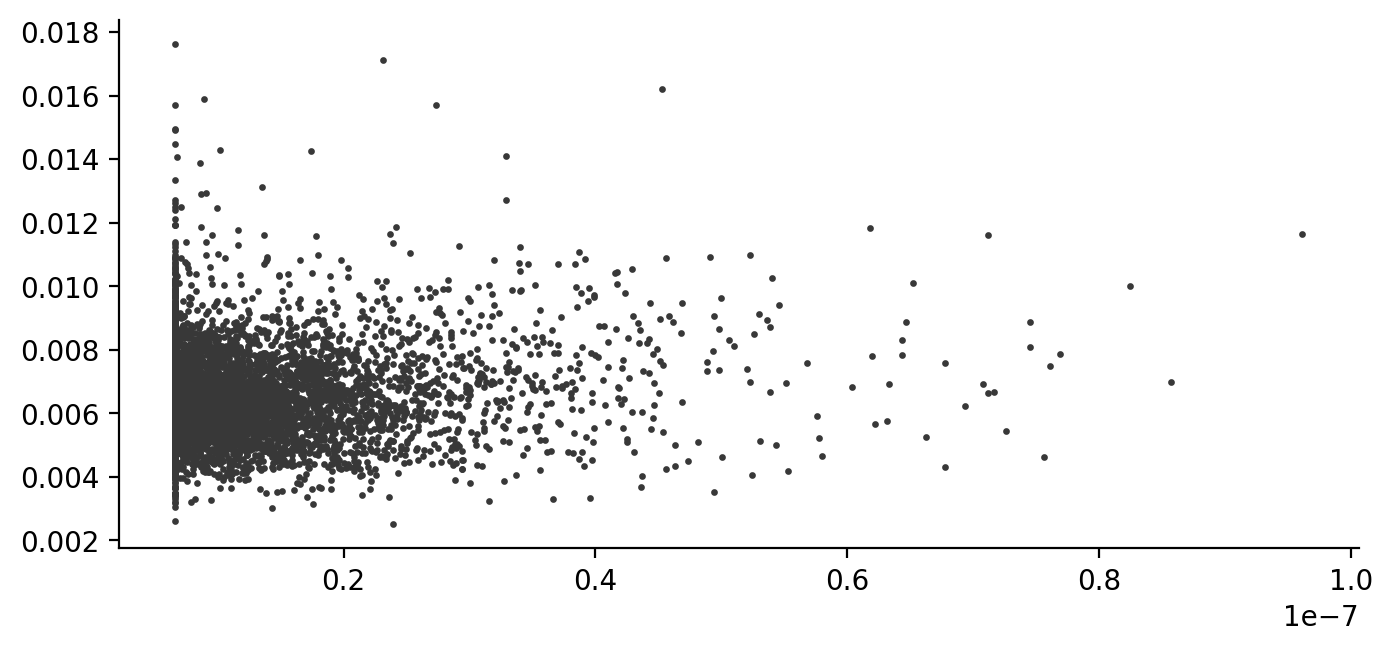

In [175]:
plt.scatter(dr2pfo['r'], dr2pfo['branch_length'], c='0.22', s=2)

### Binned Ratchet Rates (Megabase)

In [485]:
cols = ('chrom', 'start', 'end', 'R', 'r', 'r_bases')
r1Mb = pd.read_csv('../data/phylo/ratchet_rates_binned_1000000.bed', names=cols,
                   na_values='.', sep='\t')

## Substitution Non-Parametric and Parametric Models

In [486]:
do.head()

chrom    start      end          gene_id  n_nonsyn  n_syn  fixed_nonsyn  \
8   chr1  1081818  1116361  ENSG00000131591         3      4             4   
14  chr1  1280436  1292029  ENSG00000162572        50     25             5   
15  chr1  1292390  1309609  ENSG00000131584         8     19             1   
30  chr1  1541673  1574863  ENSG00000160075         0      1             1   
31  chr1  1615454  1630605  ENSG00000197530         6      1             1   

    fixed_syn      dnDs  total_fixed  ...      dNdS             r  r_nbases  \
8           1  4.000000            5  ...  4.000000  6.030245e-08      4854   
14          2  2.500000            7  ...  2.500000  6.809901e-08      4060   
15          2  0.500000            3  ...  0.500000  3.650121e-08      4878   
30          0       inf            1  ...       inf  4.495916e-08      5548   
31          6  0.166667            7  ...  0.166667  4.422908e-08      4648   

            r_rs  r_rs_nbases  branch_length  bl_nbases  width   midpoint  \
8   8.891611e-09         4854       0.010402    72265.0  34543  1099089.5   
14  8.733494e-09         4060       0.006782    52319.0  11593  1286232.5   
15  5.509624e-09         4878       0.006782    52319.0  17219  1300999.5   
30  6.953798e-09         5548       0.010483   178850.0  33190  1558268.0   
31  7.519620e-09         4648       0.008255   242420.0  15151  1623029.5   

           B  
8   0.816692  
14  0.814506  
15  0.814375  
30  0.813051  
31  0.813006  

[5 rows x 27 columns]

In [487]:
x, x_rs, nonsyn_prop, syn_prop, branch_length = do['r'], do['r_rs'], do['nonsyn_prop'], do['syn_prop'], do['branch_length']
b = do['B']

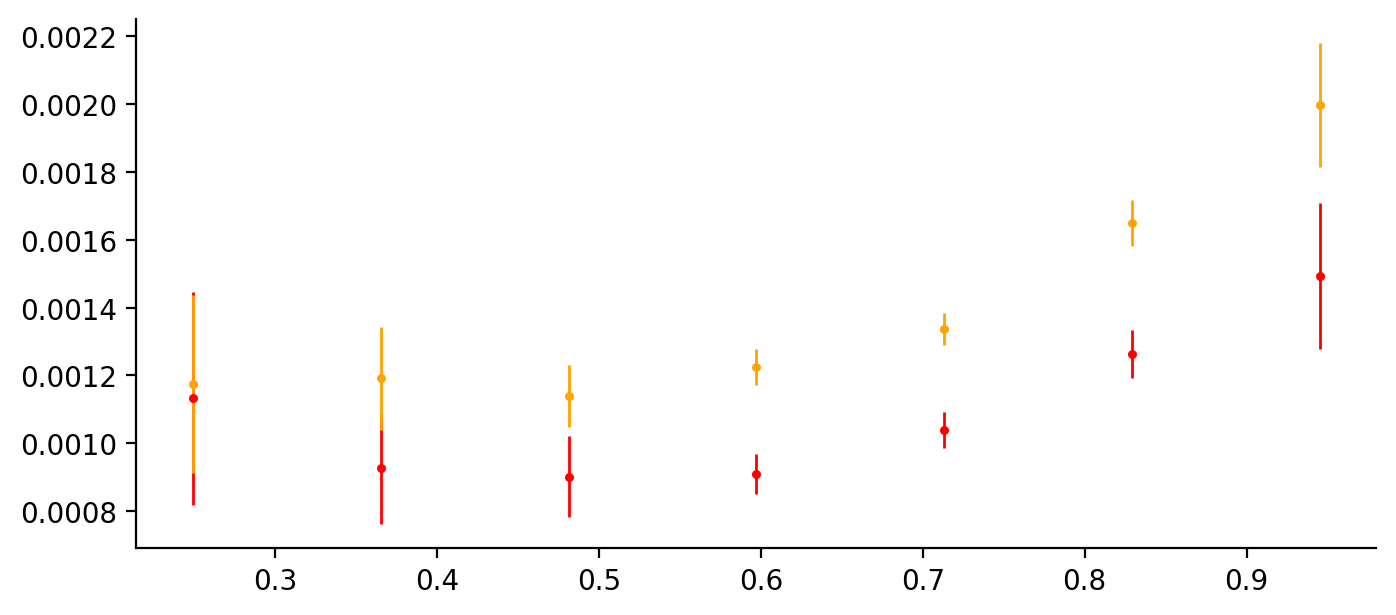

In [488]:
nbins = 10

dbns = binned_summaries(b, nonsyn_prop, nbins, method='interval')
dbs = binned_summaries(b, syn_prop, nbins, method='interval')

figax = binned_means_plot(dbns, c='r', linewidth=1, label='non-syn', min_n=30)
figax = binned_means_plot(dbs, c='orange', linewidth=1, label='syn rs', min_n=30, figax=figax)

In [489]:
corr(x, syn_prop), corr(x, nonsyn_prop), corr(x, branch_length)

(((0.12457822482322829, 3.872782871815567e-37),
  SpearmanrResult(correlation=0.0829749693075475, pvalue=2.6200251983346628e-17)),
 ((0.2005493262667141, 1.537207937548357e-94),
  SpearmanrResult(correlation=0.1753727587754711, pvalue=2.1509854339172384e-72)),
 ((0.18631010538857315, 1.2611039386715817e-81),
  SpearmanrResult(correlation=0.14923778346847832, pvalue=1.044204188810395e-52)))

In [490]:
corr(b, syn_prop), corr(b, nonsyn_prop), corr(b, branch_length)

(((0.12192769887820698, 1.232082926178538e-35),
  SpearmanrResult(correlation=0.13102056230062153, pvalue=6.284371764564953e-41)),
 ((0.08340320158301724, 1.7973552731826872e-17),
  SpearmanrResult(correlation=0.08989939645906504, pvalue=4.672146232582231e-20)),
 ((0.5097277175085859, 0.0),
  SpearmanrResult(correlation=0.5682492006949487, pvalue=0.0)))

In [491]:
corr(x_rs, syn_prop), corr(x_rs, nonsyn_prop), corr(x_rs, branch_length)

(((0.098494872751636, 8.972888938101002e-24),
  SpearmanrResult(correlation=0.038719314275040516, pvalue=8.028938619945999e-05)),
 ((0.1456033122177114, 3.126739868433329e-50),
  SpearmanrResult(correlation=0.11077085252246519, pvalue=1.1376205667819057e-29)),
 ((0.13574059914458136, 7.897370090771364e-44),
  SpearmanrResult(correlation=0.09255314008903998, pvalue=3.615280440357114e-21)))

In [492]:
np.mean((x_rs - branch_length)**2), np.mean((b - branch_length)**2)

(4.271175115073042e-05, 0.5067160935876459)

[]

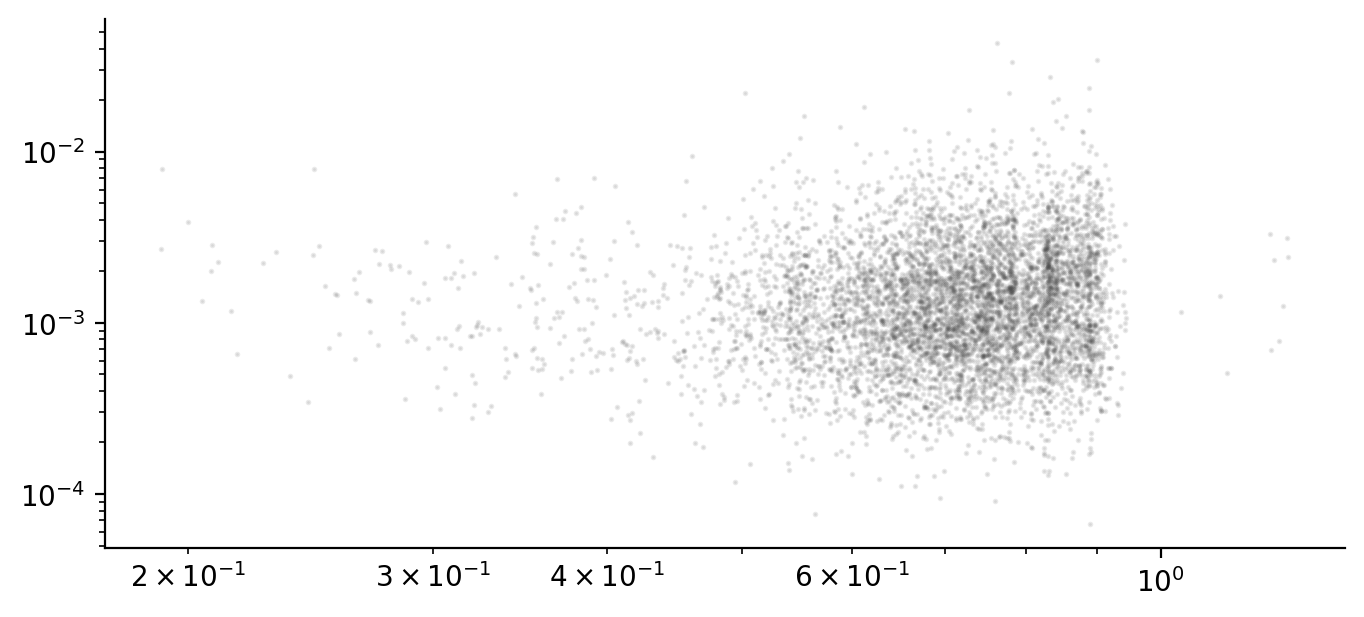

In [494]:
plt.scatter(b, nonsyn_prop, c='0.22', s=1, alpha=0.1)
plt.loglog()

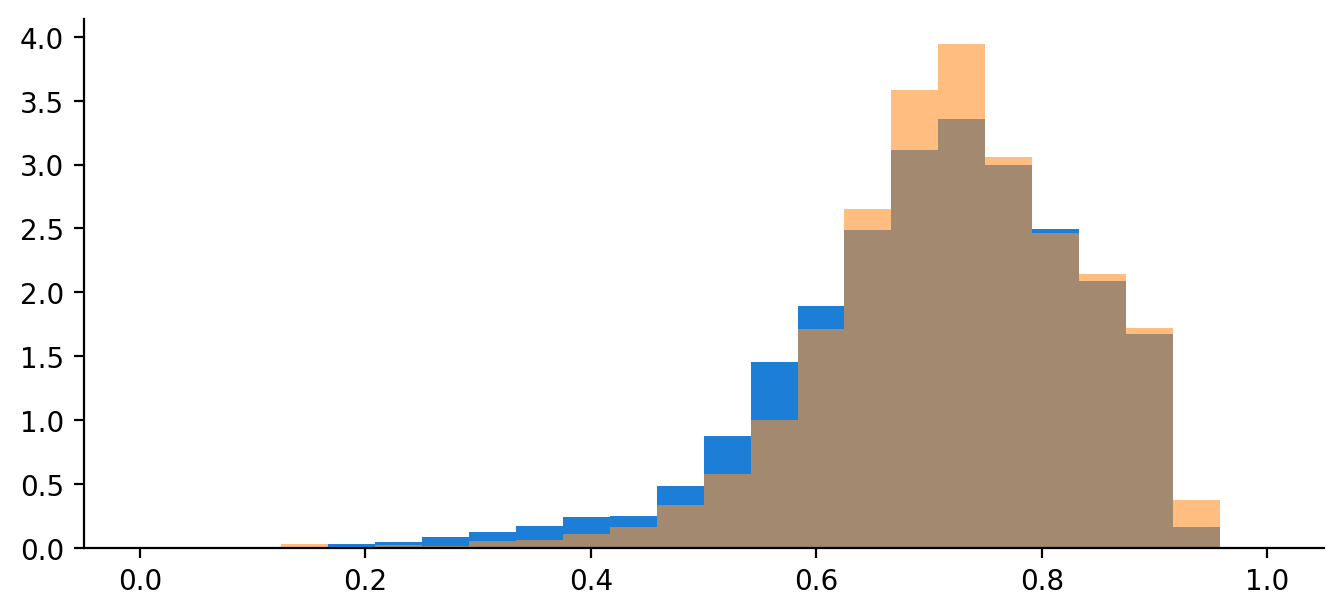

In [495]:

bn = np.linspace(0, 1, 25)
plt.hist(do['B'], bn, density=True)
_ = plt.hist(fit.predict(B=True), bn, density=True, alpha=0.6)

In [519]:
nbins = 14

dns = binned_summaries(x, nonsyn_prop, nbins, method='quantile')
ds = binned_summaries(x, syn_prop, nbins, method='quantile')

dns_rs = binned_summaries(x_rs, nonsyn_prop, nbins, method='quantile')
ds_rs = binned_summaries(x_rs, syn_prop, nbins, method='quantile')

dns_rs = binned_summaries(x_rs, nonsyn_prop, nbins, method='number')
ds_rs = binned_summaries(x_rs, syn_prop, nbins, method='number')

dbl = binned_summaries(x, branch_length, nbins)
dbl_rs = binned_summaries(x_rs, branch_length, nbins)

Text(0.5, 48.0, 'predicted substitution rate')

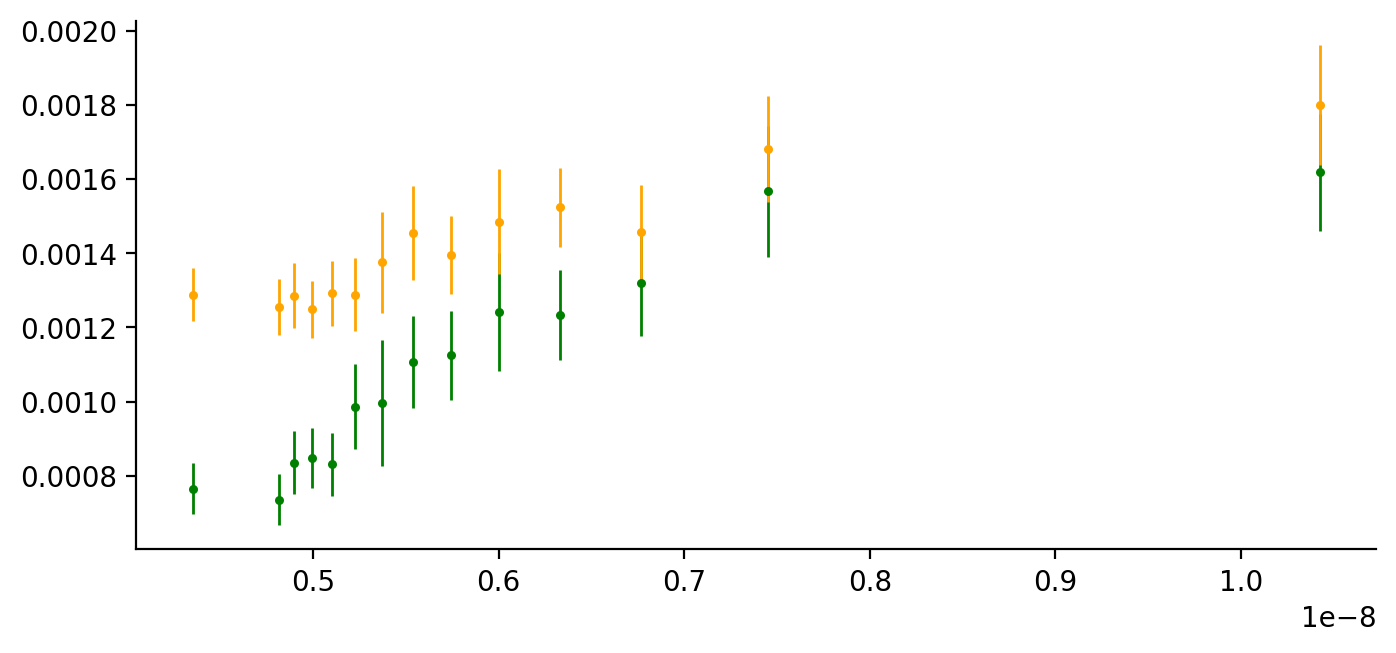

In [520]:
figax = binned_means_plot(dns_rs, c='g', linewidth=1, label='non-syn rs', min_n=30)
figax = binned_means_plot(ds_rs, c='orange', linewidth=1, label='syn rs', min_n=30, figax=figax)
ax.legend(loc='upper left')
ax.set_ylabel('proportion of substitutions')
ax.set_xlabel('predicted substitution rate')

In [514]:
0.5e-8 / 30 * 6.5e6

0.0010833333333333333

(4.906426570648076e-09, 5e-08)

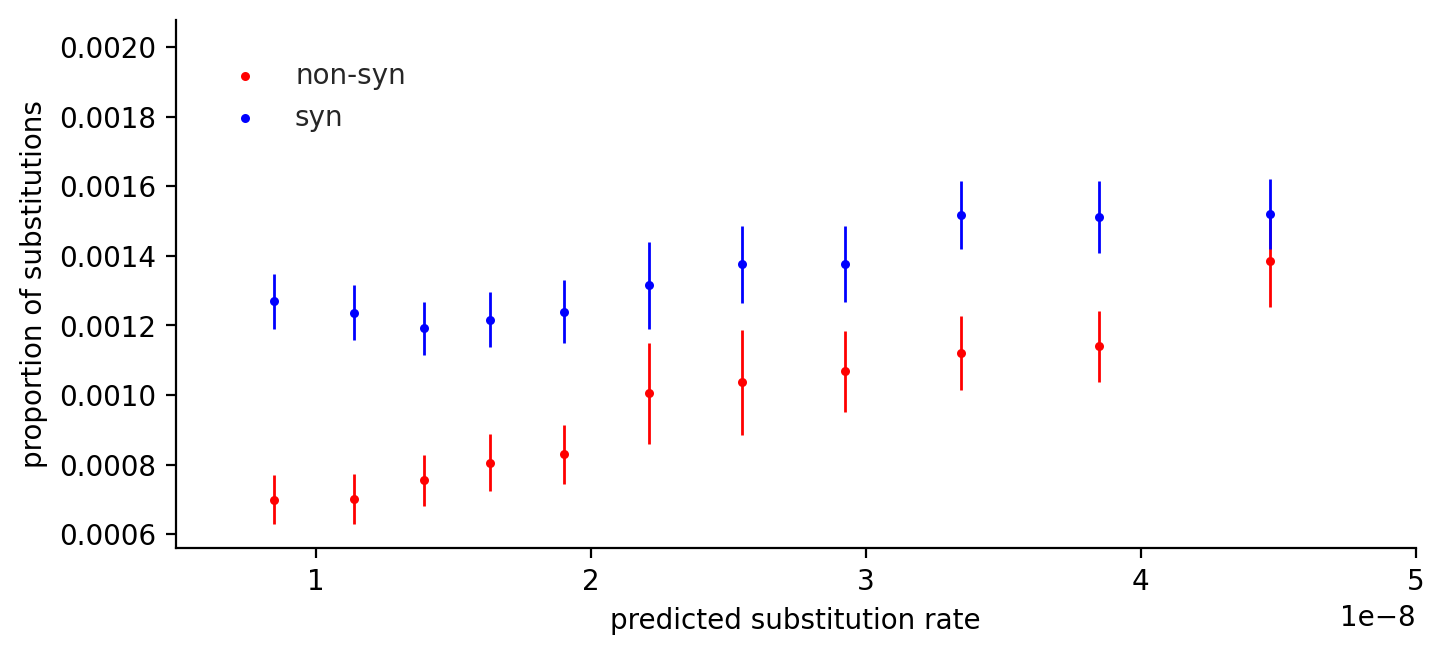

In [501]:
figax = binned_means_plot(dns, c='r', linewidth=1, label='non-syn', min_n=30)
fig, ax = binned_means_plot(ds, figax=figax, c='b', linewidth=1, label='syn', min_n=3)
ax.legend(loc='upper left')
ax.set_ylabel('proportion of substitutions')
ax.set_xlabel('predicted substitution rate')
ax.set_xlim(ax.get_xlim()[0], 5e-8)

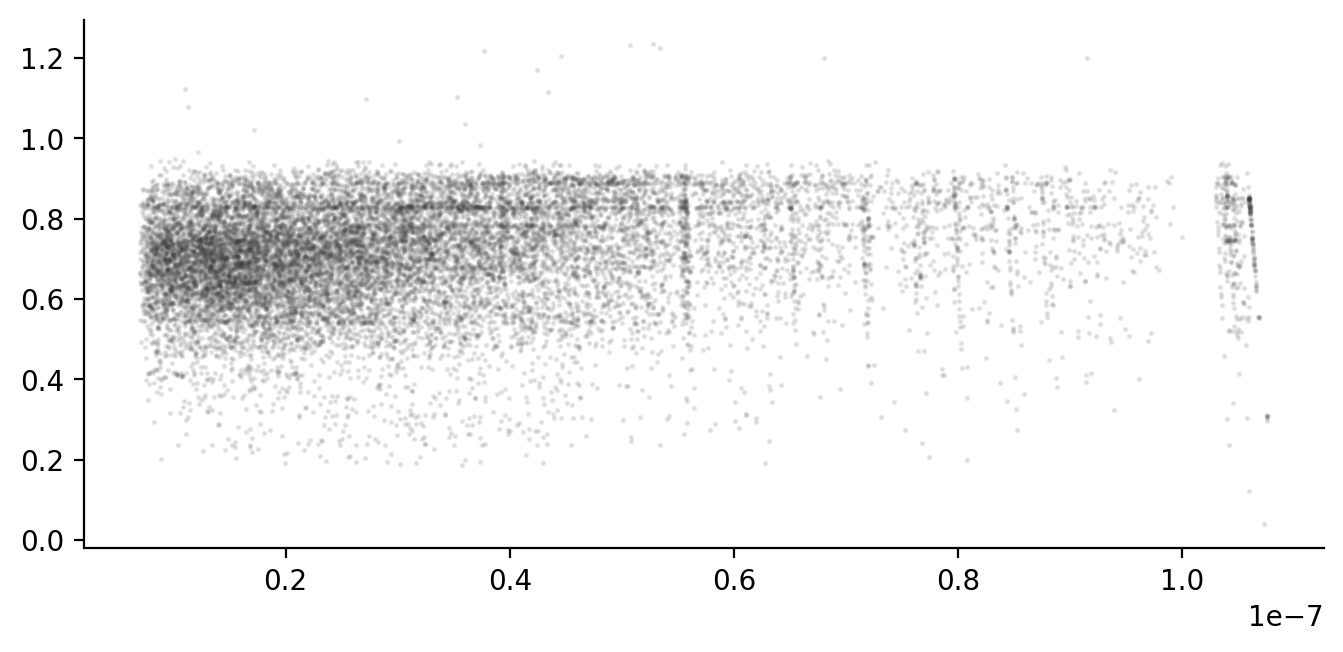

In [241]:
plt.scatter(d['r_rs'], d['B'], c='0.22', s=1, alpha=0.1)

### Cross Validation of Bin Width

In [335]:
x, branch_length = dr2pfo['r'].values, dr2pfo['branch_length'].values
keep = np.isfinite(x) & np.isfinite(branch_length)
x, branch_length = x[keep], branch_length[keep]

In [336]:
branch_length.shape, x.shape

((6147,), (6147,))

In [337]:
#x, syn_prop, nonsyn_prop, branch_length = (do['r'].values, do['syn_prop'].values,
#                                           do['nonsyn_prop'].values, do['branch_length'].values)

# nbins = 50
# dns = binned_summaries(x, nonsyn_prop, nbins)
# ds = binned_summaries(x, syn_prop, nbins)
# dbl = binned_summaries(x, branch_length, nbins)

In [338]:
import warnings
from sklearn.model_selection import KFold, LeaveOneOut
from collections import defaultdict

warnings.filterwarnings(action='once')


bin_range = (x.min(), 1.001*x.max())


kf = KFold(n_splits=100)
loo = LeaveOneOut()

mses = defaultdict(list)

cv_mses = []
nbs = []

def safe_mean(x):
    if not len(x) or np.all(~np.isfinite(x)):
        return np.nan
    return np.nanmean(x)

for nb in np.arange(5, 200, 2).astype(int):
    for train, test in kf.split(x):
        bins = cutbins(x[train], nb, xrange=bin_range)
        bin_means = binned_statistic(x[train], branch_length[train], statistic=safe_mean, bins=bins)
        bin_ns = binned_statistic(x[train], branch_length[train], statistic=lambda x: np.sum(np.isfinite(x)), bins=bins)
        idx = np.digitize(x[test], bins)
        se = (bin_means.statistic[idx-1] - branch_length[test])**2
        weights = bin_ns.statistic[idx-1]
        keep = np.isfinite(se)
        mse = np.average(se[keep], weights=weights[keep])
        mses[nb].append(mse)
        cv_mses.append(mse)
        nbs.append(nb)
        

Text(0.5, 0, 'number of bins')

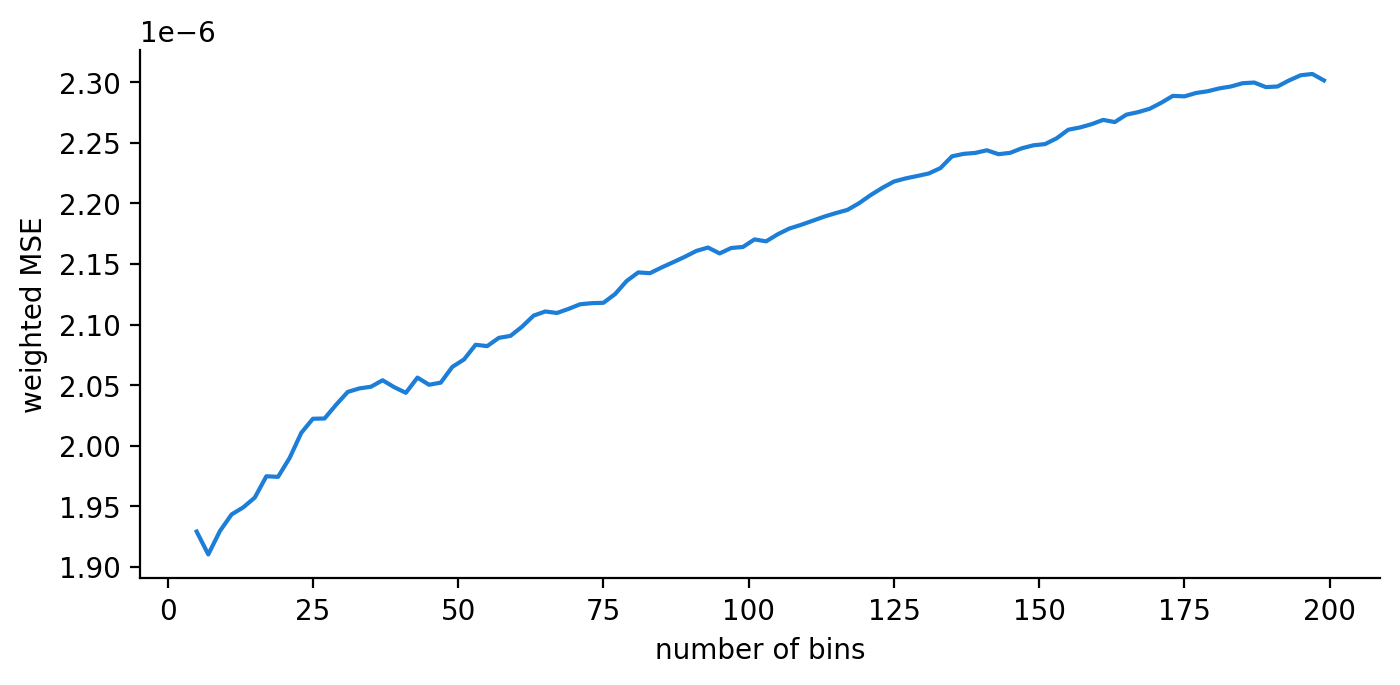

In [339]:
msedat = {nb: np.mean(v) for nb, v in mses.items()}

plt.plot(msedat.keys(), msedat.values())
plt.ylabel("weighted MSE")
plt.xlabel("number of bins")

In [340]:
best_nbin = list(msedat.keys())[np.argmin(list(msedat.values()))]
best_nbin

7

In [560]:
def JC69(dist):
    # distance
    return 0.75 - 0.75*np.exp(-4/3 * dist)

def JC69_parametric(lambda_d, beta, T, lambda_b):
    return JC69(T*(lambda_b + beta*lambda_d))

def fit_JC69(predicted, subrate, gen_time=30, p0=(1, 1e6, 0)):
    lambda_d, y = predicted/gen_time, subrate
    keep = np.isfinite(lambda_d) & np.isfinite(y)
    lambda_d, y = lambda_d[keep], y[keep]
    fit, cv = curve_fit(JC69_parametric, lambda_d, y, p0=p0)
    pred = JC69_parametric(lambda_d, fit[0], fit[1], fit[2])
    return lambda_d, y, (fit, np.mean((pred - y)**2))

xx, yy, fit = fit_JC69(x_rs, syn_prop)
xx_nonsyn, yy_nonsyn, fit_nonsyn = fit_JC69(x_rs, nonsyn_prop)

In [562]:
fit_JC69(x_rs, syn_prop)[2], fit_JC69(x_rs, syn_prop, p0=(1, 6e6, 0))[2]

((array([1.45921446e+00, 2.66201467e+06, 2.48127587e-10]),
  2.3971559108553394e-06),
 (array([7.24876930e-01, 5.35879279e+06, 1.23259326e-10]),
  2.397155910443899e-06))

In [563]:
fit_JC69(x_rs, nonsyn_prop)[2], fit_JC69(x_rs, nonsyn_prop, p0=(1, 6e6, 0))[2]

((array([ 2.37615409e+00,  2.67690819e+06, -5.71231679e-11]),
  2.9080884332781152e-06),
 (array([ 1.08832205e+00,  5.84459021e+06, -2.61611670e-11]),
  2.9080884320319e-06))

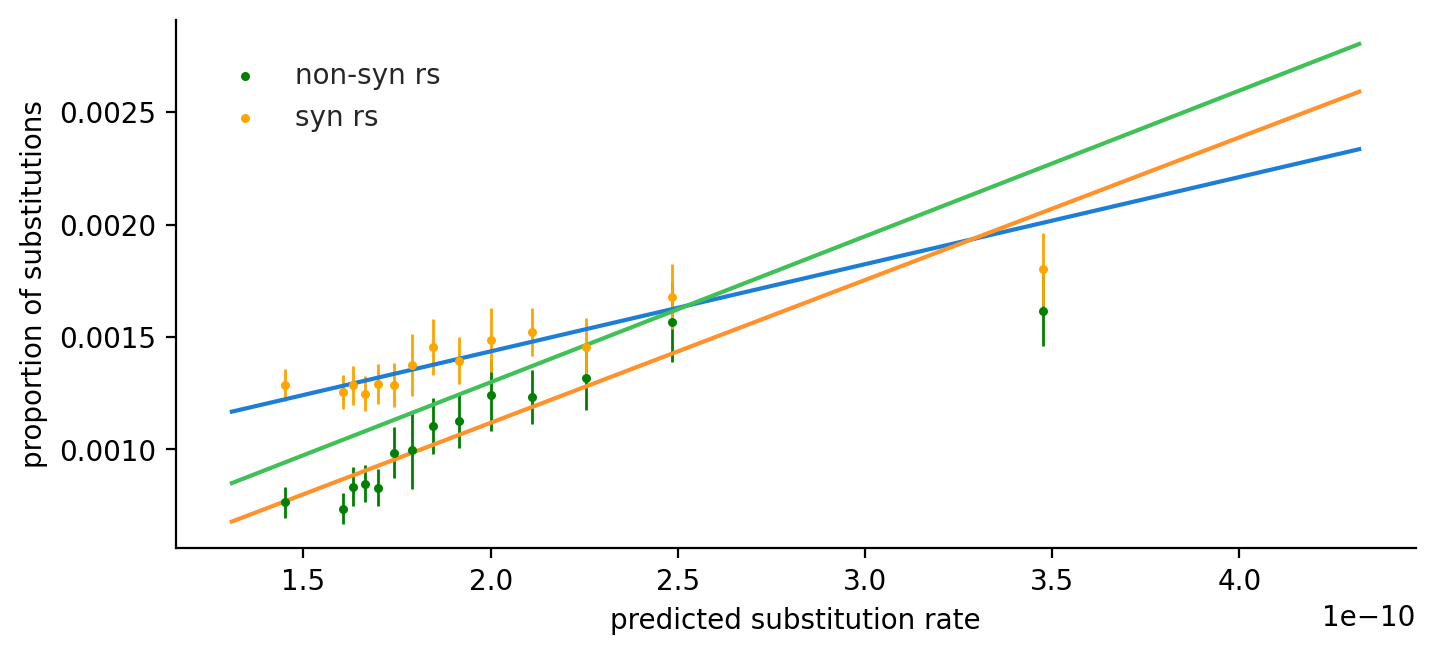

In [574]:
figax = binned_means_plot(dns_rs, c='g', gen=30, linewidth=1, label='non-syn rs', min_n=30)
figax = binned_means_plot(ds_rs, c='orange', gen=30, linewidth=1, label='syn rs', min_n=30, figax=figax)
fig, ax = figax
ax.legend(loc='upper left')
ax.set_ylabel('proportion of substitutions')
ax.set_xlabel('predicted substitution rate')


rate_grid = np.linspace(xx.min(), xx.max(), 100)
ax.plot(rate_grid, JC69_parametric(rate_grid, *fit[0]), label='fit')
ax.plot(rate_grid, JC69_parametric(rate_grid, *fit_nonsyn[0]), label='fit')
ax.plot(rate_grid, JC69_parametric(rate_grid, 1, 6.5e6, 0))

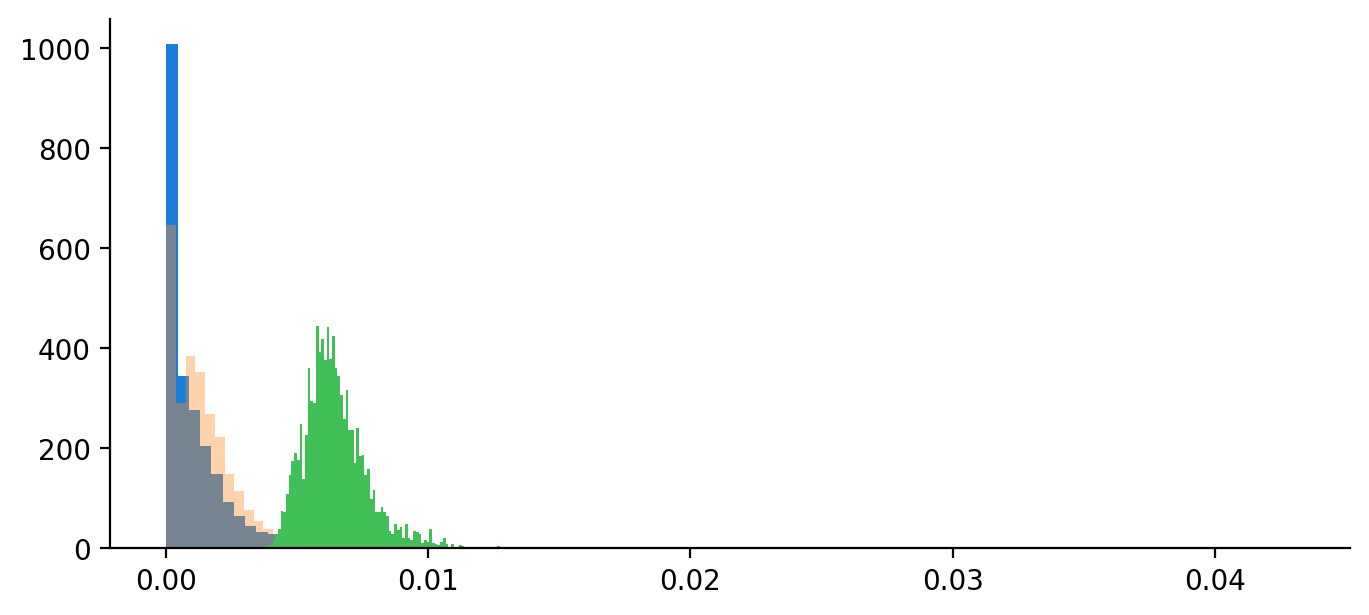

In [282]:
_ = plt.hist(nonsyn_prop, 100, density=True)
_ = plt.hist(syn_prop, 100, density=True, alpha=0.4)
_ = plt.hist(branch_length, 100, density=True)


In [253]:
dr2pfo_bins = binned_summaries(dr2pfo['r'], dr2pfo['branch_length'], nbins=50)

Text(0.5, 0, 'predicted substitution rate')

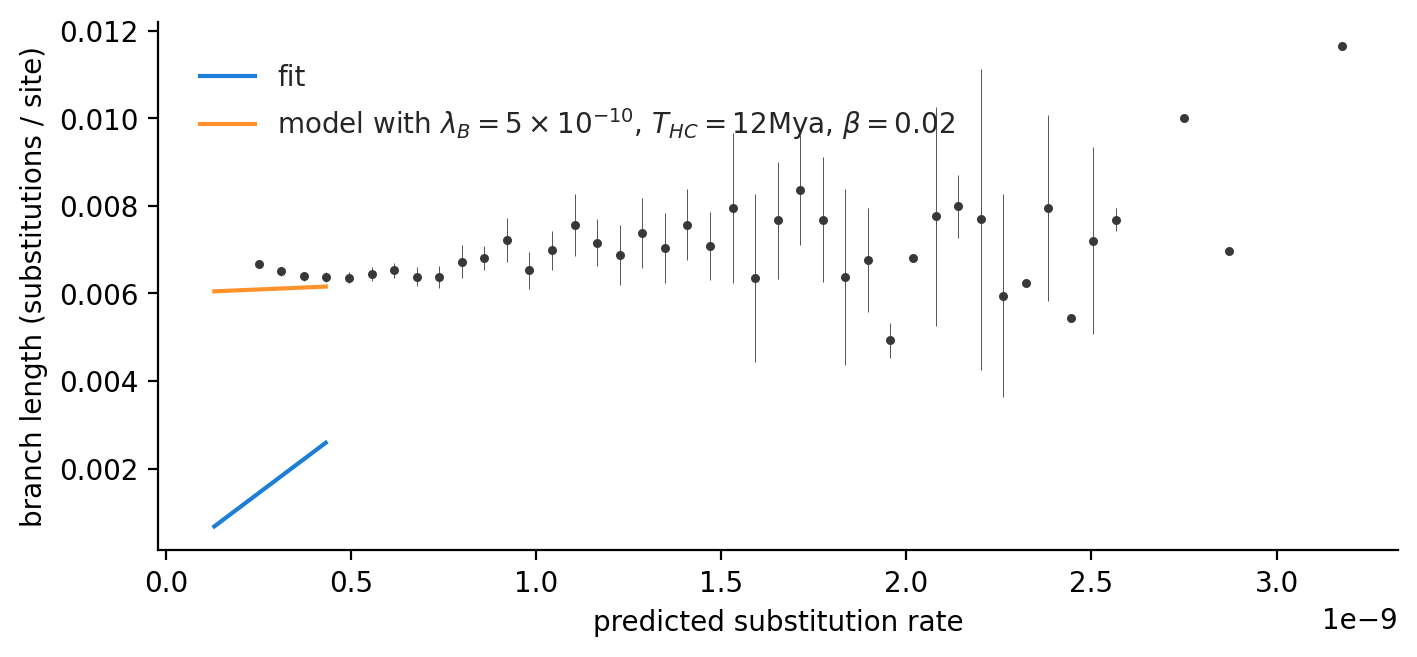

In [529]:
gen = 30
error_col = '0.22'
fig, ax = plt.subplots()
ax.scatter(dr2pfo_bins['midpoint'].values/gen, dr2pfo_bins['mean'].values, c='0.22', s=5, alpha=1, zorder=10)
#ax.set_ylim(0, 0.02)
ax.errorbar(dr2pfo_bins['midpoint']/gen, dr2pfo_bins['mean'], 2*dr2pfo_bins['sd']/np.sqrt(dr2pfo_bins['n']), fmt='none', c=error_col, elinewidth=0.3)

rate_grid = np.linspace(xx.min(), xx.max(), 100)
ax.plot(rate_grid, JC69_parametric(rate_grid, *fit[0]), label='fit')
#ax.plot(rate_grid, JC69_parametric(rate_grid, *bin_fit[0]), label='bin fit')

#ax.set_ylim(0.003, 0.012)


lit_lambda_b, lit_T, lit_beta = 5e-10, 12e6, 0.03
ax.plot(rate_grid, lit_lambda_b*lit_T + lit_T*lit_beta*rate_grid, 
        label='model with $\\lambda_B = 5\\times 10^{-10}$, $T_{HC} = 12$Mya, $\\beta = 0.02$')
ax.legend()
ax.set_ylabel("branch length (substitutions / site)")
ax.set_xlabel("predicted substitution rate")

In [1082]:
nbins = best_nbin
plt.scatter(*bin2pairs(binned_statistic(x, branch_length, np.nanmean, bins=cutbins(x, nbins))))
plt.scatter(*bin2pairs(binned_statistic(x, syn_prop, np.nanmean, bins=cutbins(x, nbins))))
plt.scatter(*bin2pairs(binned_statistic(x, nonsyn_prop, np.nanmean, bins=cutbins(x, nbins))))

AttributeError: The number of `values` elements must match the length of each `sample` dimension.

In [1017]:
nbins = best_nbin

dns = binned_summaries(x, nonsyn_prop, nbins)
ds = binned_summaries(x, syn_prop, nbins)
dbl = binned_summaries(x, branch_length, nbins)

In [1018]:
min_n = 30
dnsx = dns.loc[dns['n'] > min_n]
dsx = ds.loc[ds['n'] > min_n]
dblx = dbl.loc[dbl['n'] > min_n]


Text(0, 0.5, 'proportion substitutions')

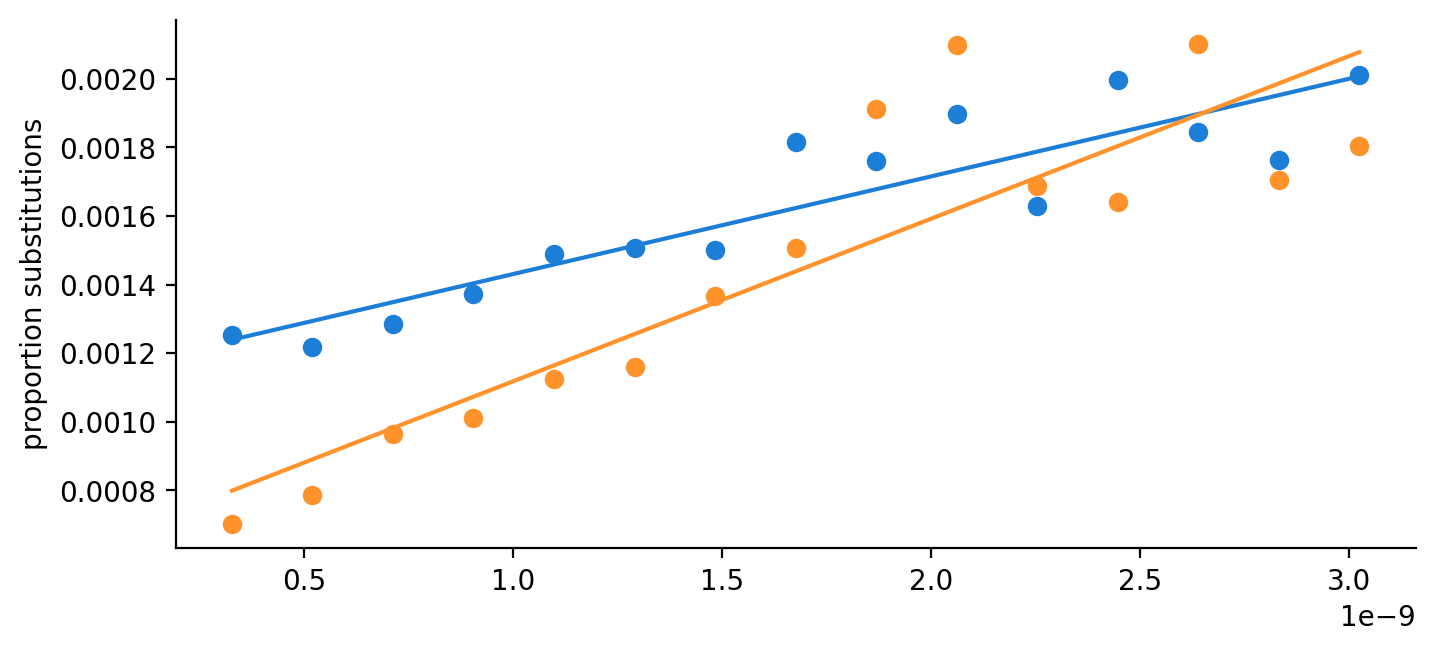

In [1019]:
syn_lfit = stats.linregress(dsx['midpoint']/gen, dsx['mean'])
nonsyn_lfit = stats.linregress(dnsx['midpoint']/gen, dnsx['mean'])

fig, ax = plt.subplots()
ax.scatter(dsx['midpoint']/gen, dsx['mean'], label='syn')
rate_grid = np.linspace(dsx['midpoint'].min(), dsx['midpoint'].max(), 100)/gen
ax.plot(rate_grid, syn_lfit.intercept + syn_lfit.slope*rate_grid)

ax.scatter(dnsx['midpoint']/gen, dnsx['mean'], label='non-syn')
ax.plot(rate_grid, nonsyn_lfit.intercept + nonsyn_lfit.slope*rate_grid)
ax.set_ylabel('proportion substitutions')

In [1058]:
binned_r, binned_bl = dblx['midpoint'].values, dblx['mean'].values
r, bl = do['r'].values, do['branch_length'].values
r1, bl1 = dr2pfo['r'].values, dr2pfo['branch_length'].values

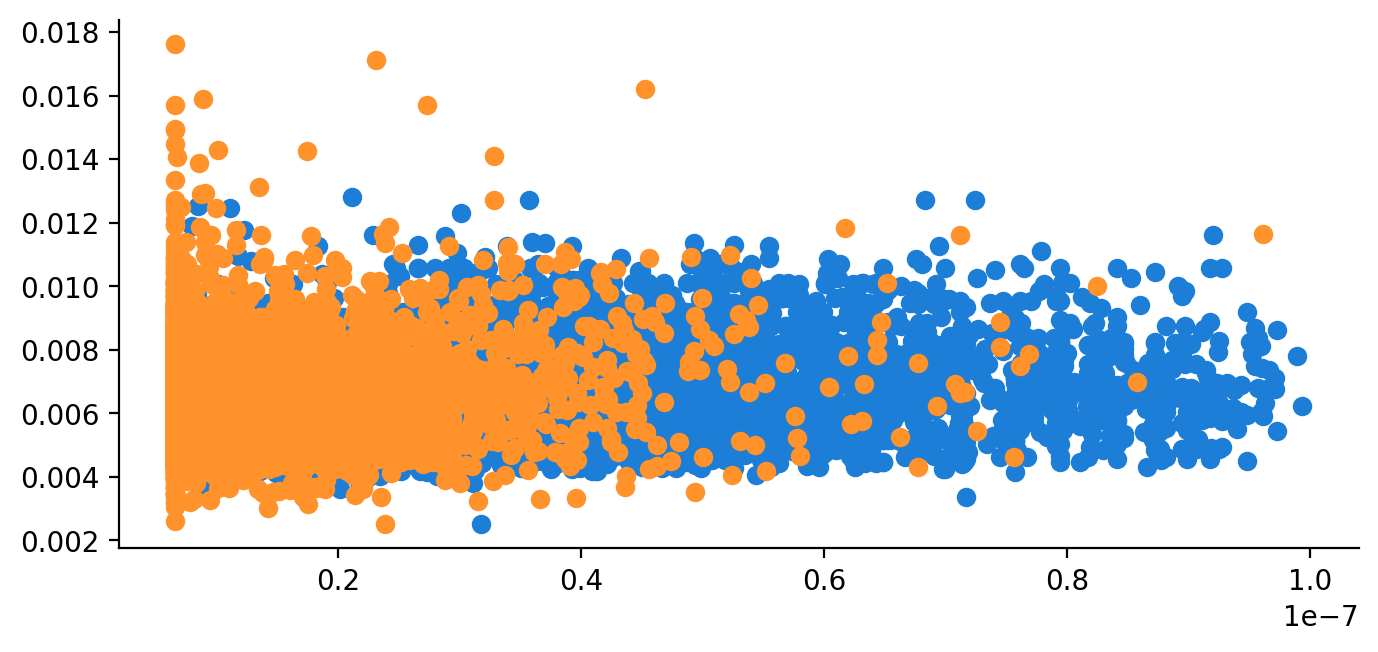

In [1059]:
plt.scatter(r, bl)
plt.scatter(r1, bl1)

(array([9.894e+03, 1.669e+03, 5.630e+02, 1.680e+02, 9.100e+01, 7.200e+01,
        1.100e+01, 5.000e+00, 3.000e+00, 5.000e+00]),
 array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ]),
 <BarContainer object of 10 artists>)

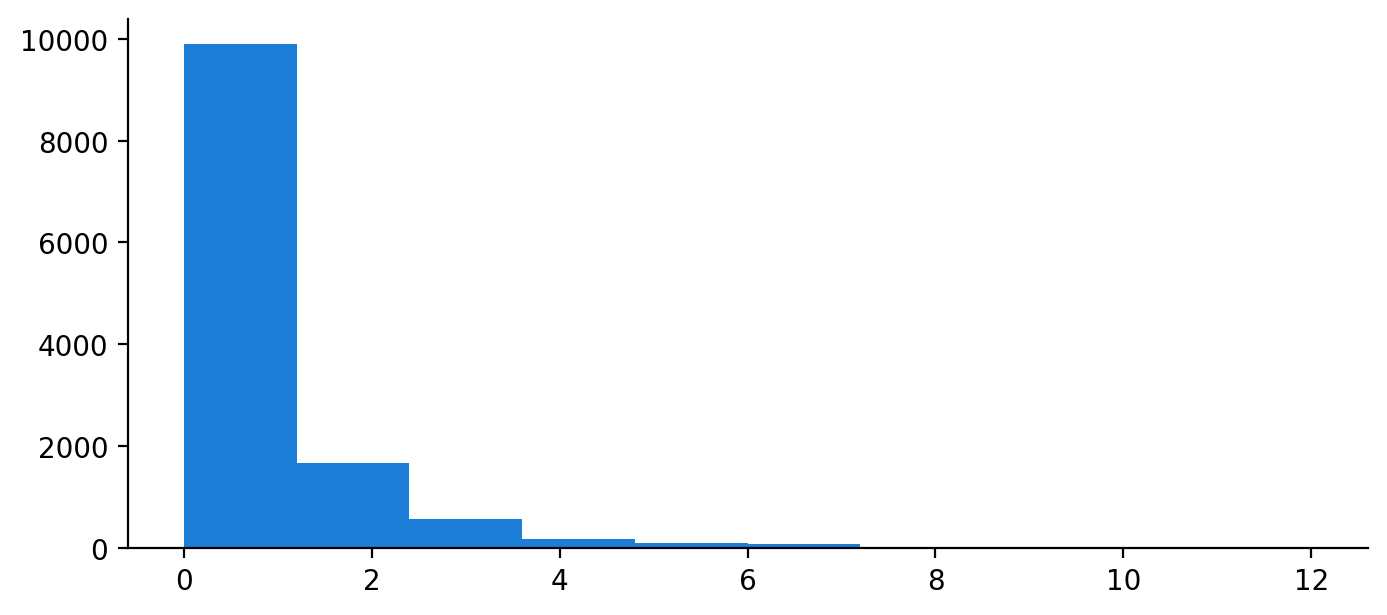

In [797]:
dnds = d['dnDs']
dnds = dnds[np.isfinite(dnds)]
plt.hist(dnds)

In [955]:
np.quantile(dnds, 0.99)

5.0

In [956]:
keep = (d['width'] > 10) & (d['dNdS'] < 5)
r, bl = r[keep], bl[keep]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 6588 but corresponding boolean dimension is 16314

In [1060]:
def fit_JC69(predicted, subrate, gen_time=30):
    lambda_d, y = predicted/gen_time, subrate
    keep = np.isfinite(lambda_d) & np.isfinite(y)
    lambda_d, y = lambda_d[keep], y[keep]
    return lambda_d, y, curve_fit(JC69_parametric, lambda_d, y, p0=(0.02, 6e6, 0))

bin_xx, bin_yy, bin_fit = fit_JC69(binned_r, binned_bl)
xx, yy, fit = fit_JC69(r1, bl1)

In [1061]:
fit_JC69(r1, bl1)[2][0], fit_JC69(r, bl)[2][0]

/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(array([7.59803031e-03, 4.31458274e+07, 1.49843883e-10]),
 array([9.27179968e-03, 3.84113959e+07, 1.58034296e-10]))

In [1064]:
fit_JC69(r1, bl1)[2][0][1]

43145827.42707077

In [803]:
dblx.sort_values('midpoint').tail()

start           end      midpoint      mean        sd      n
12  7.817830e-08  7.269783e-08  7.543806e-08  0.006950  0.001496  104.0
13  8.365877e-08  7.817830e-08  8.091853e-08  0.007031  0.001306  119.0
14  8.913924e-08  8.365877e-08  8.639900e-08  0.006857  0.001302   87.0
15  9.461971e-08  8.913924e-08  9.187947e-08  0.006678  0.001506   76.0
17  1.055806e-07  1.001002e-07  1.028404e-07  0.006834  0.001200  183.0

Text(0.5, 0, 'predicted substitution rate')

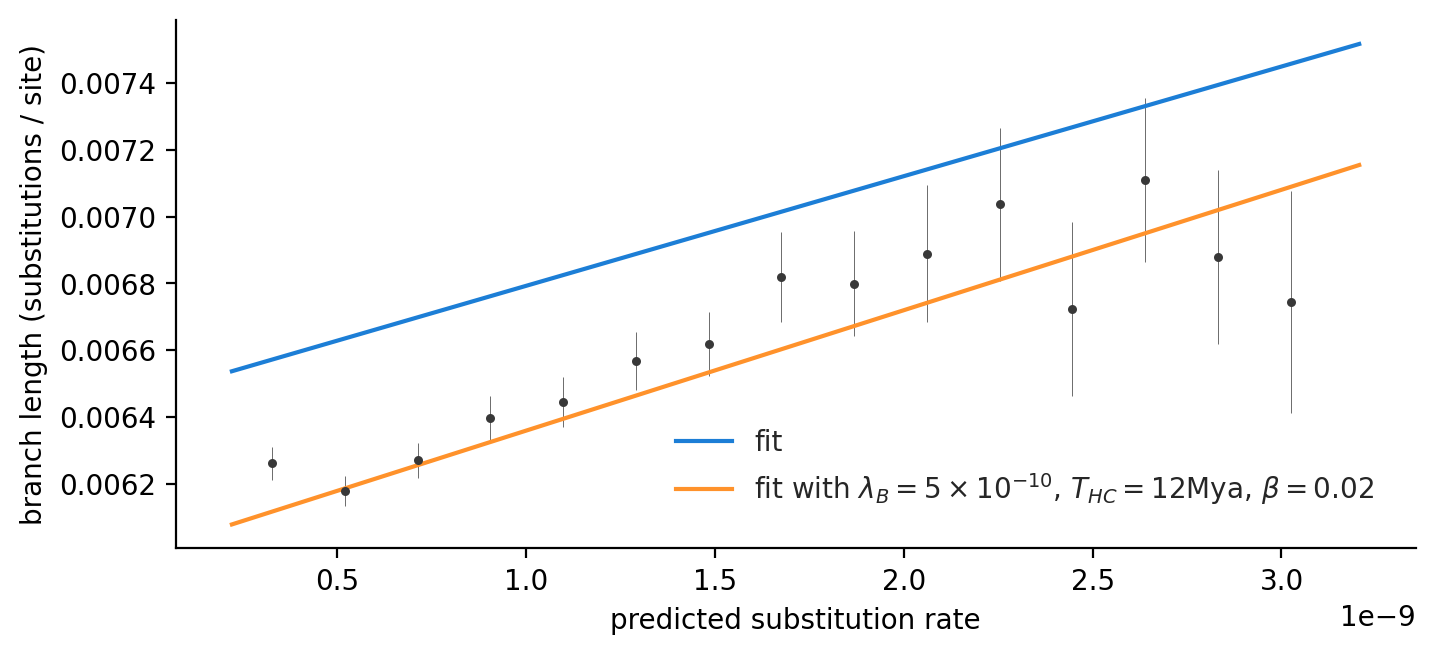

In [1070]:
fig, ax = plt.subplots()
ax.scatter(dblx['midpoint'].values/gen, dblx['mean'].values, c='0.22', s=5, alpha=1, zorder=10)
#ax.set_ylim(0, 0.02)
ax.errorbar(dblx['midpoint']/gen, dblx['mean'], 2*dblx['sd']/np.sqrt(dblx['n']), fmt='none', c=error_col, elinewidth=0.3)

rate_grid = np.linspace(xx.min(), xx.max(), 100)
ax.plot(rate_grid, JC69_parametric(rate_grid, *fit[0]), label='fit')
#ax.plot(rate_grid, JC69_parametric(rate_grid, *bin_fit[0]), label='bin fit')

#ax.set_ylim(0.003, 0.012)


lit_lambda_b, lit_T, lit_beta = 5e-10, 12e6, 0.03
ax.plot(rate_grid, lit_lambda_b*lit_T + lit_T*lit_beta*rate_grid, 
        label='fit with $\\lambda_B = 5\\times 10^{-10}$, $T_{HC} = 12$Mya, $\\beta = 0.02$')
ax.legend()
ax.set_ylabel("branch length (substitutions / site)")
ax.set_xlabel("predicted substitution rate")

In [819]:
#a = binned_summaries(dpf2r['r'], dpf2r['branch_length'], nbins=50)
b = binned_summaries(dr2pf['r'], dr2pf['branch_length'], nbins=50)

<ErrorbarContainer object of 3 artists>

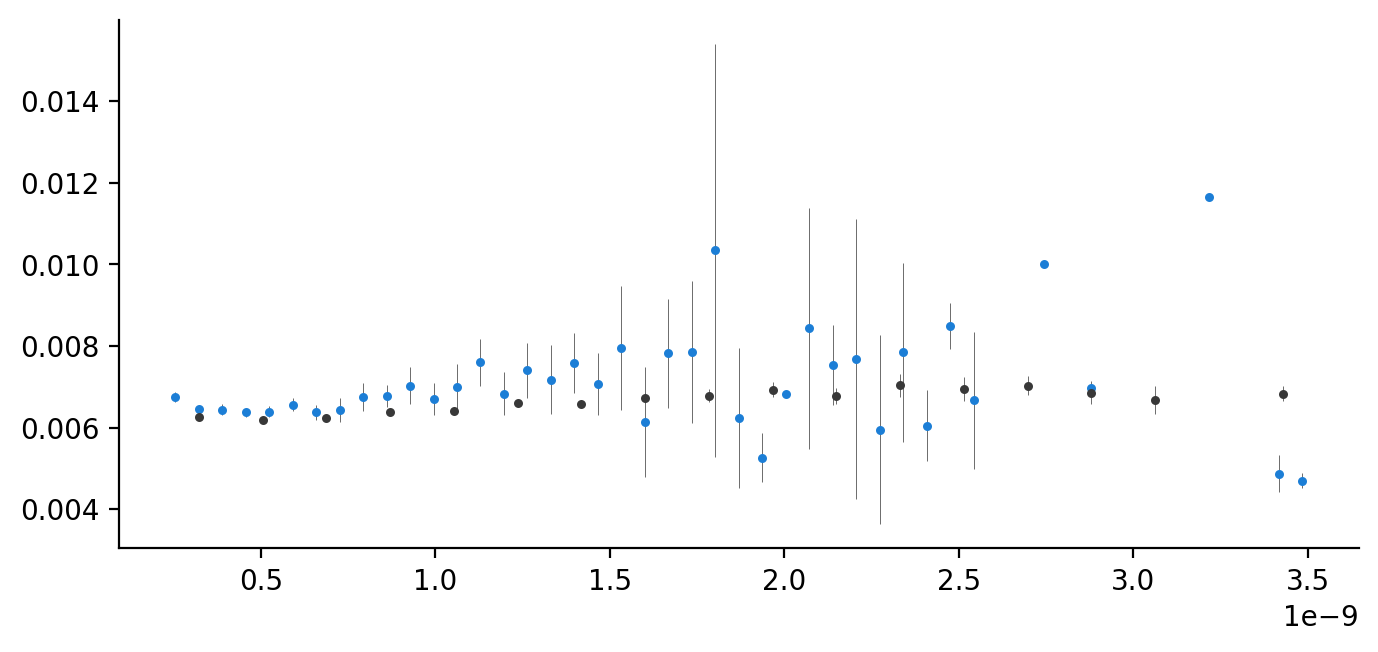

In [827]:
plt.scatter(b['midpoint']/gen, b['mean'], s=5, alpha=1, zorder=10)
plt.errorbar(b['midpoint']/gen, b['mean'], 2*b['sd']/np.sqrt(b['n']), fmt='none', c=error_col, elinewidth=0.3)

plt.scatter(dblx['midpoint'].values/gen, dblx['mean'].values, c='0.22', s=5, alpha=1, zorder=10)
#ax.set_ylim(0, 0.02)
plt.errorbar(dblx['midpoint']/gen, dblx['mean'], 2*dblx['sd']/np.sqrt(dblx['n']), fmt='none', c=error_col, elinewidth=0.3)

In [791]:
def print_subfit(fit, gen_time=30):
    beta, T, a = fit[0]
    info = (f"intercept (λ_B T), a = {a:.3g}\n"
            f"  λ_B = {a / T:.3g} \n"
            f"T = {T/1e6:.4g} (Mya)\n"
            f"β = {beta:.3g}\n"
            f"{(a / T) / (a + T*beta*1e-9)}")
    print(info)
    
print_subfit(fit)

intercept (λ_B T), a = 3.22e-10
  λ_B = 1.67e-17 
T = 19.24 (Mya)
β = 0.0157
5.544491672682292e-14


In [792]:
print_subfit(bin_fit)

intercept (λ_B T), a = 3.18e-10
  λ_B = 1.63e-17 
T = 19.54 (Mya)
β = 0.0127
6.581669282481193e-14


In [1200]:
cols = ['chrom', 'start', 'end', 'feature', 'R', 'r', 'seglen', 'subrate']


dd = pd.read_csv('../data/phylo/good.bed',
            names=cols, sep='\t', na_values='.')
dd = dpf2r

/tmp/ipykernel_45271/90671441.py:4: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  dd = pd.read_csv('../data/phylo/good.bed',


In [1239]:
dd.shape, np.isnan(dd['branch_length']).mean()

((7178677, 8), 0.36476595896430497)

In [197]:
dd_cds = dr2pfo.loc[dr2pfo['feature'] == 'cds']
dd_phastcons = dr2pfo.loc[dr2pfo['feature'] == 'phastcons']
dd_utr = dr2pfo.loc[dr2pfo['feature'] == 'utr']

nbins = 10
dd_cds_binned = binned_summaries(dd_cds['r'], dd_cds['branch_length'], nbins, method='number')
dd_phastcons_binned = binned_summaries(dd_phastcons['r'], dd_phastcons['branch_length'],nbins, method='number')
dd_utr_binned = binned_summaries(dd_utr['r'], dd_utr['branch_length'], nbins, method='number')


dd_cds_binned.head()

KeyError: 'feature'

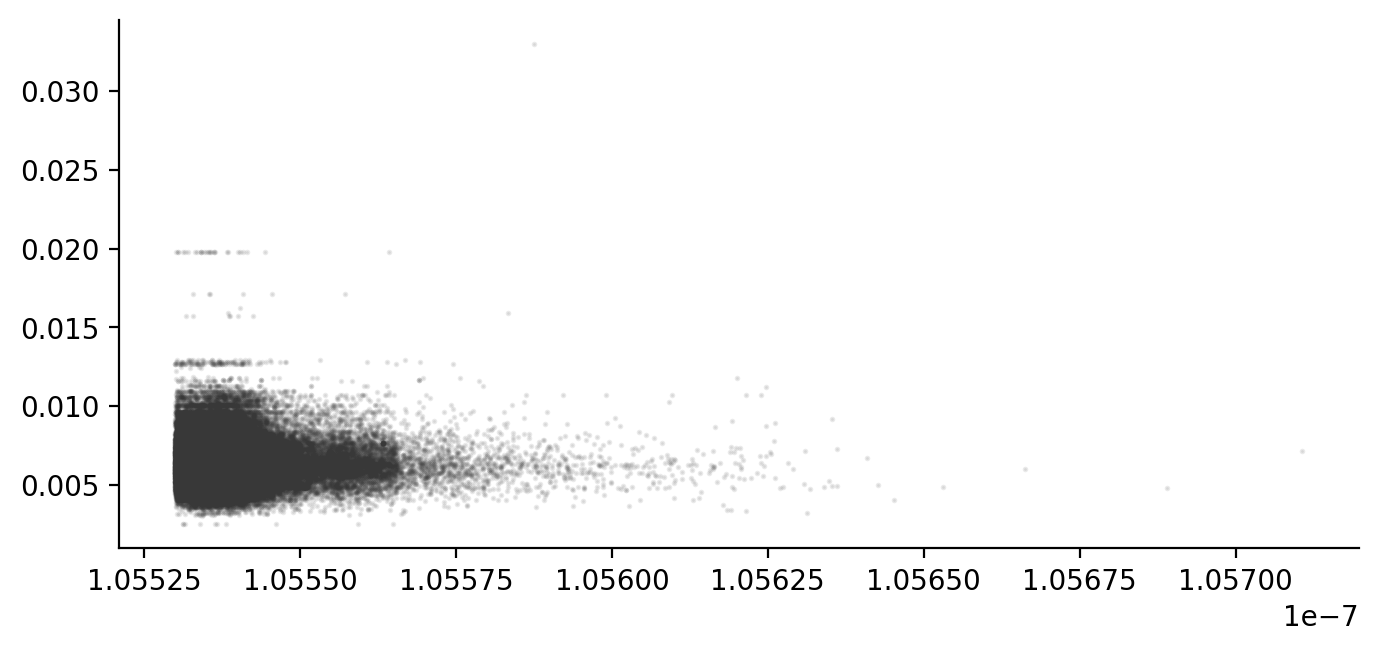

In [1264]:
plt.scatter(dd_cds['r'], dd_cds['branch_length'], c='0.22', s=1, alpha=0.1)

In [1258]:
def binned_means_plot(df, min_n=None, error_col='0.22', linewidth=0.5, figax=None):
    fig, ax = get_figax(figax)
    
    if min_n is not None:
        df = df.loc[df['n'] > min_n]
    x = df['midpoint'].values
    mean, sd = df['mean'].values, df['sd'].values
    n = df['n'].values
    ax.scatter(x, mean, c='0.22', s=5, alpha=1, zorder=10)
    ax.errorbar(x, mean, 2*sd/np.sqrt(n), fmt='none', c=error_col, elinewidth=linewidth)
    return fig, ax

(<Figure size 1600x700 with 1 Axes>, <AxesSubplot: >)

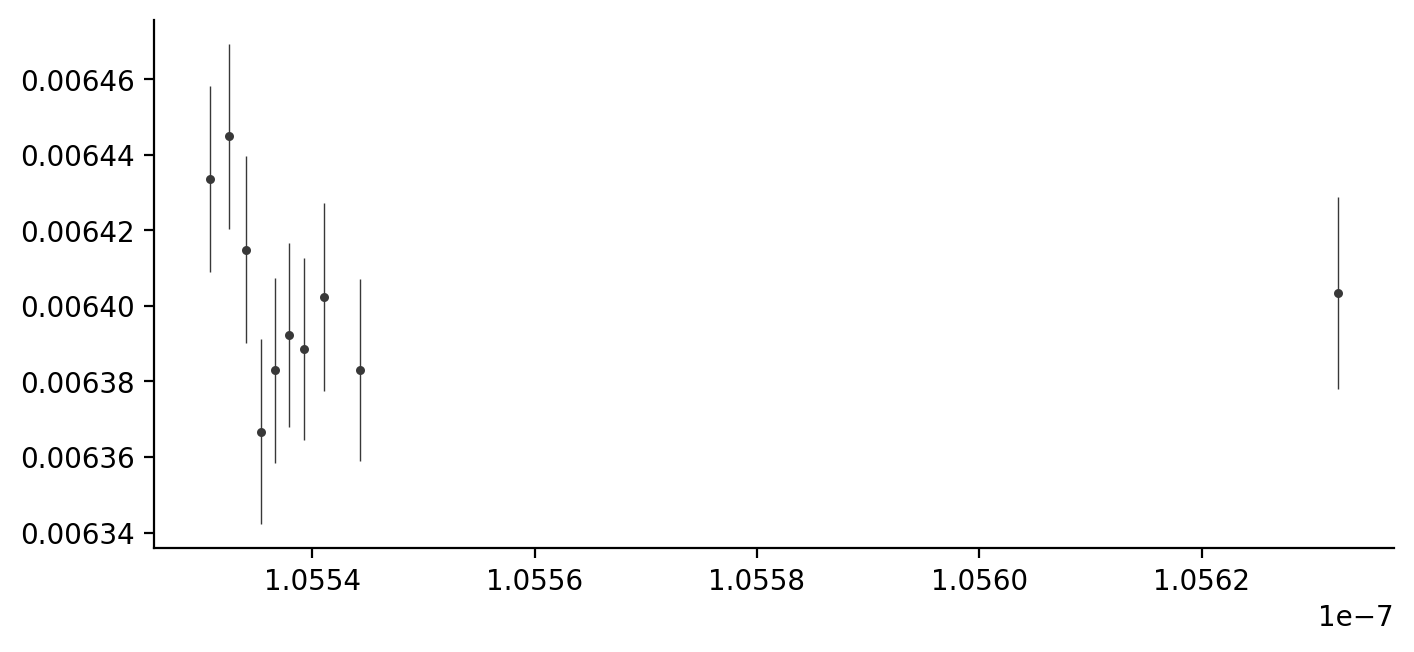

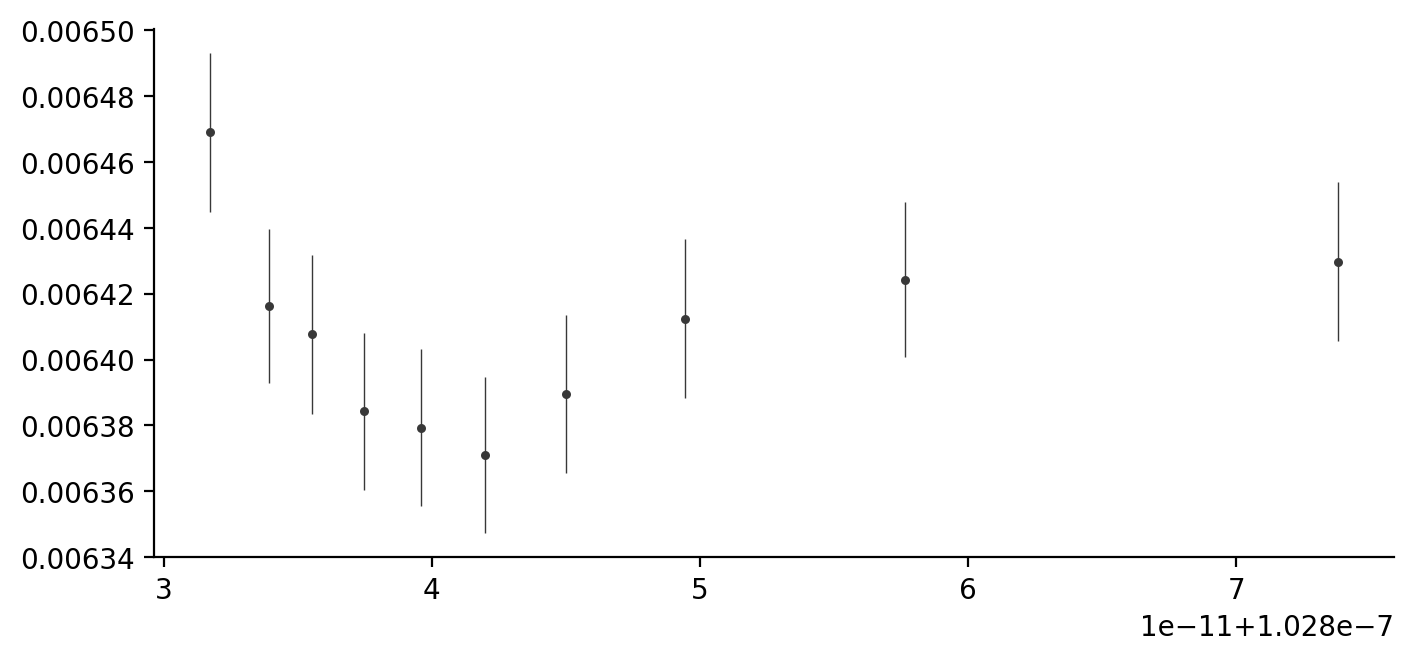

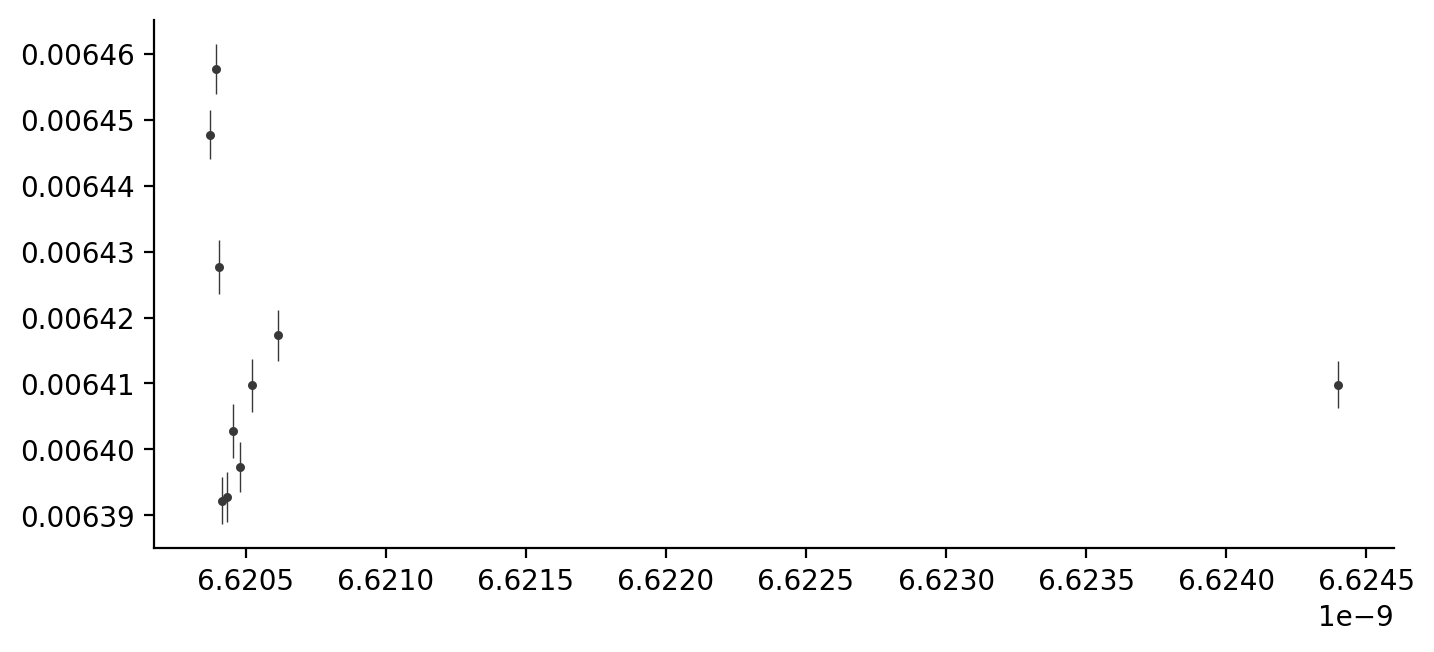

In [1272]:
binned_means_plot(dd_cds_binned, min_n=10)
binned_means_plot(dd_utr_binned, min_n=10)
binned_means_plot(dd_phastcons_binned, min_n=10)

(6.620173385745607e-09, 6.6207e-09)

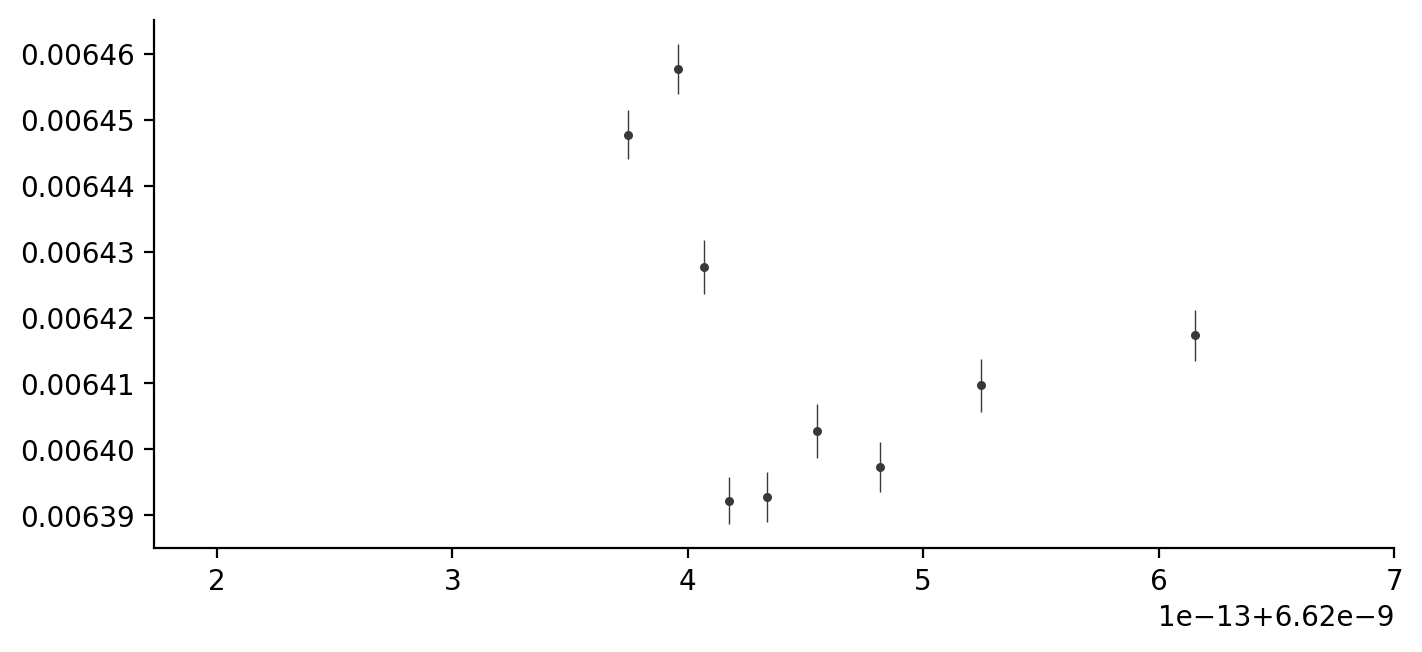

In [1275]:
fig, ax = binned_means_plot(dd_phastcons_binned, min_n=10)
ax.set_xlim(ax.get_xlim()[0], 6.6207e-9)

/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:665: RuntimeWarning: Mean of empty slice
  result[vv, i] = stat_func(np.array(bin_map[i]))
/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


(<Figure size 1600x700 with 1 Axes>, <AxesSubplot: >)

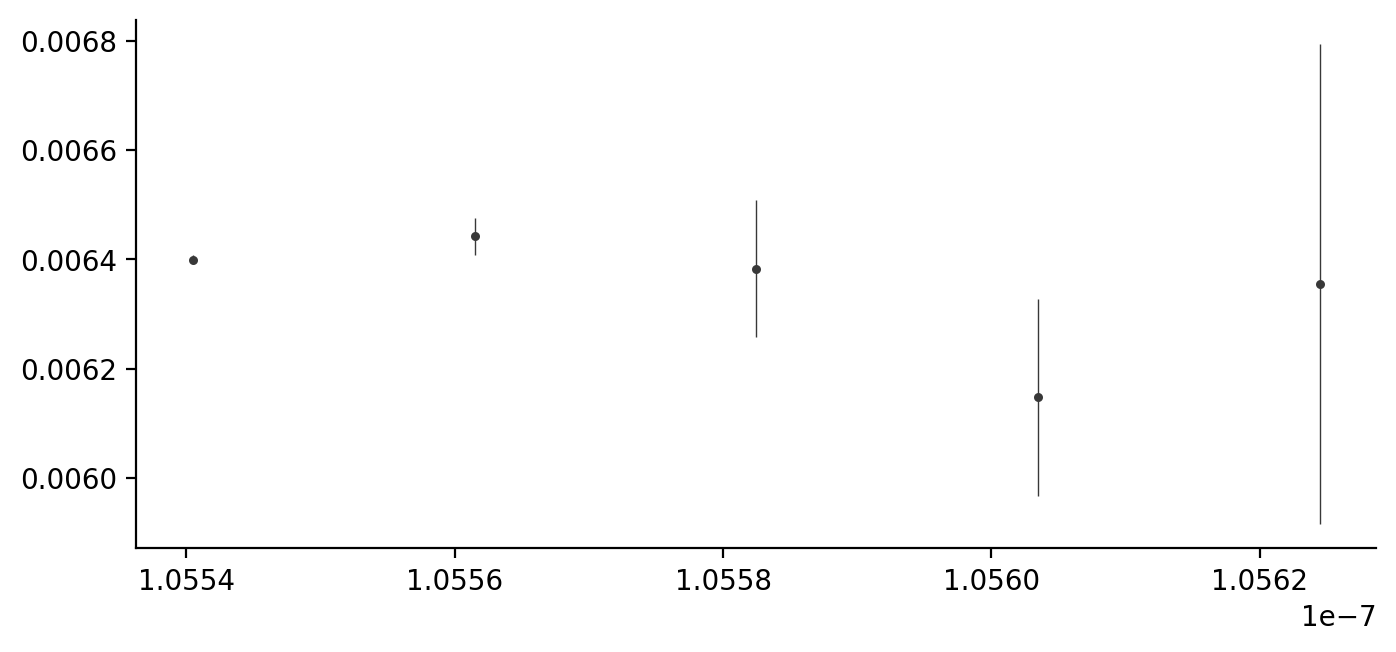

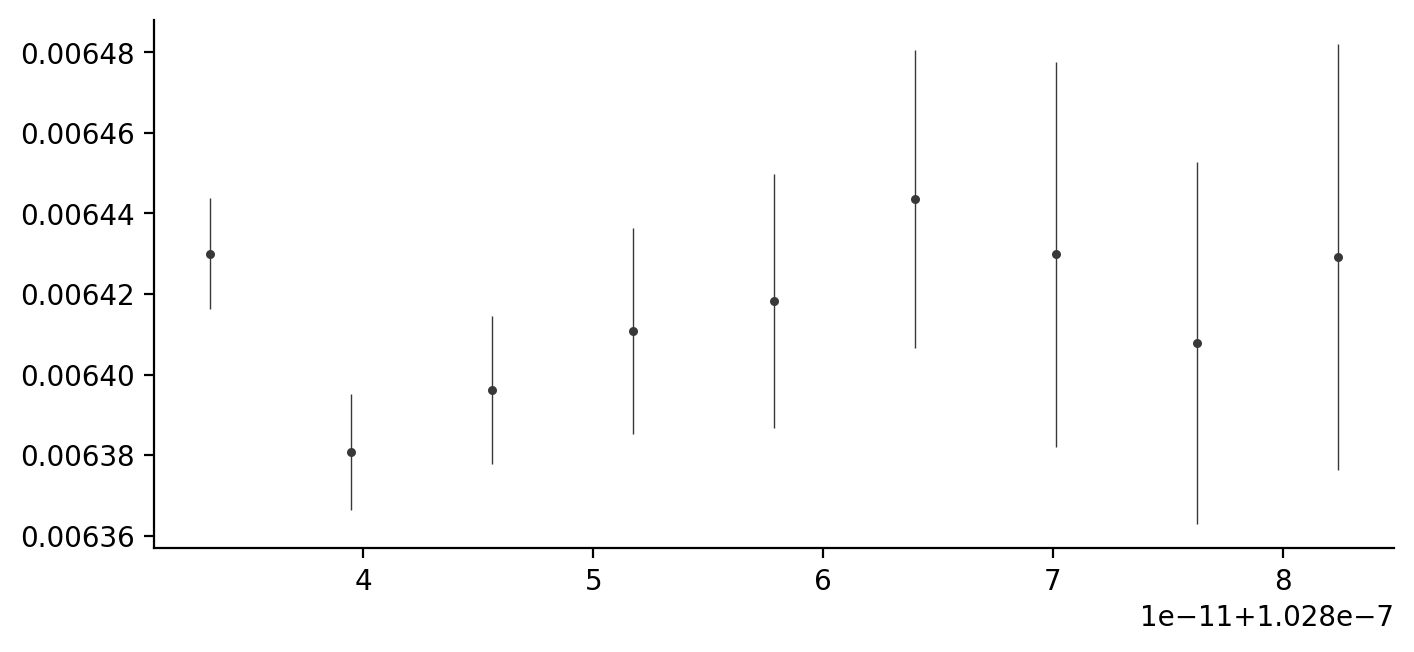

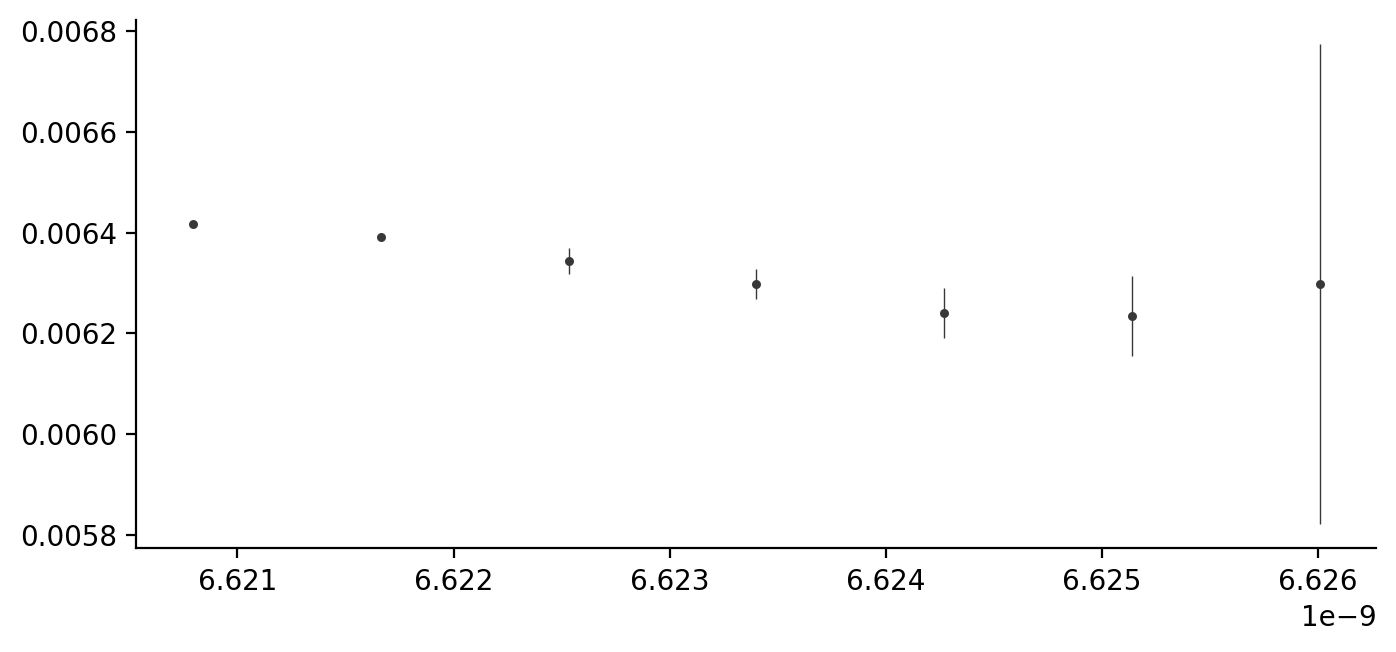

In [1266]:

nbins = 10
dd_cds_binned = binned_summaries(dd_cds['r'], dd_cds['branch_length'], nbins)
dd_phastcons_binned = binned_summaries(dd_phastcons['r'], dd_phastcons['branch_length'], nbins)
dd_utr_binned = binned_summaries(dd_utr['r'], dd_utr['branch_length'], nbins)

binned_means_plot(dd_cds_binned, min_n=10)
binned_means_plot(dd_utr_binned, min_n=10)
binned_means_plot(dd_phastcons_binned, min_n=10)

In [1228]:
#plt.scatter(dd_cds['r'], dd_cds['subrate'])
cds_r, cds_subrate = dd_cds['r'], dd_cds['branch_length']
keep = np.isfinite(cds_r) & np.isfinite(cds_subrate)
cds_r, cds_subrate = cds_r[keep], cds_subrate[keep]
lfit = stats.linregress(cds_r, cds_subrate)
lfit


LinregressResult(slope=-1003103.2957447512, intercept=0.11226757366857096, rvalue=-0.006528633454956384, pvalue=0.034888936998935076, stderr=475478.1775249141, intercept_stderr=0.050181445188847505)